In [1]:
# import argparse
import json
import os
import time
import warnings

from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm
import matplotlib.pyplot as plt
import copy

import torch
import torch.nn.functional as F

import xarray as xr
print(xr.__version__)
from sklearn.metrics import mean_squared_error

# Training settings
# from eval_gcn import ensemble_performance
# from graphino.training import evaluate, train_epoch, get_dataloaders
# from graphino.GCN.GCN_model import GCN

# from utilities.utils import set_gpu, set_seed
# from utilities.model_logging import update_tqdm, log_epoch_vals, save_model
# from utilities.optimization import get_optimizer, get_loss
# import matplotlib.pyplot as plt

/glade/work/wchapman/miniconda3/envs/gputorch/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


0.16.1


## Get Data in the right form

in "utilities" folder

In [2]:
"""
Author: Salva Rühling Cachay
"""

import numpy as np
import pandas as pd
import xarray as xa
import torch
from torch.utils.data import DataLoader

class ENSO_Dataset(torch.utils.data.Dataset):
    def __init__(self, X, labels):
        self.X = torch.tensor(X).float()
        self.labels = torch.tensor(labels).float()

    def __getitem__(self, i):
        return self.X[i], self.labels[i]

    def __len__(self):
        return self.X.shape[0]


def to_dataloaders(cmip5, soda, godas, batch_size, valid_split=0, validation='SODA', verbose=True,
                   concat_cmip5_and_soda=True, shuffle_training=True):
    """
     n - length of time series (i.e. dataset size)
     m - number of nodes/grid cells (33 if using exactly the ONI region)
    """

    sodaX = np.array(soda[0]) if not isinstance(soda[0], np.ndarray) else soda[0]
    cmip5X = np.array(cmip5[0]) if not isinstance(cmip5[0], np.ndarray) else cmip5[0]
    godasX = np.array(godas[0]) if not isinstance(godas[0], np.ndarray) else godas[0]

    if concat_cmip5_and_soda:  # instead of transfer, concat the cmip5 and soda data
        if validation.lower() == 'cmip5':
            first_val = min(len(godas[1]) * 2, 600)
            cmip5_trainX, cmip5_trainY = cmip5X[:-first_val], cmip5[1][:-first_val]
            validX, validY = cmip5X[-first_val:], cmip5[1][-first_val:]
            soda_trainX, soda_trainY = sodaX, soda[1]
        elif 'soda' in validation.lower():
            cmip5_trainX, cmip5_trainY = cmip5X, cmip5[1]
            if valid_split > 0:
                first_val = int(valid_split * len(sodaX))
                soda_trainX, soda_trainY = sodaX[:-first_val], soda[1][:-first_val]
                if validation.lower() == 'soda':
                    validX, validY = sodaX[-first_val:], soda[1][-first_val:]
                else:
                    validX, validY = sodaX, soda[1]
            else:  # without val. set, just return the SODA set
                soda_trainX, soda_trainY = sodaX, soda[1]
                validX, validY = sodaX, soda[1]
        else:
            raise ValueError('Validation dataset must be either CMIP5 or SODA')
        trainX = np.concatenate((cmip5_trainX, soda_trainX), axis=0)
        trainY = np.concatenate((cmip5_trainY, soda_trainY), axis=0)
    else:
        print("Only SODA for training!")
        first_val = int(valid_split * len(soda[0]))
        trainX, trainY = sodaX[:-first_val], soda[1][:-first_val]
        validX, validY = sodaX[-first_val:], soda[1][-first_val:]

    trainset = ENSO_Dataset(trainX, trainY)
    valset = ENSO_Dataset(validX, validY) if validX is not None else []
    testset = ENSO_Dataset(godasX, godas[1])

    if verbose:
        print('Train set:', len(trainset), 'Validation set', len(valset), 'Test set', len(testset))

    train = DataLoader(trainset, batch_size=batch_size, shuffle=shuffle_training)
    test = DataLoader(testset, batch_size=batch_size, shuffle=False)
    val = None if valset == [] else DataLoader(valset, batch_size=batch_size, shuffle=False)
    del trainset, valset, testset
    return train, val, test

def reformat_cnn_data(lead_months=3, window=3, use_heat_content=False,
                      lon_min=0, lon_max=360,
                      lat_min=-55, lat_max=60,
                      data_dir="data/",
                      sample_file='CMIP5.input.36mn.1861_2001.nc',  # Input of training set
                      label_file='CMIP5.label.nino34.12mn_3mv.1863_2003.nc',  # Label of training set
                      sst_key="sst",
                      get_valid_nodes_mask=False,
                      get_valid_coordinates=False
                      ):
    """
    :param lon_min, lon_max, lat_min, lat_max: all inclusive
    """
    import pandas as pd
    lat_p1, lat_p2 = int((lat_min + 55) / 5), min(int((lat_max + 55) / 5), 23)
    lon_p1, lon_p2 = int(lon_min / 5), min(int(lon_max / 5), 71)
    data = xa.open_dataset(f'{data_dir}/{sample_file}')
    labels = xa.open_dataset(f'{data_dir}/{label_file}')
    # Shape T' x 36 x |lat| x |lon|, want : T x 12 x |lat| x |lon|
    lat_sz = lat_p2 - lat_p1 + 1
    lon_sz = lon_p2 - lon_p1 + 1
    features = 2 if use_heat_content else 1
    feature_names = ["sst", "heat_content"] if use_heat_content else ["sst"]

    filtered_region = data.sel(
        {'lat': slice(lat_min, lat_max), 'lon': slice(lon_min, lon_max)}
    )
    filtered_region = filtered_region.rename({"lev": "window", "time": "year"})  # rename coordinate name
    X_all_target_mons = np.empty((data.sizes["time"], 12, features, window, lat_sz, lon_sz))
    Y_all_target_mons = np.empty((data.sizes["time"], 12))
    tg_mons = np.arange(0, 12)
    X_all_target_mons = xa.DataArray(X_all_target_mons, coords=[("year", data.get_index("time")),
                                                                ("tg-mon", tg_mons),
                                                                ("feature", feature_names),
                                                                ("window", np.arange(1, window + 1)),
                                                                ("lat", filtered_region.get_index("lat")),
                                                                ("lon", filtered_region.get_index("lon"))
                                                                ])
    if "CMIP5" not in label_file:
        X_all_target_mons.attrs["time"] = \
            [pd.Timestamp("1982-01-01") + pd.DateOffset(months=d_mon) for d_mon in
             range(len(data.get_index("time")) * 12)]

    X_all_target_mons.attrs["Lons"] = filtered_region.get_index('lon')
    X_all_target_mons.attrs["Lats"] = filtered_region.get_index('lat')
    for target_month in range(0, 12):
        '''
        target months are indices [25, 36)
        possible predictor months (for lead months<=24) are indices [0, 24]
        '''
        var_dict = {"ld_mn2": int(25 - lead_months + target_month) + 1,
                    "ld_mn1": int(25 - lead_months + target_month) + 1 - window}
        X_all_target_mons.loc[:, target_month, "sst", :, :, :] = \
            filtered_region.variables[sst_key][:, var_dict["ld_mn1"]:var_dict["ld_mn2"], :, :]

        if use_heat_content:
            X_all_target_mons.loc[:, target_month, "heat_content", :, :, :] = \
                filtered_region.variables['t300'][:, var_dict["ld_mn1"]:var_dict["ld_mn2"], :, :]

        Y_all_target_mons[:, target_month] = labels.variables['pr'][:, target_month, 0, 0]
    X_all_target_mons = X_all_target_mons.stack(time=["year", "tg-mon"])

    Y_time_flattened = Y_all_target_mons.reshape((-1,))
    X_node_flattened = X_all_target_mons.stack(cord=["lat", "lon"])
    X_time_and_node_flattened = X_node_flattened.transpose("time", "feature", "window", "cord")

    if get_valid_nodes_mask:
        sea = (np.count_nonzero(X_time_and_node_flattened[:, 0, 0, :], axis=0) > 0)
        if get_valid_coordinates:
            return X_time_and_node_flattened, Y_time_flattened, sea, X_time_and_node_flattened.get_index("cord")
        return X_time_and_node_flattened, Y_time_flattened, sea

    return X_time_and_node_flattened, Y_time_flattened


def load_cnn_data(lead_months=3, window=3, use_heat_content=False,
                  lon_min=0, lon_max=359,
                  lat_min=-55, lat_max=60,
                  data_dir="data/",
                  cmip5_data='CMIP5.input.36mn.1861_2001.nc',  # Input of CMIP5 training set
                  cmip5_label='CMIP5.label.nino34.12mn_3mv.1863_2003.nc',  # Label of training set
                  soda_data='SODA.input.36mn.1871_1970.nc',  # Input of SODA training set
                  soda_label='SODA.label.nino34.12mn_3mv.1873_1972.nc',  # Label of training set
                  godas_data='GODAS.input.36mn.1980_2015.nc',  # Input of GODAS training set
                  godas_label='GODAS.label.12mn_3mv.1982_2017.nc',  # Label of training set
                  truncate_GODAS=True,  # whether to truncate it to the 1984-2017 period the CNN paper used
                  return_new_coordinates=False,
                  return_mask=False,
                  add_index_node=False,
                  verbose=True, **kwargs
                  ):
    """

    :param lead_months:
    :param window:
    :param use_heat_content:
    :param lon_min:
    :param lon_max:
    :param lat_min:
    :param lat_max:
    :param data_dir:
    :param cmip5_data:
    :param cmip5_label:
    :param soda_data:
    :param soda_label:
    :param godas_data:
    :param godas_label:
    :param truncate_GODAS:
    :param return_new_coordinates:
    :param return_mask:
    :param target_months: if "all", the model will need to learn to give predictions for any target months,
                            if an int in [1, 12], it can focus on that specific target month/season,
                            where 1 translates to "JFM", ..., 12 to "DJF"
    :return:
    """
    cmip5, cmip5_Y, m1 = reformat_cnn_data(lead_months=lead_months, window=window,
                                           use_heat_content=use_heat_content,
                                           lon_min=lon_min, lon_max=lon_max, lat_min=lat_min, lat_max=lat_max,
                                           data_dir=data_dir + "CMIP5_CNN/", sst_key="sst1",
                                           sample_file=cmip5_data, label_file=cmip5_label,
                                           get_valid_nodes_mask=True, get_valid_coordinates=False)
    SODA, SODA_Y, m2 = reformat_cnn_data(lead_months=lead_months, window=window, use_heat_content=use_heat_content,
                                         lon_min=lon_min, lon_max=lon_max, lat_min=lat_min, lat_max=lat_max,
                                         data_dir=data_dir + "SODA/", sample_file=soda_data, label_file=soda_label,
                                         get_valid_nodes_mask=True, get_valid_coordinates=False)
    GODAS, GODAS_Y, m3 = reformat_cnn_data(lead_months=lead_months, window=window, use_heat_content=use_heat_content,
                                           lon_min=lon_min, lon_max=lon_max, lat_min=lat_min, lat_max=lat_max,
                                           data_dir=data_dir + "GODAS/", sample_file=godas_data, label_file=godas_label,
                                           get_valid_nodes_mask=True, get_valid_coordinates=False)
    if truncate_GODAS:
        start_1984 = 24  # 2 * 12
        GODAS, GODAS_Y, GODAS.attrs["time"] = GODAS[start_1984:], GODAS_Y[start_1984:], GODAS.attrs["time"][start_1984:]
    # DUE to variations due to resolution = 5deg., there are some inconsistencies in which nodes are terrestrial
    final_mask = np.logical_and(m1, np.logical_and(m2, m3))
    cmip5, SODA, GODAS = cmip5[:, :, :, final_mask], SODA[:, :, :, final_mask], GODAS[:, :, :, final_mask]
    if add_index_node:
        cmip5, SODA, GODAS = add_ONI_node(cmip5), add_ONI_node(SODA), add_ONI_node(GODAS)
        # cords = np.array(list(cords) + [(0, 205)])  # add coordinate for ONI
        final_mask = np.append(final_mask, True)  # add
        if verbose:
            print('MASKING OUT', np.count_nonzero(np.logical_not(final_mask)), 'nodes')
    cords = GODAS.indexes['cord']
    if return_new_coordinates:
        # cords = cords[final_mask]
        if return_mask:
            return (cmip5, cmip5_Y), (SODA, SODA_Y), (GODAS, GODAS_Y), cords, final_mask
        return (cmip5, cmip5_Y), (SODA, SODA_Y), (GODAS, GODAS_Y), cords
    if return_mask:
        return (cmip5, cmip5_Y), (SODA, SODA_Y), (GODAS, GODAS_Y), final_mask
    return (cmip5, cmip5_Y), (SODA, SODA_Y), (GODAS, GODAS_Y)


def add_ONI_node(data_array):
    """

    :param data_array: A xarray DataArray of shape (#time-steps, #features, window, #nodes)
    :return: A xarray DataArray of shape (#time-steps, #features, window, #nodes + 1)
    """
    _, mask = get_index_mask(data_array[:, 0, 0, :], 'ONI', flattened_too=True, is_data_flattened=True)
    mask = np.array(mask)
    oni_cord_index = pd.MultiIndex.from_tuples([(0, 205)], names=['lat', 'lon'])
    ONI_NODE = data_array[:, :, :, mask].mean(dim='cord', keepdims=True).assign_coords({'cord': oni_cord_index})
    data_array = xa.concat((data_array, ONI_NODE), dim='cord')
    return data_array

## In Utiliies folder 

in file utils.py

In [3]:
"""
Author: Salva Rühling Cachay
"""

import os
import re
import time
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import xarray as xa

def cord_mask(data: xa.DataArray, is_flattened=False, flattened_too=False, lat=(-5, 5), lon=(190, 240)):
    """
    :param data:
    :param dim:
    :return:
    """
    oni_mask = {'time': slice(None), 'lat': slice(lat[0], lat[1]), 'lon': slice(lon[0], lon[1])}
    if flattened_too:
        flattened = data.copy() if is_flattened else data.stack(cord=['lat', 'lon']).copy()
        flattened[:, :] = 0
        flattened.loc[oni_mask] = 1  # Masked (ONI) region has 1 as value
        flattened_mask = (flattened[0, :] == 1)
        # print(np.count_nonzero(flattened_mask), '<<<<<<<<<<<<<<<<<')
        # flattened.sel(oni_mask) == flattened.loc[:, flattened_mask]
        return oni_mask, flattened_mask
    return oni_mask

def get_index_mask(data, index, flattened_too=False, is_data_flattened=False):
    """
    Get a mask to mask out the region used for  the ONI/El Nino3.4 or ICEN index.
    :param data:
    :param index: ONI or Nino3.4 or ICEN
    :return:
    """
    lats, lons = get_region_bounds(index)
    return cord_mask(data, lat=lats, lon=lons, flattened_too=flattened_too, is_flattened=is_data_flattened)


def get_region_bounds(index):
    if index.lower() in ["nino3.4", "oni"]:
        return (-5, 5), (190, 240)  # 170W-120W
    elif index.lower() == "icen":
        return (-10, 0), (270, 280)  # 90W-80W
    elif index.lower() in ["all", "world"]:
        return (-60, 60), (0, 360)  #
    else:
        raise ValueError("Unknown region/index")


def is_in_index_region(lat, lon, index="ONI"):
    lat_bounds, lon_bounds = get_region_bounds(index=index)
    if lat_bounds[0] <= lat <= lat_bounds[1]:
        if lon_bounds[0] <= lon <= lon_bounds[1]:
            return True
    return False


def get_euclidean_adj(data, radius_lat=3, radius_lon=3, self_loop=True):
    """

    :param data:
    :param radius_lat: degrees latitude that will be considered direct neighbors
    :param radius_lon: degrees longitude that will be considered direct neighbors
    :param self_loop: whether to add self-loops (default) or not
    :return:
    """
    n_nodes = len(data.indexes['cord'])
    adj = np.zeros((n_nodes, n_nodes))  # N x N
    tmp = xa.DataArray(adj, dims=("x1", "cord"), coords={"x1": range(n_nodes), "cord": data.indexes['cord']})
    for i in range(n_nodes):
        node = data.indexes["cord"][i]
        lat, lon = node[0], node[1]
        neighbors = {'lat': slice(lat - radius_lat, lat + radius_lat),
                     'lon': slice(lon - radius_lon, lon + radius_lon)}
        tmp.loc[i, neighbors] = 1

    assert np.count_nonzero(tmp.values != tmp.values.T) == 0  # symmetric adjacency matrix...
    matrix = tmp.values
    diagonals = 1 if self_loop else 0
    for i in range(n_nodes):
        matrix[i, i] = diagonals
    return matrix


def mask_adj_out(adj, max_distance, coordinates, return_xarray=False):
    """

    :param adj: Adjacency matrix
    :param max_distance: All edges larger than that distance are set to 0
    :param coordinates: list of semantic coordinates (lat_i, lon_i) of each node i
    :return:
    """
    n_nodes = adj.shape[0]
    assert n_nodes == adj.shape[1], "Adjacency matrix must be #Nodes x #Nodes"
    tmp = xa.DataArray(adj, dims=("x1", "cord"), coords={"x1": range(n_nodes), "cord": coordinates})
    new_adj = np.zeros(((n_nodes, n_nodes)))
    new_adj = xa.DataArray(new_adj, dims=("x1", "cord"), coords={"x1": range(n_nodes), "cord": coordinates})
    for i in range(n_nodes):
        node = coordinates[i]
        lat, lon = node[0], node[1]
        # Would be easier to negate the mask below, then no need for new_adj
        neighbors = {'lat': slice(lat - max_distance, lat + max_distance),
                     'lon': slice(lon - max_distance, lon + max_distance)}
        new_adj.loc[i, neighbors] = tmp.loc[i, neighbors]
    if not return_xarray:
        return new_adj.values
    return new_adj


def get_activation_function(name, functional=False, num=1, device='cuda'):
    name = name.lower().strip()
    funcs = {"softmax": F.softmax, "relu": F.relu, "tanh": torch.tanh, "sigmoid": torch.sigmoid, "identity": None,
             None: None, 'swish': F.silu, 'silu': F.silu, 'elu': F.elu,
             'prelu': nn.PReLU()}

    nn_funcs = {"softmax": nn.Softmax(dim=1), "relu": nn.ReLU(), "tanh": nn.Tanh(), "sigmoid": nn.Sigmoid(),
                "identity": nn.Identity(), 'silu': nn.SiLU(), 'elu': nn.ELU(), 'prelu': nn.PReLU(),
                'swish': nn.SiLU(), 'gelu': nn.GELU()}
    if num == 1:
        return funcs[name] if functional else nn_funcs[name]
    else:
        return [nn_funcs[name].to(device) for _ in range(num)]


def set_gpu(gpu_id):
    os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
    os.environ["CUDA_VISIBLE_DEVICES"] = str(gpu_id)


def set_seed(seed, device='cuda'):
    # setting seeds
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if device != 'cpu':
        torch.cuda.manual_seed(seed)


## Place in Utilities
'optimizer.py' folder

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim


def get_optimizer(name, model, **kwargs):
    name = name.lower().strip()
    parameters = get_trainable_params(model)
    if name == 'adam':
        lr = kwargs['lr'] if 'lr' in kwargs else 1e-3
        wd = kwargs['weight_decay'] if 'weight_decay' in kwargs else 0
        print('Using Adam optimizer: Lr=', lr, 'Wd=', wd)
        return optim.Adam(parameters, lr=lr, weight_decay=wd)
    elif name == 'sgd':
        print('Using SGD optimizer')
        lr = kwargs['lr'] if 'lr' in kwargs else 0.01
        momentum = 0.9
        wd = kwargs['weight_decay'] if 'weight_decay' in kwargs else 0
        nesterov = kwargs['nesterov'] if 'nesterov' in kwargs else True
        return optim.SGD(parameters, lr=lr, momentum=momentum, weight_decay=wd, nesterov=nesterov)
    elif name == 'rmsprop':
        lr = kwargs['lr'] if 'lr' in kwargs else 0.005
        return optim.RMSprop(parameters, lr=lr, momentum=0.0, eps=1e-10)
    else:
        raise ValueError("Unknown optimizer", name)


def get_loss(name, reduction='mean'):
    # Specify loss function
    name = name.lower().strip()
    if name in ['l1', 'mae']:
        loss = nn.L1Loss(reduction=reduction)
    elif name in ['l2', 'mse']:
        loss = nn.MSELoss(reduction=reduction)
    
    else:
        raise ValueError()  # default
    return loss


def get_trainable_params(model):
    trainable_params = []
    for name, param in model.named_parameters():
        if param.requires_grad:
            trainable_params.append(param)
    return trainable_params


## in "training folder"

In [156]:
import os
import time
import numpy as np
import torch
import torch.nn.functional as F

# from eval_gcn import evaluate_preds

# from utilities.data_wrangling import load_cnn_data, to_dataloaders
# from utilities.utils import get_euclidean_adj

def get_dataloaders(params, net_params):
    # Load data
    load_data_kwargs = {
        'window': params['window'], 'lead_months': params['horizon'], 'lon_min': params['lon_min'],
        'lon_max': params['lon_max'], 'lat_min': params['lat_min'], 'lat_max': params['lat_max'],
        'data_dir': params['data_dir'], 'use_heat_content': params['use_heat_content'],
        'add_index_node': net_params['index_node']
    }
    cmip5, SODA, GODAS, cords, cnn_mask = load_cnn_data(**load_data_kwargs, return_new_coordinates=True, return_mask=True)
    net_params['num_nodes'] = SODA[0].shape[3]
    if 'grid_edges' in params and params['grid_edges']:
        print('Using grid edges, i.e. based on spatial proximity!!!! ')
        adj = get_euclidean_adj(GODAS[0], radius_lat=5, radius_lon=5, self_loop=True)
        static_feats = None
    else:
        adj = None
        # Static features for adj learning
        static_feats = get_static_feats(params, net_params, cords, SODA[0])
        assert SODA[0].shape[3] == cmip5[0].shape[3] and SODA[0].shape[3] == GODAS[0].shape[3]

    trainloader, valloader, testloader = \
        to_dataloaders(cmip5, SODA, GODAS, batch_size=params['batch_size'],
                       valid_split=params['validation_frac'], concat_cmip5_and_soda=True,
                       shuffle_training=params['shuffle'], validation=params['validation_set'])
    del cmip5, SODA, GODAS
    return (adj, static_feats, cords), (trainloader, valloader, testloader)

def get_static_feats(params, net_params, coordinates, trainset):
    max_lat = max(params['lat_max'], params['lat_min'])
    static_feats = np.array([
        [lat / max_lat, (lon - 180) / 360] for lat, lon in coordinates
    ])  # (#nodes, 2) = (#nodes (lat, lon))
    trainset_sst = trainset[:, 0, 0, :].squeeze()  # take SSTs of the first timestep before prediction
    static_feats = np.concatenate((static_feats, trainset_sst.T), axis=1)  # (#nodes, 2 + len(trainset))
    if trainset.shape[1] == 2:
        trainset_hc = trainset[:, 1, 0, :].squeeze()  # take SSTs of the first timestep before prediction
        static_feats = np.concatenate((static_feats, trainset_hc.T), axis=1)  # (#nodes, 2 + 2*len(trainset))
    return static_feats


def train_epoch(dataloader, model, criterion, optims, device, epoch, nth_step=100):
    if not isinstance(optims, list):
        optims = [optims]
    model.train()
    total_loss = 0
    for iter, (X, Y) in enumerate(dataloader, 1):
        X, Y = X.to(device), Y.to(device)
        for optim in optims:
            optim.zero_grad()
        X = X.reshape((X.shape[0], -1, X.shape[3])).transpose(1, 2)  # shape = (batch_size x #features x #nodes)

        preds = model(X)
        loss = criterion(preds, Y)
        loss.backward()
        
        for optim in optims:
            optim.step()
        total_loss += loss.item()
    num_edges = torch.count_nonzero(model.adj.detach()).item()
    return total_loss / iter, num_edges


def evaluate(dataloader, model, device, return_preds=False):
    model.eval()
    total_loss_l2 = 0
    total_loss_l1 = 0
    preds = None
    Ytrue = None
    for i, (X, Y) in enumerate(dataloader, 1):
        assert len(X.size()) == 4, "Expected X to have shape (batch_size, #channels, window, #nodes)"
        X, Y = X.to(device), Y.to(device)
        X = X.reshape((X.shape[0], -1, X.shape[3])).transpose(1, 2)
        with torch.no_grad():
            output = model(X)
        if preds is None:
            preds = output
            Ytrue = Y
        else:
            preds = torch.cat((preds, output))
            Ytrue = torch.cat((Ytrue, Y))
        total_loss_l2 += F.mse_loss(output, Y).item()
        total_loss_l1 += F.l1_loss(output, Y).item()

    preds = preds.data.cpu().numpy()
    Ytest = Ytrue.data.cpu().numpy()
    oni_stats = evaluate_preds(Ytest, preds, return_dict=True)
    oni_stats['mae'] = total_loss_l1
    if return_preds:
        return total_loss_l2 / i, oni_stats, Ytest, preds
    else:
        return total_loss_l2 / i, oni_stats
    

def evaluate_LIM(dataloader, model, device, return_preds=False):
    model.eval()
    total_loss_l2 = 0
    total_loss_l1 = 0
    preds = None
    Ytrue = None
    for i, (X, Y) in enumerate(dataloader, 1):
        assert len(X.size()) == 4, "Expected X to have shape (batch_size, #channels, window, #nodes)"
        X, Y = X.to(device), Y.to(device)
        Y=Y.unsqueeze(dim=1)
#         X = X.reshape((X.shape[0], -1, X.shape[3])).transpose(1, 2)
        with torch.no_grad():
            output = model(X)
            
        if type(output) is tuple:
            output = output[0]
            
        if preds is None:
            preds = output
            Ytrue = Y
        else:
            preds = torch.cat((preds, output))
            Ytrue = torch.cat((Ytrue, Y))
            
        total_loss_l2 += F.mse_loss(output, Y).item()
        total_loss_l1 += F.l1_loss(output, Y).item()

    preds = preds.data.cpu().numpy().squeeze()
    Ytest = Ytrue.data.cpu().numpy().squeeze()
    oni_stats = evaluate_preds(Ytest, preds, return_dict=True)
    oni_stats['mae'] = total_loss_l1
    if return_preds:
        return total_loss_l2 / i, oni_stats, Ytest, preds
    else:
        return total_loss_l2 / i, oni_stats
    

def evaluate_preds(Ytrue, preds, **kwargs):
#     print('true shape:',Ytrue.shape)
#     print('preds shape:',preds.shape)
    
    
    Ytrue=Ytrue.squeeze()
    preds=preds.squeeze()
    
    oni_corr = np.corrcoef(Ytrue, preds)[0, 1]
    try:
        rmse_val = rmse(Ytrue, preds)
    except ValueError as e:
        print(e)
        rmse_val = -1
    # r, p = pearsonr(Ytrue, preds)   # same as using np.corrcoef(y, yhat)[0, 1]
    oni_stats = {"corrcoef": oni_corr, "rmse": rmse_val}  # , "Pearson_r": r, "Pearson_p": p}

    try:
        # All season correlation skill = Mean of the corrcoefs for each target season
        # (whereas the corrcoef above computes it directly on the whole timeseries).
        predsTS = preds.reshape((-1, 12))
        YtestTT = Ytrue.reshape((-1, 12))
        all_season_cc = 0
        for target_mon in range(12):
            all_season_cc += np.corrcoef(predsTS[:, target_mon], YtestTT[:, target_mon])[0, 1]
        all_season_cc /= 12
        oni_stats['all_season_cc'] = all_season_cc
    except ValueError:
        pass
    return oni_stats

def rmse(y, preds):
    """
    :return:  The root-mean-squarred error (RMSE)  value
    """
    return np.sqrt(mean_squared_error(y, preds))



def predict_ts(dataloader, model, device, return_preds=False):
    model.eval()
    preds = None
    Ytrue = None
    for i, (X, Y) in enumerate(dataloader, 1):
        assert len(X.size()) == 4, "Expected X to have shape (batch_size, #channels, window, #nodes)"
        X, Y = X.to(device), Y.to(device)
        X = X.reshape((X.shape[0], -1, X.shape[3])).transpose(1, 2)
        with torch.no_grad():
            output = model(X)
        if preds is None:
            preds = output
            Ytrue = Y
        else:
            preds = torch.cat((preds, output))
            Ytrue = torch.cat((Ytrue, Y))
    return preds,Ytrue

def update_tqdm(tq, train_loss, val_stats=None, test_stats=None, **kwargs):
    def get_stat_dict(dictio, prefix, all=False):
        dict_two = dict()
        set_if_exists(dictio, dict_two, 'rmse', prefix)
        set_if_exists(dictio, dict_two, 'corrcoef', prefix)
        set_if_exists(dictio, dict_two, 'all_season_cc', prefix)

        if all:
            set_if_exists(dictio, dict_two, 'mae', prefix)
        return dict_two

    if val_stats is None:
        if test_stats is None:
            tq.set_postfix(train_loss=train_loss, **kwargs)
        else:
            test_print = get_stat_dict(test_stats, 'test')
            tq.set_postfix(train_loss=train_loss, **test_print, **kwargs)
    else:
        val_print = get_stat_dict(val_stats, 'val', all=True)
        if test_stats is None:
            tq.set_postfix(train_loss=train_loss, **val_print, **kwargs)
        else:
            test_print = get_stat_dict(test_stats, 'test')
            tq.set_postfix(train_loss=train_loss, **val_print, **test_print, **kwargs)

            
def set_if_exists(dictio_from, dictio_to, key, prefix):
    if key in dictio_from:
        dictio_to[f'{prefix}_{key}'.lstrip('_')] = dictio_from[key]


In [6]:
net_params ={'L': 2, 
         'num_nodes': 189, 
         'readout': 'mean', 
         'activation': 'ELU',
         'avg_edges_per_node': 8,
         'in_dim': 6,
         'adj_dim': 50,
         'jumping_knowledge': True, 
         'index_node': True, 
         'batch_norm': True, 
         'mlp_batch_norm': True, 
         'residual': True, 
         'self_loop': True, 
         'tanh_alpha': 0.1, 
         'sig_alpha': 2.0, 
         'dropout': 0.0,
         'hidden_dim': 250,
         'out_dim': 100}


params = {'horizon': 3,
 'window': 3,
 'lon_min': 50,
 'lon_max': 240,
 'lat_min': -10,
 'lat_max': 10,
 'model_dir': 'out/graphino/',
 'data_dir': 'Data//',
 'useCMIP5': True,
 'use_heat_content': True,
 'seed': 41,
 'shuffle': True,
 'epochs': 20,
 'batch_size': 256,
 'lr': 0.005,
 'nesterov': True,
 'weight_decay': 1e-06,
 'validation_frac': 0,
 'validation_set': 'cmip5',
 'loss': 'MSE',
 'optimizer': 'adam',
 'scheduler': 'No',
 'grid_edges': False}


load_data_kwargs = {
        'window': params['window'], 'lead_months': params['horizon'], 'lon_min': params['lon_min'],
        'lon_max': params['lon_max'], 'lat_min': params['lat_min'], 'lat_max': params['lat_max'],
        'data_dir': params['data_dir'], 'use_heat_content': params['use_heat_content'],
        'add_index_node': net_params['index_node']
    }
cmip5, SODA, GODAS, cords, cnn_mask = load_cnn_data(**load_data_kwargs, return_new_coordinates=True, return_mask=True)

/glade/work/wchapman/miniconda3/envs/gputorch/lib/python3.7/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/glade/work/wchapman/miniconda3/envs/gputorch/lib/python3.7/site-packages/numpy/core/_asarray.py:83: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)
/glade/work/wchapman/miniconda3/envs/gputorch/lib/python3.7/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/glade/

MASKING OUT 7 nodes


In [7]:
def get_dataloaders(params, net_params):
    # Load data
    load_data_kwargs = {
        'window': params['window'], 'lead_months': params['horizon'], 'lon_min': params['lon_min'],
        'lon_max': params['lon_max'], 'lat_min': params['lat_min'], 'lat_max': params['lat_max'],
        'data_dir': params['data_dir'], 'use_heat_content': params['use_heat_content'],
        'add_index_node': net_params['index_node']
    }
    cmip5, SODA, GODAS, cords, cnn_mask = load_cnn_data(**load_data_kwargs, return_new_coordinates=True, return_mask=True)
    net_params['num_nodes'] = SODA[0].shape[3]
    if 'grid_edges' in params and params['grid_edges']:
        print('Using grid edges, i.e. based on spatial proximity!!!! ')
        adj = get_euclidean_adj(GODAS[0], radius_lat=5, radius_lon=5, self_loop=True)
        static_feats = None
    else:
        adj = None
        # Static features for adj learning
        static_feats = get_static_feats(params, net_params, cords, SODA[0])
        assert SODA[0].shape[3] == cmip5[0].shape[3] and SODA[0].shape[3] == GODAS[0].shape[3]

    trainloader, valloader, testloader = \
        to_dataloaders(cmip5, SODA, GODAS, batch_size=params['batch_size'],
                       valid_split=params['validation_frac'], concat_cmip5_and_soda=True,
                       shuffle_training=params['shuffle'], validation=params['validation_set'])
    del cmip5, SODA, GODAS
    return (adj, static_feats, cords), (trainloader, valloader, testloader)


## want to run:

In [8]:
(adj, static_feats, _), (trainloader,valloader,testloader) = get_dataloaders(params, net_params)

/glade/work/wchapman/miniconda3/envs/gputorch/lib/python3.7/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/glade/work/wchapman/miniconda3/envs/gputorch/lib/python3.7/site-packages/numpy/core/_asarray.py:83: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)
/glade/work/wchapman/miniconda3/envs/gputorch/lib/python3.7/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/glade/

MASKING OUT 7 nodes
Train set: 36132 Validation set 600 Test set 408


## MODEL
'place in GCN/readout_MLP.py'

In [9]:
import torch.nn as nn
# from utilities.utils import get_activation_function


class ONI_MLP(nn.Module):
    """
    Fully connected MLP on top of node embeddings
    L - number of hidden layers, each of those having half the number of neurons than the previous one.
    """

    def __init__(self, input_dim, output_dim, dropout=0, L=2, batch_norm=True, act_func='elu', device='cuda'):
        super().__init__()
        FC_layers = []
        for l in range(L):
            out_dim_l = input_dim // 2 ** (l + 1)
            FC_layers.append(
                nn.Linear(input_dim // 2 ** l, out_dim_l, bias=True)
            )
            if batch_norm:
                FC_layers.append(nn.BatchNorm1d(out_dim_l))
            FC_layers.append(get_activation_function(act_func, device=device))
            if dropout > 0:
                FC_layers.append(nn.Dropout(dropout))

        self.FC_layers = nn.ModuleList(FC_layers)
        self.out_dim_last_L = input_dim // 2 ** L
        self.out_layer = nn.Linear(self.out_dim_last_L, output_dim, bias=True)
        self.L = L

    def forward(self, x):
        for module in self.FC_layers:
            x = module(x)
        y = self.out_layer(x)
        return y

# MODEL

place in the GCN model folder (/GCN/GCN/graph_conv_layer.py)

In [10]:
import torch
import torch.nn as nn

class EdgeStructureLearner(nn.Module):
    def __init__(self, num_nodes, max_num_edges, dim, static_feat, device='cuda', alpha1=0.1, alpha2=2.0,
                 self_loops=True):
        super().__init__()
        if static_feat is None:
            raise ValueError("Please give static node features (e.g. part of the timeseries)")
        self.num_nodes = num_nodes
        xd = static_feat.shape[1]
        self.lin1 = nn.Linear(xd, dim)
        self.lin2 = nn.Linear(xd, dim)

        self.static_feat = static_feat if isinstance(static_feat, torch.Tensor) else torch.from_numpy(static_feat)
        self.static_feat = self.static_feat.float().to(device)

        self.device = device
        self.dim = dim
        self.alpha1 = alpha1
        self.alpha2 = alpha2
        self.num_edges = max_num_edges
        self.self_loops = self_loops
        self.diag = torch.eye(self.num_nodes).bool().to(device)

    def forward(self):
        nodevec1 = torch.tanh(self.alpha1 * self.lin1(self.static_feat))
        nodevec2 = torch.tanh(self.alpha1 * self.lin2(self.static_feat))

        adj = torch.sigmoid(self.alpha2 * nodevec1 @ nodevec2.T)
        adj = adj.flatten()
        mask = torch.zeros(self.num_nodes * self.num_nodes).to(self.device)
        _, strongest_idxs = torch.topk(adj, self.num_edges)  # Adj to get the strongest weight value indices
        mask[strongest_idxs] = 1
        adj = adj * mask
        adj = adj.reshape((self.num_nodes, self.num_nodes))
        if self.self_loops:
            adj[self.diag] = adj[self.diag].clamp(min=0.5)

        return adj


# MODEL
'place in GCN/GCN_model.py'

In [11]:
import torch
import torch.nn as nn
# from graphino.readout_MLP import ONI_MLP
# from graphino.GCN.graph_conv_layer import GraphConvolution
# from graphino.structure_learner import EdgeStructureLearner
# from utilities.utils import get_activation_function


class GCN(nn.Module):
    def __init__(self, net_params, static_feat=None, adj=None, device="cuda:0", outsize=1, verbose=True):
        super().__init__()
        self.L = net_params['L']
        assert self.L > 1
        self.act = net_params['activation']
        self.out_dim = self.mlp_input_dim = net_params['out_dim']
        self.batch_norm = net_params['batch_norm']
        self.graph_pooling = net_params['readout'].lower()
        self.jumping_knowledge = net_params['jumping_knowledge']
        dropout = net_params['dropout']
        hid_dim = net_params['hidden_dim']
        num_nodes = net_params['num_nodes']
        activation = get_activation_function(self.act, functional=True, num=1, device=device)
        conv_kwargs = {'activation': activation, 'batch_norm': self.batch_norm,
                       'residual': net_params['residual'], 'dropout': dropout}
        layers = [GraphConvolution(net_params['in_dim'], hid_dim, **conv_kwargs)]
        layers += [GraphConvolution(hid_dim, hid_dim, **conv_kwargs) for _ in range(self.L - 2)]
        layers.append(GraphConvolution(hid_dim, self.out_dim, **conv_kwargs))
        self.layers = nn.ModuleList(layers)
        if self.jumping_knowledge:
            self.mlp_input_dim = self.mlp_input_dim + hid_dim * (self.L - 1)
        if self.graph_pooling in ['sum+mean', 'mean+sum', 'mean&sum', 'sum&mean']:
            self.mlp_input_dim = self.mlp_input_dim * 2
        self.MLP_layer = ONI_MLP(self.mlp_input_dim, outsize, act_func=self.act, batch_norm=net_params['mlp_batch_norm'],
                                 dropout=dropout, device=device)
        if adj is None:
            self.adj, self.learn_adj = None, True
            max_num_edges = int(net_params['avg_edges_per_node'] * num_nodes)
            print(device)
            self.graph_learner = EdgeStructureLearner(
                num_nodes, max_num_edges, dim=net_params['adj_dim'], device=device, static_feat=static_feat,
                alpha1=net_params['tanh_alpha'], alpha2=net_params['sig_alpha'], self_loops=net_params['self_loop']
            )
        else:
            print('Using a static connectivity structure !!!')
            self.adj, self.learn_adj = torch.from_numpy(adj).float().to(device), False

        if verbose:
            print([x for x in self.layers])

    def get_adj(self):
        if self.learn_adj:
            return self.graph_learner.forward()
        return self.adj


    def forward(self, input, readout=True):
        if self.learn_adj:
            # Generate an adjacency matrix/connectivity structure for the graph convolutional forward pass
            self.adj = self.graph_learner.forward()

        # GCN forward pass --> Generate node embeddings
        node_embs = self.layers[0](input, self.adj)  # shape (batch-size, #nodes, #features)
        X_all_embeddings = node_embs.clone()
        for conv in self.layers[1:]:
            node_embs = conv(node_embs, self.adj)
            if self.jumping_knowledge:
                X_all_embeddings = torch.cat((X_all_embeddings, node_embs), dim=2)
        final_embs = X_all_embeddings if self.jumping_knowledge else node_embs

        # Graph pooling, e.g. take the mean over all node embeddings (dimension=1)
        if self.graph_pooling == 'sum':
            g_emb = torch.sum(final_embs, dim=1)
        elif self.graph_pooling == 'mean':
            g_emb = torch.mean(final_embs, dim=1)
        elif self.graph_pooling == 'max':
            g_emb, _ = torch.max(final_embs, dim=1)  # returns (values, indices)
        elif self.graph_pooling in ['sum+mean', 'mean+sum', 'mean&sum', 'sum&mean']:
            xmean = torch.mean(final_embs, dim=1)
            xsum = torch.sum(final_embs, dim=1)  # (batch-size, out-dim)
            g_emb = torch.cat((xmean, xsum), dim=1)  # (batch-size 2*out-dim)
        else:
            raise ValueError('Unsupported readout operation')

        # After graph pooling: (batch-size, out-dim)
        out = self.graph_embedding_to_pred(g_emb=g_emb) if readout else g_emb
        return out

    def graph_embedding_to_pred(self, g_emb):
        out = self.MLP_layer.forward(g_emb).squeeze(1)
        return out


In [12]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F

class GraphConvolution(nn.Module):
    """
    This GCN layer was adapted from the PyTorch version by T. Kipf, see README.
    Simple GCN layer, similar to https://arxiv.org/abs/1609.02907
    """
    def __init__(self, in_features, out_features, residual=False, batch_norm=False,
                 activation=F.relu, dropout=0, bias=True):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = nn.Parameter(torch.Tensor(in_features, out_features))
        if bias:
            self.bias = nn.Parameter(torch.Tensor(out_features))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()

        self.residual = residual

        if self.in_features != self.out_features:
            self.residual = False

        self.batchnorm = nn.BatchNorm1d(out_features) if batch_norm else None
        self.activation = activation
        self.dropout = nn.Dropout(dropout)
        self._norm = False

    def reset_parameters(self):
        stdv = 1. / math.sqrt(self.weight.size(1))
        self.weight.data.uniform_(-stdv, stdv)
        if self.bias is not None:
            self.bias.data.uniform_(-stdv, stdv)

    def forward(self, input, adj):
        support = torch.matmul(input, self.weight)  # (batch-size, #nodes, #out-dim)
        node_repr = torch.matmul(adj, support)  # (batch-size, #nodes, #out-dim)

        if self.bias is not None:
            node_repr = node_repr + self.bias

        if self.batchnorm is not None:
            node_repr = node_repr.transpose(1, 2)  # --> (batch-size, #out-dim, #nodes)
            node_repr = self.batchnorm(node_repr)  # batch normalization over feature/node embedding dim.
            node_repr = node_repr.transpose(1, 2)

        node_repr = self.activation(node_repr)

        if self.residual:
            node_repr = input + node_repr  # residual connection

        node_repr = self.dropout(node_repr)
        return node_repr

    def __repr__(self):
        return self.__class__.__name__ + ' (' \
               + str(self.in_features) + ' -> ' \
               + str(self.out_features) + ')'

## RUN THE MODEL

In [18]:
model = GCN(net_params, static_feat=static_feats, adj=adj)
model.to("cuda:0")
optimizer = get_optimizer(params['optimizer'], model, lr=params['lr'],weight_decay=params['weight_decay'], nesterov=params['nesterov'])
criterion = get_loss(params['loss'])

In [17]:
# Train model
t_total = time.time()
device="cuda:0"
model = model.to(device)
val_stats = None
best_val_loss = cur_val = 1000

with tqdm(range(1, params['epochs'] + 1)) as t:
    for epoch in t:
        start_t = time.time()
        loss, num_edges = train_epoch(trainloader, model, criterion, optimizer, device, epoch)
        print('loss',loss)
        duration = time.time() - start_t
        
        if valloader is not None:
            # Note that the default 'validation set' is included in the training set (=SODA),
            # and is not used at all.
            _, val_stats = evaluate(valloader, model, device=device)
            _, train_stats = evaluate(trainloader, model, device=device)
            print('validation: ',val_stats)
            print('train: ',train_stats)
            
        update_tqdm(t, loss, n_edges=num_edges, time=duration, val_stats=val_stats)
        
        #save the best model....
        if epoch == 1:
            best_accuracy = val_stats['corrcoef']
            best_model_GNN = copy.deepcopy(model)
        else:
            print(epoch)
            if best_accuracy > val_stats['corrcoef']:
                continue
            else:
                print('new best')
                best_accuracy = val_stats['corrcoef']
                best_model_GNN = copy.deepcopy(model)

  0%|          | 0/20 [00:00<?, ?it/s]

loss 0.2219336476754135


  5%|▌         | 1/20 [00:06<02:03,  6.49s/it, n_edges=1686, time=4.69, train_loss=0.222, val_all_season_cc=0.89, val_corrcoef=0.889, val_mae=0.808, val_rmse=0.349]

validation:  {'corrcoef': 0.8890400942029622, 'rmse': 0.34937453, 'all_season_cc': 0.889573773278275, 'mae': 0.8077127039432526}
train:  {'corrcoef': 0.8735641300144901, 'rmse': 0.39900374, 'all_season_cc': 0.873551975621023, 'mae': 43.771558463573456}
loss 0.1645322747948304


 10%|█         | 2/20 [00:11<01:39,  5.52s/it, n_edges=1685, time=3.35, train_loss=0.165, val_all_season_cc=0.885, val_corrcoef=0.884, val_mae=0.82, val_rmse=0.357]

validation:  {'corrcoef': 0.8839952395300121, 'rmse': 0.35700208, 'all_season_cc': 0.8853813089737086, 'mae': 0.8199979066848755}
train:  {'corrcoef': 0.8700377989606835, 'rmse': 0.40209258, 'all_season_cc': 0.8700987920102712, 'mae': 44.05455964803696}
2
loss 0.16591756124521645


 15%|█▌        | 3/20 [00:16<01:29,  5.26s/it, n_edges=1685, time=3.34, train_loss=0.166, val_all_season_cc=0.895, val_corrcoef=0.894, val_mae=0.793, val_rmse=0.34]

validation:  {'corrcoef': 0.894426525935102, 'rmse': 0.34005928, 'all_season_cc': 0.8947332654453327, 'mae': 0.7929990887641907}
train:  {'corrcoef': 0.8708515787203924, 'rmse': 0.3999766, 'all_season_cc': 0.87079808719708, 'mae': 43.714238077402115}
3
new best
loss 0.16875823529463418


 20%|██        | 4/20 [00:21<01:21,  5.09s/it, n_edges=1683, time=3.34, train_loss=0.169, val_all_season_cc=0.892, val_corrcoef=0.889, val_mae=0.828, val_rmse=0.357]

validation:  {'corrcoef': 0.888851285105526, 'rmse': 0.35686037, 'all_season_cc': 0.891837040888078, 'mae': 0.8277826309204102}
train:  {'corrcoef': 0.8694655183649495, 'rmse': 0.40517142, 'all_season_cc': 0.8694467286136223, 'mae': 44.20824298262596}
4
loss 0.1694858545358752


 25%|██▌       | 5/20 [00:25<01:14,  4.98s/it, n_edges=1682, time=3.31, train_loss=0.169, val_all_season_cc=0.891, val_corrcoef=0.889, val_mae=0.82, val_rmse=0.352]

validation:  {'corrcoef': 0.8886382095417862, 'rmse': 0.35199443, 'all_season_cc': 0.8909863167429423, 'mae': 0.8198516964912415}
train:  {'corrcoef': 0.8704751137442366, 'rmse': 0.4014517, 'all_season_cc': 0.8703681441835586, 'mae': 43.82550233602524}
5
loss 0.16838201854220577


 30%|███       | 6/20 [00:30<01:09,  4.98s/it, n_edges=1682, time=3.48, train_loss=0.168, val_all_season_cc=0.903, val_corrcoef=0.901, val_mae=0.803, val_rmse=0.344]

validation:  {'corrcoef': 0.9005171944589233, 'rmse': 0.34447142, 'all_season_cc': 0.9032205541996091, 'mae': 0.8025616109371185}
train:  {'corrcoef': 0.8661721326671962, 'rmse': 0.41487974, 'all_season_cc': 0.8661062353919039, 'mae': 45.590333461761475}
6
new best
loss 0.16942191512232097


 35%|███▌      | 7/20 [00:35<01:04,  4.93s/it, n_edges=1682, time=3.34, train_loss=0.169, val_all_season_cc=0.876, val_corrcoef=0.877, val_mae=0.863, val_rmse=0.372]

validation:  {'corrcoef': 0.8770135316803555, 'rmse': 0.3720511, 'all_season_cc': 0.8763745685679841, 'mae': 0.8627375960350037}
train:  {'corrcoef': 0.8653685808792656, 'rmse': 0.42073417, 'all_season_cc': 0.865321718792123, 'mae': 46.38248744606972}
7
loss 0.17589769480933606


 40%|████      | 8/20 [00:40<00:59,  4.93s/it, n_edges=1685, time=3.37, train_loss=0.176, val_all_season_cc=0.888, val_corrcoef=0.886, val_mae=0.833, val_rmse=0.357]

validation:  {'corrcoef': 0.8862772483881038, 'rmse': 0.3573142, 'all_season_cc': 0.8881354557276101, 'mae': 0.8331921994686127}
train:  {'corrcoef': 0.8643630276770171, 'rmse': 0.4127683, 'all_season_cc': 0.8643668164443734, 'mae': 45.14671942591667}
8
loss 0.17835515370251429


 45%|████▌     | 9/20 [00:45<00:53,  4.90s/it, n_edges=1678, time=3.33, train_loss=0.178, val_all_season_cc=0.863, val_corrcoef=0.861, val_mae=0.907, val_rmse=0.387]

validation:  {'corrcoef': 0.8607678914773277, 'rmse': 0.38674352, 'all_season_cc': 0.8632806519880853, 'mae': 0.9072389900684357}
train:  {'corrcoef': 0.848797652021098, 'rmse': 0.43068707, 'all_season_cc': 0.8487663084219997, 'mae': 46.842974066734314}
9
loss 0.19982947807916454


 50%|█████     | 10/20 [00:50<00:48,  4.88s/it, n_edges=1679, time=3.33, train_loss=0.2, val_all_season_cc=0.863, val_corrcoef=0.865, val_mae=0.901, val_rmse=0.381]

validation:  {'corrcoef': 0.8654707681216998, 'rmse': 0.38068593, 'all_season_cc': 0.862658942384629, 'mae': 0.9010716676712036}
train:  {'corrcoef': 0.8527598608275813, 'rmse': 0.42741987, 'all_season_cc': 0.8526923415454061, 'mae': 46.90457773208618}
10
loss 0.17186936389812282


 55%|█████▌    | 11/20 [00:55<00:44,  4.89s/it, n_edges=1679, time=3.44, train_loss=0.172, val_all_season_cc=0.903, val_corrcoef=0.9, val_mae=0.81, val_rmse=0.342]

validation:  {'corrcoef': 0.9002004316261598, 'rmse': 0.34192404, 'all_season_cc': 0.9031917902413972, 'mae': 0.8095262348651886}
train:  {'corrcoef': 0.8758737240594322, 'rmse': 0.41082186, 'all_season_cc': 0.8758460730776014, 'mae': 45.115159660577774}
11
loss 0.15670663595829212


 60%|██████    | 12/20 [01:00<00:39,  4.88s/it, n_edges=1678, time=3.34, train_loss=0.157, val_all_season_cc=0.888, val_corrcoef=0.879, val_mae=0.885, val_rmse=0.377]

validation:  {'corrcoef': 0.8792087094306744, 'rmse': 0.37700057, 'all_season_cc': 0.8876906461496702, 'mae': 0.8854469954967499}
train:  {'corrcoef': 0.8690011185991422, 'rmse': 0.41458732, 'all_season_cc': 0.8689255273239668, 'mae': 45.19522103667259}
12
loss 0.19299049706945956


 65%|██████▌   | 13/20 [01:04<00:34,  4.86s/it, n_edges=1695, time=3.33, train_loss=0.193, val_all_season_cc=0.837, val_corrcoef=0.841, val_mae=0.965, val_rmse=0.421]

validation:  {'corrcoef': 0.8410107428332051, 'rmse': 0.4210187, 'all_season_cc': 0.8368525345957969, 'mae': 0.9650925397872925}
train:  {'corrcoef': 0.8366105476698812, 'rmse': 0.46545726, 'all_season_cc': 0.8364855695589338, 'mae': 51.89548918604851}
13
loss 0.20269013049317078


 70%|███████   | 14/20 [01:09<00:29,  4.86s/it, n_edges=1695, time=3.38, train_loss=0.203, val_all_season_cc=0.84, val_corrcoef=0.838, val_mae=0.967, val_rmse=0.419]

validation:  {'corrcoef': 0.8378673051034937, 'rmse': 0.4192448, 'all_season_cc': 0.8401655335984701, 'mae': 0.9673002362251282}
train:  {'corrcoef': 0.8331090607512412, 'rmse': 0.45784327, 'all_season_cc': 0.8331215416620159, 'mae': 50.74632701277733}
14
loss 0.2084171829718939


 75%|███████▌  | 15/20 [01:14<00:24,  4.84s/it, n_edges=1695, time=3.32, train_loss=0.208, val_all_season_cc=0.857, val_corrcoef=0.859, val_mae=0.937, val_rmse=0.397]

validation:  {'corrcoef': 0.8587752247533484, 'rmse': 0.397442, 'all_season_cc': 0.8568321369526787, 'mae': 0.9368269443511963}
train:  {'corrcoef': 0.832111068029799, 'rmse': 0.4553257, 'all_season_cc': 0.8319887293382692, 'mae': 50.27430993318558}
15
loss 0.19198324216503493


 80%|████████  | 16/20 [01:19<00:19,  4.85s/it, n_edges=1695, time=3.33, train_loss=0.192, val_all_season_cc=0.884, val_corrcoef=0.882, val_mae=0.865, val_rmse=0.369]

validation:  {'corrcoef': 0.8820805534248831, 'rmse': 0.3692874, 'all_season_cc': 0.8843728097964383, 'mae': 0.8654192686080933}
train:  {'corrcoef': 0.863809413234232, 'rmse': 0.41394815, 'all_season_cc': 0.8636977635016446, 'mae': 45.28391855955124}
16
loss 0.1617114668790723


 85%|████████▌ | 17/20 [01:24<00:14,  4.84s/it, n_edges=1694, time=3.32, train_loss=0.162, val_all_season_cc=0.891, val_corrcoef=0.89, val_mae=0.821, val_rmse=0.348]

validation:  {'corrcoef': 0.8901526625433952, 'rmse': 0.34783325, 'all_season_cc': 0.8908960678590147, 'mae': 0.8214224874973297}
train:  {'corrcoef': 0.8745677834347558, 'rmse': 0.3944866, 'all_season_cc': 0.8745973379000161, 'mae': 42.92105858027935}
17
loss 0.15625241613933738


 90%|█████████ | 18/20 [01:29<00:09,  4.87s/it, n_edges=1690, time=3.39, train_loss=0.156, val_all_season_cc=0.901, val_corrcoef=0.901, val_mae=0.77, val_rmse=0.33]

validation:  {'corrcoef': 0.901397090931798, 'rmse': 0.32975635, 'all_season_cc': 0.9006751228717044, 'mae': 0.7703428268432617}
train:  {'corrcoef': 0.8785626976912561, 'rmse': 0.3935791, 'all_season_cc': 0.878563473096872, 'mae': 43.039960354566574}
18
new best
loss 0.1582454029523151


 95%|█████████▌| 19/20 [01:34<00:04,  4.93s/it, n_edges=1687, time=3.55, train_loss=0.158, val_all_season_cc=0.898, val_corrcoef=0.898, val_mae=0.774, val_rmse=0.334]

validation:  {'corrcoef': 0.8980033831719505, 'rmse': 0.33401275, 'all_season_cc': 0.8983747752555101, 'mae': 0.7742527276277542}
train:  {'corrcoef': 0.8739111513655944, 'rmse': 0.39641726, 'all_season_cc': 0.873824377307728, 'mae': 43.28486958146095}
19
loss 0.1595961748504303


100%|██████████| 20/20 [01:39<00:00,  4.96s/it, n_edges=1691, time=3.42, train_loss=0.16, val_all_season_cc=0.891, val_corrcoef=0.889, val_mae=0.825, val_rmse=0.353]

validation:  {'corrcoef': 0.888641600630934, 'rmse': 0.3526688, 'all_season_cc': 0.8909496891310824, 'mae': 0.82484570145607}
train:  {'corrcoef': 0.8748539873292404, 'rmse': 0.39906213, 'all_season_cc': 0.8748435087414261, 'mae': 43.802032858133316}
20


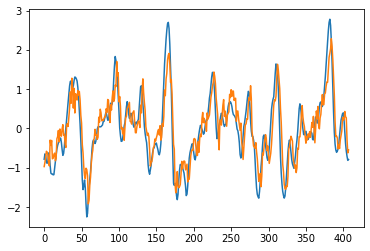

array([[1.        , 0.86274447],
       [0.86274447, 1.        ]])

In [19]:
_, val_stats,preddd,trr = evaluate(testloader,best_model_GNN, device=device,return_preds=True)
plt.plot(preddd[0:])
plt.plot(trr[0:])
plt.show()
np.corrcoef(preddd[0:400],trr[0:400])


In [14]:
def save_model(epochs, model, optimizer, criterion,strpath):
    """
    Function to save the trained model to disk.
    """
    print(f"Saving final model...")
    torch.save({
                'epoch': epochs,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': criterion,
                }, strpath)
    
    
save_model(20,best_model_GNN,optimizer,criterion,'/glade/work/wchapman/HeatGCN/Heater/saved_models/GNN_best.pth')
bb = torch.load('/glade/work/wchapman/HeatGCN/Heater/saved_models/GNN_best.pth')
model = GCN(net_params, static_feat=static_feats, adj=adj)
model.load_state_dict(bb['model_state_dict'])

NameError: name 'best_model_GNN' is not defined

In [15]:
class SaveBestModel:
    """
    Class to save the best model while training. If the current epoch's 
    validation loss is less than the previous least less, then save the
    model state.
    """
    def __init__(
        self, best_valid_loss=float('inf')
    ):
        self.best_valid_loss = best_valid_loss
        
    def __call__(
        self, current_valid_loss, 
        epoch, model, optimizer, criterion
    ):
        if current_valid_loss < self.best_valid_loss:
            self.best_valid_loss = current_valid_loss
            print(f"\nBest validation loss: {self.best_valid_loss}")
            print(f"\nSaving best model for epoch: {epoch+1}\n")
            torch.save({
                'epoch': epoch+1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': criterion,
                }, 'outputs/best_model.pth')

# Create a LIM:

In [19]:
from numpy.linalg import pinv, eigvals, eig, eigh

In [20]:
(adj, static_feats, _), (trainloader,valloader,testloader) = get_dataloaders(params, net_params)

/Users/wchapman/opt/miniconda3/envs/HeatTorch/lib/python3.7/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/Users/wchapman/opt/miniconda3/envs/HeatTorch/lib/python3.7/site-packages/numpy/core/_asarray.py:83: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)
/Users/wchapman/opt/miniconda3/envs/HeatTorch/lib/python3.7/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/Users/

MASKING OUT 7 nodes
Train set: 36132 Validation set 600 Test set 408


## Play with principal components

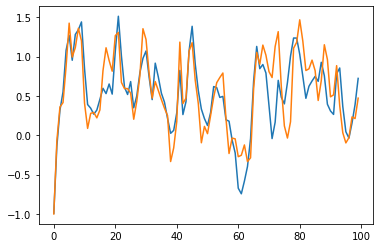

In [21]:
select_neofs = 20
A, Lh, E = torch.linalg.svd(torch.from_numpy(static_feats).T)
A = A[:, :len(Lh)] #trim the time field (in case time > space)
E = E[:len(Lh), :] #trim the space field (in case space > time)

# Remove the scaling on the principal component time-series that is
# implicitily introduced by using SVD instead of eigen-decomposition.
# The PCs may be re-scaled later if required.
PCs = A*Lh
# end 
remak = (PCs[:,:select_neofs]@E[:select_neofs,:].double()).T #reconstruct field by projecting PCS on EOFs
plt.plot(remak[20,:100])
plt.plot(static_feats[20,:100])
plt.show()

## Try project and reconstruct

Forecast in real space:  torch.Size([64, 189])


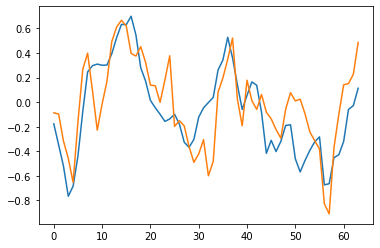

In [23]:
Forecast_inits = (torch.from_numpy(static_feats)[:,-64:]).T
print('Forecast in real space: ', Forecast_inits.shape)
proj_pcs = Forecast_inits@E[:select_neofs,:].T #project the dataset onto the EOFS using a matrix mult. 

remake_last = proj_pcs@E[:select_neofs,:] #project the dataset onto the EOFS using a matrix mult. 

plt.plot(remake_last[:,0])
plt.plot(Forecast_inits[:,0])
plt.show()

## Create Lim matrix with Principal Components 

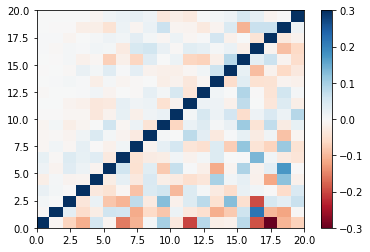

In [27]:
tlag=1
tau=1
tau0_data = (PCs[:,:select_neofs])
x0 = tau0_data[0:-tlag, :]
x1 = tau0_data[tlag:, :]

x0x0 = torch.mm(x0.T,x0)/PCs.shape[0]
x0x1 = torch.mm(x1.T,x0)/PCs.shape[0]
G_1 = torch.mm(x0x1, torch.linalg.pinv(x0x0))

Geigs = torch.linalg.eigvals(G_1)
Leigs = (1./tau) * torch.log(Geigs)

g = torch.linalg.matrix_power(G_1, tau)
plt.pcolor(G_1,vmin=-.3,vmax=.3,cmap='RdBu')
plt.colorbar()
plt.show()

## Forecast with PCS

In [28]:
t0_data = tau0_data
fcast_leads=[1,2,3,7]

if t0_data.ndim != 2:
    print(('LIM forecast data is not 2D '
                          '(Contained ndim={:d}').format(t0_data.ndim))
    raise ValueError('Input LIM forecast data is not 2D')
    
print(('Performing LIM forecast for tau values: '+ str(fcast_leads)))

num_fcast_times = len(fcast_leads)


# Create output locations for our forecasts
fcast_out_shp = (num_fcast_times, t0_data.shape[0], t0_data.shape[1])
fcast_out = np.zeros(fcast_out_shp)

for i, tau in enumerate(fcast_leads):
    g = np.linalg.matrix_power(G_1, tau)
    xf = np.dot(g, t0_data.T)
    fcast_out[i] = xf.T
    
fcast_realspace = (torch.from_numpy(fcast_out[-1,:,:])@E[:select_neofs,:]).T

Performing LIM forecast for tau values: [1, 2, 3, 7]


## Play with PCS

## Make Forecast

In [ ]:
t0_data = tau0_data
fcast_leads=[1,2,3,4,5,6,7,8,9,10]

if t0_data.ndim != 2:
    print(('LIM forecast data is not 2D '
                          '(Contained ndim={:d}').format(t0_data.ndim))
    raise ValueError('Input LIM forecast data is not 2D')
    
print(('Performing LIM forecast for tau values: '+ str(fcast_leads)))

num_fcast_times = len(fcast_leads)


# Create output locations for our forecasts
fcast_out_shp = (num_fcast_times, t0_data.shape[0], t0_data.shape[1])
fcast_out = np.zeros(fcast_out_shp)


for i, tau in enumerate(fcast_leads):
    g = np.linalg.matrix_power(G_1, tau)
    xf = np.dot(g, t0_data.T)
    fcast_out[i] = xf.T

## Torch

In [336]:
tau=1 #forecast 1 month
tlag=1
tau0_data = torch.from_numpy(static_feats.T)
x0 = tau0_data[0:-tlag, :]
x1 = tau0_data[tlag:, :]

x0x0 = torch.mm(x0.T,x0)
x0x1 = torch.mm(x1.T,x0)
G_1 = torch.mm(x0x1, torch.linalg.pinv(x0x0))

Geigs = torch.linalg.eigvals(G_1)
Leigs = (1./tau) * torch.log(Geigs)

g = torch.linalg.matrix_power(G_1, tau)
# xf = np.dot(g, t0_data.T)
# fcast_out[i] = xf.T

# if torch.any(Leigs.real >= 0):
#     logger.debug('L eigenvalues: \n' + str(Leigs))
#     raise ValueError('Positive eigenvalues detected in forecast matrix L.')
    
    
# t0_data = tau0_data
# fcast_leads=[1,2,3,4,5,6,7,8,9,10]
# num_fcast_times = len(fcast_leads)

# # Create output locations for our forecasts
# fcast_out_shp = (num_fcast_times, t0_data.shape[0], t0_data.shape[1])
# fcast_out = np.zeros(fcast_out_shp)


# for i, tau in enumerate(fcast_leads):
#     g = np.linalg.matrix_power(G_1, tau)
#     xf = np.dot(g, t0_data.T)
#     fcast_out[i] = xf.T

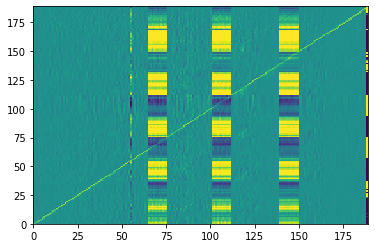

In [337]:
plt.pcolor(G_1,vmin=-1,vmax=1)

In [13]:
import torch
import torch.nn as nn

class TemporalEdgeStructureLearner(nn.Module):
    def __init__(self, num_nodes, max_num_edges, dim, static_feat, device='cuda', alpha1=0.1, alpha2=2.0,
                 self_loops=True):
        super().__init__()
        if static_feat is None:
            raise ValueError("Please give static node features (e.g. part of the timeseries)")
        self.num_nodes = num_nodes
        xd = static_feat.shape[1]
        tlag = 1
        x0=static_feat[0:-tlag, :]
        x1=static_feat[tlag:, :]
        
        xd = x0.shape[1]
        #covariance structrure
        self.lin1 = nn.Linear(xd, dim)
        self.lin2 = nn.Linear(xd, dim)
        
        self.linlag1 = nn.Linear(xd, dim)
        self.linlag2 = nn.Linear(xd, dim)
        
        
        self.static_feat = x0 if isinstance(x0, torch.Tensor) else torch.from_numpy(x0)
        self.static_feat = self.static_feat.float().to(device)
        
        #lagged feature
        self.static_feat1 = x1 if isinstance(x1, torch.Tensor) else torch.from_numpy(x1)
        self.static_feat1 = self.static_feat1.float().to(device)

        self.device = device
        self.dim = dim
        self.alpha1 = alpha1
        self.alpha2 = alpha2
        self.num_edges = max_num_edges
        self.self_loops = self_loops
        self.diag = torch.eye(self.num_nodes).bool().to(device)

    def forward(self):
        #covariance structure
        nodevec1 = torch.tanh(self.alpha1 * self.lin1(self.static_feat))
        nodevec2 = torch.tanh(self.alpha1 * self.lin2(self.static_feat))
        #adj = torch.sigmoid(self.alpha2 * nodevec1 @ nodevec2.T)
        
        #lagged covariance structure
        nodevec11 = torch.tanh(self.alpha1 * self.lin1(self.static_feat))
        nodevec21 = torch.tanh(self.alpha1 * self.lin2(self.static_feat1))
        #adj = torch.sigmoid(self.alpha2 * nodevec1 @ nodevec2.T)
        
        adj = torch.mm(torch.sigmoid(self.alpha2 * nodevec11 @ nodevec21.T),torch.linalg.pinv(torch.sigmoid(self.alpha2 * nodevec1 @ nodevec2.T)))
        
        
#         adj = adj.flatten()
#         mask = torch.zeros(self.num_nodes * self.num_nodes).to(self.device)
#         _, strongest_idxs = torch.topk(adj, self.num_edges)  # Adj to get the strongest weight value indices
#         mask[strongest_idxs] = 1
#         adj = adj * mask
#         adj = adj.reshape((self.num_nodes, self.num_nodes))
#         if self.self_loops:
#             adj[self.diag] = adj[self.diag].clamp(min=0.5)

        return adj


In [12]:
import torch
import torch.nn as nn

class EdgeStructureLearner(nn.Module):
    def __init__(self, num_nodes, max_num_edges, dim, static_feat, device='cuda', alpha1=0.1, alpha2=2.0,
                 self_loops=True):
        super().__init__()
        if static_feat is None:
            raise ValueError("Please give static node features (e.g. part of the timeseries)")
        self.num_nodes = num_nodes
        xd = static_feat.shape[1]
        self.lin1 = nn.Linear(xd, dim)
        self.lin2 = nn.Linear(xd, dim)
        self.static_feat = static_feat if isinstance(static_feat, torch.Tensor) else torch.from_numpy(static_feat)
        self.static_feat = self.static_feat.float().to(device)

        self.device = device
        self.dim = dim
        self.alpha1 = alpha1
        self.alpha2 = alpha2
        self.num_edges = max_num_edges
        self.self_loops = self_loops
        self.diag = torch.eye(self.num_nodes).bool().to(device)

    def forward(self):
        nodevec1 = torch.tanh(self.alpha1 * self.lin1(self.static_feat))
        nodevec2 = torch.tanh(self.alpha1 * self.lin2(self.static_feat))

        adj = torch.sigmoid(self.alpha2 * nodevec1 @ nodevec2.T)
        adj = adj.flatten()
        mask = torch.zeros(self.num_nodes * self.num_nodes).to(self.device)
        _, strongest_idxs = torch.topk(adj, self.num_edges)  # Adj to get the strongest weight value indices
        mask[strongest_idxs] = 1
        adj = adj * mask
        adj = adj.reshape((self.num_nodes, self.num_nodes))
        if self.self_loops:
            adj[self.diag] = adj[self.diag].clamp(min=0.5)

        return adj


In [55]:
tau0_data.shape

torch.Size([2402, 20])

In [39]:
tlag=1
x0 = tau0_data[0:-tlag, :]
x1 = tau0_data[tlag:, :]

## calc m ###
x0x0 = np.dot(x0.T,x0)
x0x1 = np.dot(x1.T,x0)
G_1 = np.dot(x0x1, pinv(x0x0))

# Calculate the forcing matrix to check that all modes are damped
tau=1
Geigs = eigvals(G_1)
Leigs = (1./tau) * np.log(Geigs)

if np.any(Leigs.real >= 0):
    logger.debug('L eigenvalues: \n' + str(Leigs))
    raise ValueError('Positive eigenvalues detected in forecast matrix L.')

## Check that all the modes are damped:

## Fit NOISE

In [30]:
max_neg_evals=5

C0 = x0.T @ x0 / (x0.shape[0] - 1)  # State covariance
G_eval, G_evects = eig(G_1)
L_evals = (1/tau) * np.log(G_eval)
L = G_evects @ np.diag(L_evals) @ pinv(G_evects)
L = np.matrix(L)
Q = -(L @ C0 + C0 @ L.H)  # Noise covariance

# Check if Q is Hermetian
is_adj = abs(Q - Q.H)
tol = 1e-10
if np.any(abs(is_adj) > tol):
    raise ValueError('Determined Q is not Hermetian (complex ''conjugate transpose is equivalent.)')
    
q_evals, q_evects = eigh(Q)
sort_idx = q_evals.argsort()
q_evals = q_evals[sort_idx][::-1]
q_evects = q_evects[:, sort_idx][:, ::-1]
num_neg = (q_evals < 0).sum()

if num_neg > 0:
    num_left = len(q_evals) - num_neg
    if num_neg > max_neg_evals:
        print('Found {:d} modes with negative eigenvalues in'
                             ' the noise covariance term, Q.'.format(num_neg))
        raise ValueError('More than {:d} negative eigenvalues of Q '
                                 'detected.  Consider further dimensional '
                                 'reduction.'.format(max_neg_evals))

    else:
        print('Removing negative eigenvalues and rescaling {:d} '
                            'remaining eigenvalues of Q.'.format(num_left))
        pos_q_evals = q_evals[q_evals > 0]
        scale_factor = q_evals.sum() / pos_q_evals.sum()
        print('Q eigenvalue rescaling: {:1.2f}'.format(scale_factor))

        q_evals = q_evals[:-num_neg]*scale_factor
        q_evects = q_evects[:, :-num_neg]
else:
    scale_factor = None
    
# Change back to arrays
L = np.array(L)
q_evects = np.array(q_evects)

## Make Forecast

In [117]:
t0_data = tau0_data
fcast_leads=[1,2,3,4,5,6,7,8,9,10]

if t0_data.ndim != 2:
    print(('LIM forecast data is not 2D '
                          '(Contained ndim={:d}').format(t0_data.ndim))
    raise ValueError('Input LIM forecast data is not 2D')
    
print(('Performing LIM forecast for tau values: '+ str(fcast_leads)))

num_fcast_times = len(fcast_leads)


# Create output locations for our forecasts
fcast_out_shp = (num_fcast_times, t0_data.shape[0], t0_data.shape[1])
fcast_out = np.zeros(fcast_out_shp)


for i, tau in enumerate(fcast_leads):
    g = np.linalg.matrix_power(G_1, tau)
    xf = np.dot(g, t0_data.T)
    fcast_out[i] = xf.T

Performing LIM forecast for tau values: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]


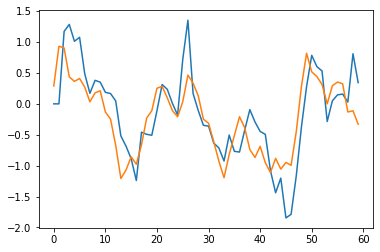

In [118]:
show_out=60
delt=4 #greater than 0
indy=104

plt.plot(np.arange(0,show_out),t0_data[:show_out,indy])
plt.plot(np.arange(0,show_out),fcast_out[delt-1,:show_out,indy])


In [ ]:
plt.plot(np.arange(0,show_out),fcast_out[0,:show_out,indy])
# plt.plot(np.arange(0,show_out),fcast_out[1,:show_out,indy])
# plt.plot(np.arange(0,show_out),fcast_out[2,:show_out,indy])
# plt.plot(np.arange(0,show_out),fcast_out[3,:show_out,indy])
# plt.plot(np.arange(0,show_out),fcast_out[4,:show_out,indy])
# plt.plot(np.arange(0,show_out),fcast_out[5,:show_out,indy])
plt.plot(np.arange(0,show_out),fcast_out[9,:show_out,indy])


## Noise Integration Forecast

In [24]:
"""Perform a stochastic noise forced integration.
Performs LIM forecast over the times specified by the
        fcast_times class attribute.  Forecast can be performed by calculating
        G for each time period or by L for a 1-year(or window_size) lag and
        then calculating each fcast_Time G from that L matrix.
        Parameters
        ----------
        t0_data: ndarray
            Initialization data for the stochastic integration.  Expects
            a 2D MxN matrix where M (rows) represent the ensemble dimension and
            N(columns) represents the feature dimension (e.g. spatial grid
            points).  The integration will produce a randomly forced trajectory
            for each ensemble member.
        length: int
            Length (in units of the calibration lag, tau) of the noise
            integration
        timesteps: int
            Number of timesteps in a single length-tau segment of the noise
            integration.  This parameter sets the deltaT for the timestepper.
            E.g., for tau=1-year, 1440 timesteps is ~6hr timestep.
        out_arr: Optional, ndarray
            Optional output container for data at the resolution of deltaT.
            Expected dimensions of (timesteps * length + 1) x N
        length_out_arr: Optional, ndarray
            Optianal output container for data at the resolution of tau.
            Expected dimensions of length x N
        seed: Optional, int
            Seed for the random number generator to perform a reproducible
            stochastic forecast
        Returns
        -----
        ndarray
            Final state of the LIM noise integration forecast. Same dimension
            as input t0_data.
"""

timesteps =20
seed=41
length = 1
if seed is not None:
     np.random.seed(seed)

# t0_data comes in as sample x spatial
L=L
Q_eval = q_evals[:, None]
Q_evec = q_evects
tdelta = 1/timesteps
integration_steps = int(timesteps * length)
num_evals = Q_eval.shape[0]
nens = t0_data.shape[0]

state_1 = t0_data.T
state_mid = state_1

if out_arr is not None:
    out_arr[0] = t0_data
    

for i in range(integration_steps):
    deterministic = (L @ state_1) * tdelta
    random = np.random.normal(size=(num_evals, nens))
    stochastic = Q_evec @ (np.sqrt(Q_eval * tdelta) * random)
    state_2 = state_1 + deterministic + stochastic
    state_mid = (state_1 + state_2) / 2
    state_1 = state_2
    
    if out_arr is not None:
        out_arr[i + 1] = state_mid.T
        
    if length_out_arr is not None and i % timesteps == 0 and i != 0:
        len_out_arr_idx = i // timesteps
        length_out_arr[len_out_arr_idx] = state_mid.T
    

## nLIM

## params

In [40]:
import torch
import torch.nn as nn
torch.manual_seed(0)
import random
random.seed(0)

class LIMG(nn.Module):
    def __init__(self, num_nodes, max_num_edges, dim, static_feat, device='cuda', alpha1=0.1, alpha2=2.0,
                 self_loops=True):
        super().__init__()
        if static_feat is None:
            raise ValueError("Please give static node features (e.g. part of the timeseries)")
        self.num_nodes = num_nodes
        xd = static_feat.shape[1]
        tlag = 1
        x0=static_feat[:,0:-tlag]
        x1=static_feat[:,tlag:]
        
        xd = x0.shape[1]
        #covariance structrure
        self.lin1 = nn.Linear(xd, dim)
        self.lin2 = nn.Linear(xd, dim)
        self.linlag1 = nn.Linear(xd, dim)
        self.linlag2 = nn.Linear(xd, dim)
        
        self.static_feat = x0 if isinstance(x0, torch.Tensor) else torch.from_numpy(x0)
        self.static_feat = self.static_feat.to(torch.float64).to(device)
        
        #lagged feature
        self.static_feat1 = x1 if isinstance(x1, torch.Tensor) else torch.from_numpy(x1)
        self.static_feat1 = self.static_feat1.to(torch.float64).to(device)

        self.device = device
        self.dim = dim
        self.alpha1 = alpha1
        self.alpha2 = alpha2
        self.num_edges = max_num_edges
        self.self_loops = self_loops
        self.diag = torch.eye(self.num_nodes).bool().to(device)

    def forward(self):
        #covariance structure
        nodevec1 = self.static_feat
        nodevec2 = self.static_feat      
        #lagged covariance structure
        nodevec11 = self.static_feat
        nodevec21 = self.static_feat1
        
        adj = (nodevec21 @ nodevec11.T)@(torch.linalg.pinv(nodevec1 @ nodevec1.T))
        
#         adj = adj.flatten()
#         mask = torch.zeros(self.num_nodes * self.num_nodes).to(self.device)
#         _, strongest_idxs = torch.topk(adj, self.num_edges)  # Adj to get the strongest weight value indices
#         mask[strongest_idxs] = 1
#         adj = adj * mask
#         adj = adj.reshape((self.num_nodes, self.num_nodes))
#         if self.self_loops:
#             adj[self.diag] = adj[self.diag].clamp(min=0.5)

        return adj




class EdgeStructureLearner(nn.Module):
    def __init__(self, num_nodes, max_num_edges, dim, static_feat, device='cuda', alpha1=0.1, alpha2=2.0,
                 self_loops=True):
        super().__init__()
        if static_feat is None:
            raise ValueError("Please give static node features (e.g. part of the timeseries)")
        self.num_nodes = num_nodes
        xd = static_feat.shape[1]
        self.lin1 = nn.Linear(xd, dim)
        self.lin2 = nn.Linear(xd, dim)
        self.static_feat = static_feat if isinstance(static_feat, torch.Tensor) else torch.from_numpy(static_feat)
        self.static_feat = self.static_feat.float().to(device)

        self.device = device
        self.dim = dim
        self.alpha1 = alpha1
        self.alpha2 = alpha2
        self.num_edges = max_num_edges
        self.self_loops = self_loops
        self.diag = torch.eye(self.num_nodes).bool().to(device)

    def forward(self):
        nodevec1 = torch.tanh(self.alpha1 * self.lin1(self.static_feat))
        nodevec2 = torch.tanh(self.alpha1 * self.lin2(self.static_feat))

        adj = torch.sigmoid(self.alpha2 * nodevec1 @ nodevec2.T)
        adj = adj.flatten()
        mask = torch.zeros(self.num_nodes * self.num_nodes).to(self.device)
        _, strongest_idxs = torch.topk(adj, self.num_edges)  # Adj to get the strongest weight value indices
        mask[strongest_idxs] = 1
        adj = adj * mask
        adj = adj.reshape((self.num_nodes, self.num_nodes))
        if self.self_loops:
            adj[self.diag] = adj[self.diag].clamp(min=0.5)

        return adj



class nonLIMG(nn.Module):
    def __init__(self, num_nodes, max_num_edges, dim, static_feat, device='cuda', alpha1=0.1, alpha2=2.0,
                 self_loops=True):
        super().__init__()
        if static_feat is None:
            raise ValueError("Please give static node features (e.g. part of the timeseries)")
        self.num_nodes = num_nodes
        xd = static_feat.shape[1]
        tlag = 1
        x0=static_feat[:,0:-tlag]
        x1=static_feat[:,tlag:]
        
        xd = x0.shape[1]
        #covariance structrure
        self.lin1 = nn.Linear(xd, dim)
        self.lin2 = nn.Linear(xd, dim)
        self.linlag1 = nn.Linear(xd, dim)
        self.linlag2 = nn.Linear(xd, dim)
        
        self.static_feat = x0 if isinstance(x0, torch.Tensor) else torch.from_numpy(x0)
        self.static_feat = self.static_feat.to(torch.float64).to(device)
        
        #lagged feature
        self.static_feat1 = x1 if isinstance(x1, torch.Tensor) else torch.from_numpy(x1)
        self.static_feat1 = self.static_feat1.to(torch.float64).to(device)

        self.device = device
        self.dim = dim
        self.alpha1 = alpha1
        self.alpha2 = alpha2
        self.num_edges = max_num_edges
        self.self_loops = self_loops
        self.diag = torch.eye(self.num_nodes).bool().to(device)

    def forward(self):
        #covariance structure
        nodevec1 = self.lin1(self.static_feat.to(torch.float32).to(device))
        nodevec2 = self.lin2(self.static_feat.to(torch.float32).to(device))    
        #lagged covariance structure
        nodevec11 = self.linlag1(self.static_feat.to(torch.float32).to(device))
        nodevec21 = self.linlag2(self.static_feat.to(torch.float32).to(device))
        
        adj = (nodevec21 @ nodevec11.T)@(torch.linalg.pinv(nodevec1 @ nodevec1.T))
        
#         adj = adj.flatten()
#         mask = torch.zeros(self.num_nodes * self.num_nodes).to(self.device)
#         _, strongest_idxs = torch.topk(adj, self.num_edges)  # Adj to get the strongest weight value indices
#         mask[strongest_idxs] = 1
#         adj = adj * mask
#         adj = adj.reshape((self.num_nodes, self.num_nodes))
#         if self.self_loops:
#             adj[self.diag] = adj[self.diag].clamp(min=0.5)

        return adj

class LIM_MLP(nn.Module):
    """
    Fully connected MLP on top of node embeddings
    L - number of hidden layers, each of those having half the number of neurons than the previous one.
    """
    def __init__(self, input_dim, output_dim, dropout=0, L=2, batch_norm=True, act_func='elu', device='cuda'):
        super().__init__()
        FC_layers = []
        for l in range(L):
            out_dim_l = input_dim // 2 ** (l + 1)
            FC_layers.append(
                nn.Linear(input_dim // 2 ** l, out_dim_l, bias=True,device=device)
            )
            if batch_norm:
                FC_layers.append(nn.BatchNorm1d(out_dim_l,device=device))
            FC_layers.append(get_activation_function(act_func, device=device))
            if dropout > 0:
                FC_layers.append(nn.Dropout(dropout))

        self.FC_layers = nn.ModuleList(FC_layers)
        self.out_dim_last_L = input_dim // 2 ** L
        self.out_layer = nn.Linear(self.out_dim_last_L, output_dim, bias=True,device=device)
        self.L = L

    def forward(self, x):
        x=x.to(torch.float32)
        for module in self.FC_layers:
            x = module(x.to(torch.float32))
        y = self.out_layer(x)
        return y

In [41]:
import torch
import torch.nn as nn
# from graphino.readout_MLP import ONI_MLP
# from graphino.GCN.graph_conv_layer import GraphConvolution
# from graphino.structure_learner import EdgeStructureLearner
# from utilities.utils import get_activation_function

class nlim(nn.Module):
    def __init__(self, net_params,params, static_feat=None, adj=None, device="cuda:0", outsize=1, verbose=True):
        super().__init__()
        self.L = net_params['L']
        assert self.L > 1
        self.act = net_params['activation']
        self.out_dim = self.mlp_input_dim = net_params['out_dim']
        self.batch_norm = net_params['batch_norm']
        self.graph_pooling = net_params['readout'].lower()
        self.jumping_knowledge = net_params['jumping_knowledge']
        self.tau = params['horizon']
        self.device=device
        dropout = net_params['dropout']
        hid_dim = net_params['hidden_dim']
        num_nodes = net_params['num_nodes']
        activation = get_activation_function(self.act, functional=True, num=1, device=device)
        conv_kwargs = {'activation': activation, 'batch_norm': self.batch_norm,
                       'residual': net_params['residual'], 'dropout': dropout}
        
        
        layers = [GraphConvolution(net_params['in_dim'], hid_dim, **conv_kwargs)]
        layers += [GraphConvolution(hid_dim, hid_dim, **conv_kwargs) for _ in range(self.L - 2)]
        layers.append(GraphConvolution(hid_dim, self.out_dim, **conv_kwargs))
        
        self.layers = nn.ModuleList(layers)
        
        if self.jumping_knowledge:
            self.mlp_input_dim = self.mlp_input_dim + hid_dim * (self.L - 1)
        if self.graph_pooling in ['sum+mean', 'mean+sum', 'mean&sum', 'sum&mean']:
            self.mlp_input_dim = self.mlp_input_dim * 2
        self.MLP_layer = LIM_MLP(static_feats.shape[0], outsize, act_func=self.act, batch_norm=net_params['mlp_batch_norm'],
                                    dropout=dropout, device=device,L=3)
        if adj is None:
            self.adj, self.learn_adj = None, True
            max_num_edges = int(net_params['avg_edges_per_node'] * num_nodes)
            self.LIM_learner = LIMG(50,50,50,device=device, static_feat=static_feat)
        else:
            print('Using a static connectivity structure !!!')
            self.adj, self.learn_adj = torch.from_numpy(adj).float().to(device), False

        if verbose:
            print([x for x in self.layers])

    def get_adj(self):
        if self.learn_adj:
            return self.LIM_learner.forward()
        return self.adj


    def forward(self, input, readout=True):
        if self.learn_adj:
            # Generate an adjacency matrix/connectivity structure for the graph convolutional forward pass
            self.adj = self.LIM_learner.forward()
            self.Gpow = torch.linalg.matrix_power(self.adj, self.tau)
            self.xfor = torch.mm(input[:,0,2,:].to(torch.float64).to(self.device),self.Gpow.T)
            out = self.MLP_layer(self.xfor.float())
            
#         # GCN forward pass --> Generate node embeddings
#         node_embs = self.layers[0](input, self.adj)  # shape (batch-size, #nodes, #features)
#         X_all_embeddings = node_embs.clone()
#         for conv in self.layers[1:]:
#             node_embs = conv(node_embs, self.adj)
#             if self.jumping_knowledge:
#                 X_all_embeddings = torch.cat((X_all_embeddings, node_embs), dim=2)
#         final_embs = X_all_embeddings if self.jumping_knowledge else node_embs

#         # Graph pooling, e.g. take the mean over all node embeddings (dimension=1)
#         if self.graph_pooling == 'sum':
#             g_emb = torch.sum(final_embs, dim=1)
#         elif self.graph_pooling == 'mean':
#             g_emb = torch.mean(final_embs, dim=1)
#         elif self.graph_pooling == 'max':
#             g_emb, _ = torch.max(final_embs, dim=1)  # returns (values, indices)
#         elif self.graph_pooling in ['sum+mean', 'mean+sum', 'mean&sum', 'sum&mean']:
#             xmean = torch.mean(final_embs, dim=1)
#             xsum = torch.sum(final_embs, dim=1)  # (batch-size, out-dim)
#             g_emb = torch.cat((xmean, xsum), dim=1)  # (batch-size 2*out-dim)
#         else:
#             raise ValueError('Unsupported readout operation')

#         # After graph pooling: (batch-size, out-dim)
#         out = self.graph_embedding_to_pred(g_emb=g_emb) if readout else g_emb
        return  out

#     def graph_embedding_to_pred(self, g_emb):
#         out = self.MLP_layer.forward(g_emb).squeeze(1)
#         return out


In [42]:
def train_epoch_LIM(dataloader, model, criterion, optims, device, epoch, nth_step=100):
    if not isinstance(optims, list):
        optims = [optims]
    model.train()
    total_loss = 0
    for iter, (X, Y) in enumerate(dataloader, 1):
        X, Y = X.to(device), Y.to(device)
        Y=Y.unsqueeze(dim=1)
        for optim in optims:
            optim.zero_grad()        
#         X = X.reshape((X.shape[0], -1, X.shape[3])).transpose(1, 2)  # shape = (batch_size x #features x #nodes)
        preds = model(X)
        loss = criterion(preds, Y)
        loss.backward()
        
        for optim in optims:
            optim.step()
        total_loss += loss.item()
    num_edges = torch.count_nonzero(model.adj.detach()).item()
    return total_loss / iter, num_edges



def train_epoch(dataloader, model, criterion, optims, device, epoch, nth_step=100):
    if not isinstance(optims, list):
        optims = [optims]
    model.train()
    total_loss = 0
    for iter, (X, Y) in enumerate(dataloader, 1):
        X, Y = X.to(device), Y.to(device)
        for optim in optims:
            optim.zero_grad()
        X = X.reshape((X.shape[0], -1, X.shape[3])).transpose(1, 2)  # shape = (batch_size x #features x #nodes)

        preds = model(X)
        loss = criterion(preds, Y)
        loss.backward()
        
        for optim in optims:
            optim.step()
        total_loss += loss.item()
    num_edges = torch.count_nonzero(model.adj.detach()).item()
    return total_loss / iter, num_edges



# All in One

In [1591]:
import torch
import torch.nn as nn
# from graphino.readout_MLP import ONI_MLP
# from graphino.GCN.graph_conv_layer import GraphConvolution
# from graphino.structure_learner import EdgeStructureLearner
# from utilities.utils import get_activation_function
class nlim(nn.Module):
    def __init__(self, net_params,params, static_feat=None, adj=None, device="cpu", outsize=1, verbose=True):
        super().__init__()
        self.L = net_params['L']
        assert self.L > 1
        self.act = net_params['activation']
        self.out_dim = self.mlp_input_dim = net_params['out_dim']
        self.batch_norm = net_params['batch_norm']
        self.graph_pooling = net_params['readout'].lower()
        self.jumping_knowledge = net_params['jumping_knowledge']
        self.tau = params['horizon']
        self.device=device
        self.numpreds = static_feats.shape[0]
        self.Gbias = nn.Parameter(torch.rand(self.numpreds,self.numpreds),requires_grad=True)
        dropout = net_params['dropout']
        hid_dim = net_params['hidden_dim']
        num_nodes = net_params['num_nodes']
        activation = get_activation_function(self.act, functional=True, num=1, device=device)
        conv_kwargs = {'activation': activation, 'batch_norm': self.batch_norm,
                       'residual': net_params['residual'], 'dropout': dropout}
        
        
        layers = [GraphConvolution(net_params['in_dim'], hid_dim, **conv_kwargs)]
        layers += [GraphConvolution(hid_dim, hid_dim, **conv_kwargs) for _ in range(self.L - 2)]
        layers.append(GraphConvolution(hid_dim, self.out_dim, **conv_kwargs))
        
        self.layers = nn.ModuleList(layers)
        
        if self.jumping_knowledge:
            self.mlp_input_dim = self.mlp_input_dim + hid_dim * (self.L - 1)
        if self.graph_pooling in ['sum+mean', 'mean+sum', 'mean&sum', 'sum&mean']:
            self.mlp_input_dim = self.mlp_input_dim * 2
        self.MLP_layer = LIM_MLP(static_feats.shape[0], outsize, act_func=self.act, batch_norm=net_params['mlp_batch_norm'],
                                    dropout=dropout, device=device,L=3)
        if adj is None:
            self.adj, self.learn_adj = None, True
            max_num_edges = int(net_params['avg_edges_per_node'] * num_nodes)
            self.LIM_learner = LIMG(50,50,50,device=device, static_feat=static_feat)
        else:
            print('Using a static connectivity structure !!!')
            self.adj, self.learn_adj = torch.from_numpy(adj).float().to(device), False

        if verbose:
            print([x for x in self.layers])

    def get_adj(self):
        if self.learn_adj:
            return self.LIM_learner.forward()
        return self.adj


    def forward(self, input, readout=True):
        
        if self.learn_adj:
            # Generate an adjacency matrix/connectivity structure for the graph convolutional forward pass
            self.adj = self.LIM_learner.forward()
            self.Q = self.LIM_learner.NoiseQ()
            self.Gpow = torch.linalg.matrix_power(self.adj, self.tau)
            self.Gpow = self.Gpow #+ self.Gbias
            
            Forecast_inits =torch.cat((input[:,0,-1,:].to(torch.float64).to(self.device),input[:,1,-1,:].to(torch.float64).to(self.device)),1)
            self.xfor = torch.mm(Forecast_inits.to(torch.float64).to(self.device),self.Gpow.T)
            out = self.MLP_layer(self.xfor.float())
            
#         # GCN forward pass --> Generate node embeddings
#         node_embs = self.layers[0](input, self.adj)  # shape (batch-size, #nodes, #features)
#         X_all_embeddings = node_embs.clone()
#         for conv in self.layers[1:]:
#             node_embs = conv(node_embs, self.adj)
#             if self.jumping_knowledge:
#                 X_all_embeddings = torch.cat((X_all_embeddings, node_embs), dim=2)
#         final_embs = X_all_embeddings if self.jumping_knowledge else node_embs

#         # Graph pooling, e.g. take the mean over all node embeddings (dimension=1)
#         if self.graph_pooling == 'sum':
#             g_emb = torch.sum(final_embs, dim=1)
#         elif self.graph_pooling == 'mean':
#             g_emb = torch.mean(final_embs, dim=1)
#         elif self.graph_pooling == 'max':
#             g_emb, _ = torch.max(final_embs, dim=1)  # returns (values, indices)
#         elif self.graph_pooling in ['sum+mean', 'mean+sum', 'mean&sum', 'sum&mean']:
#             xmean = torch.mean(final_embs, dim=1)
#             xsum = torch.sum(final_embs, dim=1)  # (batch-size, out-dim)
#             g_emb = torch.cat((xmean, xsum), dim=1)  # (batch-size 2*out-dim)
#         else:
#             raise ValueError('Unsupported readout operation')

#         # After graph pooling: (batch-size, out-dim)
#         out = self.graph_embedding_to_pred(g_emb=g_emb) if readout else g_emb
        return  out

#     def graph_embedding_to_pred(self, g_emb):
#         out = self.MLP_layer.forward(g_emb).squeeze(1)
#         return out


import torch
import torch.nn as nn
torch.manual_seed(0)
import random
random.seed(0)

class LIMG(nn.Module):
    def __init__(self, num_nodes, max_num_edges, dim, static_feat, device='cpu', alpha1=0.1, alpha2=2.0,
                 self_loops=True):
        super().__init__()
        if static_feat is None:
            raise ValueError("Please give static node features (e.g. part of the timeseries)")
        self.num_nodes = num_nodes
        xd = static_feat.shape[1]
        tlag = 1
        self.tlag = tlag
        x0=static_feat[:,0:-tlag]
        x1=static_feat[:,tlag:]
        
        xd = x0.shape[1]
        #covariance structrure
        self.lin1 = nn.Linear(xd, dim)
        self.lin2 = nn.Linear(xd, dim)
        self.linlag1 = nn.Linear(xd, dim)
        self.linlag2 = nn.Linear(xd, dim)
        
        self.static_feat = x0 if isinstance(x0, torch.Tensor) else torch.from_numpy(x0)
        self.static_feat = self.static_feat.to(torch.float64).to(device)
        
        #lagged feature
        self.static_feat1 = x1 if isinstance(x1, torch.Tensor) else torch.from_numpy(x1)
        self.static_feat1 = self.static_feat1.to(torch.float64).to(device)

        self.device = device
        self.dim = dim
        self.alpha1 = alpha1
        self.alpha2 = alpha2
        self.num_edges = max_num_edges
        self.self_loops = self_loops
        self.diag = torch.eye(self.num_nodes).bool().to(device)

    def forward(self):
        #covariance structure
        nodevec1 = self.static_feat
        nodevec2 = self.static_feat      
        #lagged covariance structure
        nodevec11 = self.static_feat
        nodevec21 = self.static_feat1
        
        adj = (nodevec21 @ nodevec11.T)@(torch.linalg.pinv(nodevec1 @ nodevec1.T))
        
        return adj

    def NoiseQ(self):
        #covariance structure
        nodevec1 = self.static_feat
        nodevec2 = self.static_feat      
        #lagged covariance structure
        nodevec11 = self.static_feat
        nodevec21 = self.static_feat1
        G_1 = (nodevec21 @ nodevec11.T)@(torch.linalg.pinv(nodevec1 @ nodevec1.T))
        G_1=G_1.cpu().detach().numpy()    
        x0_c = self.static_feat.cpu().detach().numpy().T  

        C0 = x0_c.T @ x0_c / (x0_c.shape[0] - 1) 

        G_eval, G_evects = np.linalg.eig(G_1)
        L_evals = (1/tau) * np.log(G_eval)
        L = G_evects @ np.diag(L_evals) @ np.linalg.pinv(G_evects)
        L = np.matrix(L)
        Q = -(L @ C0 + C0 @ L.H)  # Noise covariance
        Q=torch.from_numpy(Q)
        return Q,L,G_eval




class EdgeStructureLearner(nn.Module):
    def __init__(self, num_nodes, max_num_edges, dim, static_feat, device='cpu', alpha1=0.1, alpha2=2.0,
                 self_loops=True):
        super().__init__()
        if static_feat is None:
            raise ValueError("Please give static node features (e.g. part of the timeseries)")
        self.num_nodes = num_nodes
        xd = static_feat.shape[1]
        self.lin1 = nn.Linear(xd, dim)
        self.lin2 = nn.Linear(xd, dim)
        self.static_feat = static_feat if isinstance(static_feat, torch.Tensor) else torch.from_numpy(static_feat)
        self.static_feat = self.static_feat.float().to(device)

        self.device = device
        self.dim = dim
        self.alpha1 = alpha1
        self.alpha2 = alpha2
        self.num_edges = max_num_edges
        self.self_loops = self_loops
        self.diag = torch.eye(self.num_nodes).bool().to(device)

    def forward(self):
        nodevec1 = torch.tanh(self.alpha1 * self.lin1(self.static_feat))
        nodevec2 = torch.tanh(self.alpha1 * self.lin2(self.static_feat))

        adj = torch.sigmoid(self.alpha2 * nodevec1 @ nodevec2.T)
        adj = adj.flatten()
        mask = torch.zeros(self.num_nodes * self.num_nodes).to(self.device)
        _, strongest_idxs = torch.topk(adj, self.num_edges)  # Adj to get the strongest weight value indices
        mask[strongest_idxs] = 1
        adj = adj * mask
        adj = adj.reshape((self.num_nodes, self.num_nodes))
        if self.self_loops:
            adj[self.diag] = adj[self.diag].clamp(min=0.5)
        return adj



class nonLIMG(nn.Module):
    def __init__(self, num_nodes, max_num_edges, dim, static_feat, device='cpu', alpha1=0.1, alpha2=2.0,
                 self_loops=True):
        super().__init__()
        if static_feat is None:
            raise ValueError("Please give static node features (e.g. part of the timeseries)")
        self.num_nodes = num_nodes
        xd = static_feat.shape[1]
        tlag = 1
        x0=static_feat[:,0:-tlag]
        x1=static_feat[:,tlag:]
        
        xd = x0.shape[1]
        #covariance structrure
        self.lin1 = nn.Linear(xd, dim)
        self.lin2 = nn.Linear(xd, dim)
        self.linlag1 = nn.Linear(xd, dim)
        self.linlag2 = nn.Linear(xd, dim)
        
        self.static_feat = x0 if isinstance(x0, torch.Tensor) else torch.from_numpy(x0)
        self.static_feat = self.static_feat.to(torch.float64).to(device)
        
        #lagged feature
        self.static_feat1 = x1 if isinstance(x1, torch.Tensor) else torch.from_numpy(x1)
        self.static_feat1 = self.static_feat1.to(torch.float64).to(device)

        self.device = device
        self.dim = dim
        self.alpha1 = alpha1
        self.alpha2 = alpha2
        self.num_edges = max_num_edges
        self.self_loops = self_loops
        self.diag = torch.eye(self.num_nodes).bool().to(device)

    def forward(self):
        #covariance structure
        nodevec1 = self.lin1(self.static_feat.to(torch.float32).to(device))
        nodevec2 = self.lin2(self.static_feat.to(torch.float32).to(device))    
        #lagged covariance structure
        nodevec11 = self.linlag1(self.static_feat.to(torch.float32).to(device))
        nodevec21 = self.linlag2(self.static_feat1.to(torch.float32).to(device))
        
        adj = (nodevec21 @ nodevec11.T)@(torch.linalg.pinv(nodevec1 @ nodevec1.T))

        return adj

class LIM_MLP(nn.Module):
    """
    Fully connected MLP on top of node embeddings
    L - number of hidden layers, each of those having half the number of neurons than the previous one.
    """
    def __init__(self, input_dim, output_dim, dropout=0, L=2, batch_norm=True, act_func='elu', device='cpu'):
        super().__init__()
        FC_layers = []
        for l in range(L):
            out_dim_l = input_dim // 2 ** (l + 1)
            FC_layers.append(
                nn.Linear(input_dim // 2 ** l, out_dim_l, bias=True,device=device)
            )
            if batch_norm:
                FC_layers.append(nn.BatchNorm1d(out_dim_l,device=device))
            FC_layers.append(get_activation_function(act_func, device=device))
            if dropout > 0:
                FC_layers.append(nn.Dropout(dropout))

        self.FC_layers = nn.ModuleList(FC_layers)
        self.out_dim_last_L = input_dim // 2 ** L
        self.out_layer = nn.Linear(self.out_dim_last_L, output_dim, bias=True,device=device)
        self.L = L

    def forward(self, x):
        x=x.to(torch.float32)
        for module in self.FC_layers:
            x = module(x.to(torch.float32))
        y = self.out_layer(x)
        return y


def train_epoch_LIM(dataloader, model, criterion, optims, device, epoch, nth_step=100):
    if not isinstance(optims, list):
        optims = [optims]
    model.train()
    total_loss = 0
    for iter, (X, Y) in enumerate(dataloader, 1):
        X, Y = X.to(device), Y.to(device)
        Y=Y.unsqueeze(dim=1)
        for optim in optims:
            optim.zero_grad()        
#         X = X.reshape((X.shape[0], -1, X.shape[3])).transpose(1, 2)  # shape = (batch_size x #features x #nodes)
        preds = model(X)
        loss = criterion(preds, Y)
        loss.backward()
        
        for optim in optims:
            optim.step()
        total_loss += loss.item()
    num_edges = torch.count_nonzero(model.adj.detach()).item()
    return total_loss / iter, num_edges



def train_epoch(dataloader, model, criterion, optims, device, epoch, nth_step=100):
    if not isinstance(optims, list):
        optims = [optims]
    model.train()
    total_loss = 0
    for iter, (X, Y) in enumerate(dataloader, 1):
        X, Y = X.to(device), Y.to(device)
        for optim in optims:
            optim.zero_grad()
        X = X.reshape((X.shape[0], -1, X.shape[3])).transpose(1, 2)  # shape = (batch_size x #features x #nodes)

        preds = model(X)
        loss = criterion(preds, Y)
        loss.backward()
        
        for optim in optims:
            optim.step()
        total_loss += loss.item()
    num_edges = torch.count_nonzero(model.adj.detach()).item()
    return total_loss / iter, num_edges

# Set Params # Set Params # Set Params # Set Params # Set Params # Set Params
# Set Params # Set Params # Set Params # Set Params # Set Params # Set Params
# Set Params # Set Params # Set Params # Set Params # Set Params # Set Params
# Set Params # Set Params # Set Params # Set Params # Set Params # Set Params

net_params ={'L': 2, 
         'num_nodes': 189, 
         'readout': 'mean', 
         'activation': 'ELU',
         'avg_edges_per_node': 8,
         'in_dim': 6,
         'adj_dim': 50,
         'jumping_knowledge': True, 
         'index_node': False, 
         'batch_norm': True, 
         'mlp_batch_norm': True, 
         'residual': True, 
         'self_loop': True, 
         'tanh_alpha': 0.1, 
         'sig_alpha': 2.0, 
         'dropout': 0.0,
         'hidden_dim': 250,
         'out_dim': 100}


params = {'horizon': 3,
 'window': 3,
 'lon_min': 180,
 'lon_max': 270,
 'lat_min': -10,
 'lat_max': 10,
 'model_dir': 'out/graphino/',
 'data_dir': 'Data//',
 'useCMIP5': True,
 'use_heat_content': True,
 'seed': 41,
 'shuffle': True,
 'epochs': 15,
 'batch_size': 64,
 'lr': 0.005,
 'nesterov': True,
 'weight_decay': 1e-06,
 'validation_frac': 0,
 'validation_set': 'cmip5',
 'loss': 'MSE',
 'optimizer': 'adam',
 'scheduler': 'No',
 'grid_edges': False}


(adj, static_feats, _), (trainloader,valloader,testloader) = get_dataloaders(params, net_params)
static_feats = static_feats[:,2:]
static_feats = np.concatenate([static_feats[:,:int(static_feats.shape[1]/2)],static_feats[:,int(static_feats.shape[1]/2):]])
print('...fix static feats...')
badsmall = np.where(np.max(np.abs(static_feats),axis=1)<0.8)[0]
for bdsmll in badsmall:
    static_feats[bdsmll,:]=np.random.normal(0,.1,static_feats.shape[1])


model = nlim(net_params, params,static_feat=static_feats, adj=adj)
optimizer = get_optimizer(params['optimizer'], model, lr=params['lr'],weight_decay=params['weight_decay'], nesterov=params['nesterov'])
criterion = get_loss(params['loss'])

# Train model# Train model# Train model# Train model# Train model# Train model
# Train model# Train model# Train model# Train model# Train model# Train model
# Train model# Train model# Train model# Train model# Train model# Train model
# Train model# Train model# Train model# Train model# Train model# Train model


t_total = time.time()
device="cpu"
model = model.to(device)
val_stats = None
best_val_loss = cur_val = 1000

with tqdm(range(1, params['epochs'] + 1)) as t:
    for epoch in t:
        start_t = time.time()
        loss, num_edges = train_epoch_LIM(trainloader, model, criterion, optimizer, device, epoch)
        duration = time.time() - start_t
        if valloader is not None:
            # Note that the default 'validation set' is included in the training set (=SODA),
            # and is not used at all.
            _, val_stats = evaluate_LIM(valloader, model, device=device)
            _, train_stats = evaluate_LIM(trainloader, model, device=device)
            print('validation: ',val_stats)
            print('train: ',train_stats)
            
        update_tqdm(t, loss, n_edges=num_edges, time=duration, val_stats=val_stats)
        #save the best model....
        if epoch == 1:
            best_accuracy = val_stats['corrcoef']
            best_model_lim = copy.deepcopy(model)
        else:
            print(epoch)
            if best_accuracy > val_stats['corrcoef']:
                continue
            else:
                print('new best')
                best_accuracy = val_stats['corrcoef']
                best_model_lim = copy.deepcopy(model)

/Users/wchapman/opt/miniconda3/envs/HeatTorch/lib/python3.7/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/Users/wchapman/opt/miniconda3/envs/HeatTorch/lib/python3.7/site-packages/numpy/core/_asarray.py:83: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)
/Users/wchapman/opt/miniconda3/envs/HeatTorch/lib/python3.7/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/Users/

Train set: 36132 Validation set 600 Test set 408
...fix static feats...
[GraphConvolution (6 -> 250), GraphConvolution (250 -> 100)]
Using Adam optimizer: Lr= 0.005 Wd= 1e-06


  0%|                                                                                                                                                                                                    | 0/15 [00:04<?, ?it/s]


KeyboardInterrupt: 

## Test the LIM

In [1592]:
load_data_kwargs = {
        'window': params['window'], 'lead_months': params['horizon'], 'lon_min': params['lon_min'],
        'lon_max': params['lon_max'], 'lat_min': params['lat_min'], 'lat_max': params['lat_max'],
        'data_dir': params['data_dir'], 'use_heat_content': params['use_heat_content'],
        'add_index_node': net_params['index_node']
    }
cmip5, SODA, GODAS, cords, cnn_mask = load_cnn_data(**load_data_kwargs, return_new_coordinates=True, return_mask=True)
dinny = np.zeros(cnn_mask[:-1].shape)*np.nan
# dinny[cnn_mask[:-1]] = best_model_lim.LIM_learner.eofs[0,:-1]

lats=np.unique(SODA[0].lat)
lons=np.unique(SODA[0].lon)



/Users/wchapman/opt/miniconda3/envs/HeatTorch/lib/python3.7/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/Users/wchapman/opt/miniconda3/envs/HeatTorch/lib/python3.7/site-packages/numpy/core/_asarray.py:83: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)
/Users/wchapman/opt/miniconda3/envs/HeatTorch/lib/python3.7/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/Users/

torch.Size([64, 190])


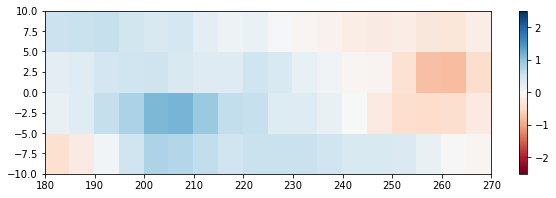

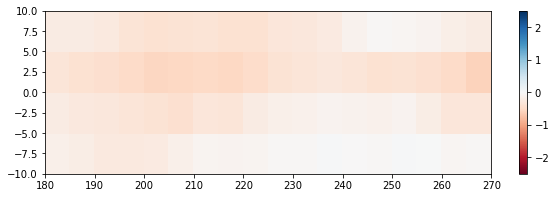

In [1595]:
Gpow = torch.linalg.matrix_power(LIMER.forward(), 8)
inbaby = iter(valloader).next()[0]
Forecast_inits =torch.cat((inbaby[:,0,-1,:].to(torch.float64).to('cpu'),inbaby[:,1,-1,:].to(torch.float64).to('cpu')),1)
fcast = torch.mm(Forecast_inits.to(torch.float64).to('cpu'),Gpow.T)

print(fcast.shape)
look=23

opty_heat = xr.DataArray(np.zeros((len(lats), len(lons)))*np.nan, coords=[("lat", lats), ("lon", lons)])
opty_for = xr.DataArray(np.zeros((len(lats), len(lons)))*np.nan, coords=[("lat", lats), ("lon", lons)])

for node, (lat_i, lon_i) in enumerate(cords[:-1]):
    opty_heat.loc[lat_i, lon_i] = Forecast_inits.numpy()[look,node]
    opty_for.loc[lat_i, lon_i] = fcast.numpy()[look,node]
    
    
plt.figure(figsize=(10,3))
plt.pcolor(lons,lats,opty_heat.data,vmin=-2.5,vmax=2.5,cmap='RdBu')
plt.colorbar()
plt.show()

plt.figure(figsize=(10,3))
plt.pcolor(lons,lats,opty_for.data,vmin=-2.5,vmax=2.5,cmap='RdBu')
plt.colorbar()
plt.show()

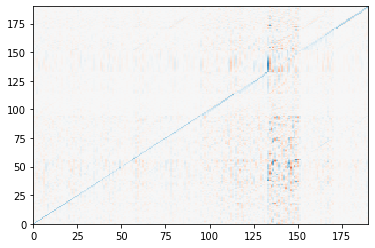

/Users/wchapman/opt/miniconda3/envs/HeatTorch/lib/python3.7/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


(-0.027365818296120878+0j)
should be negative


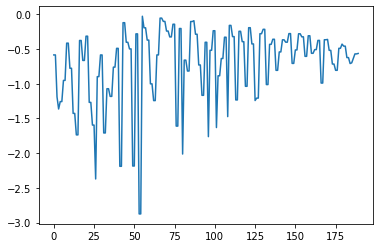

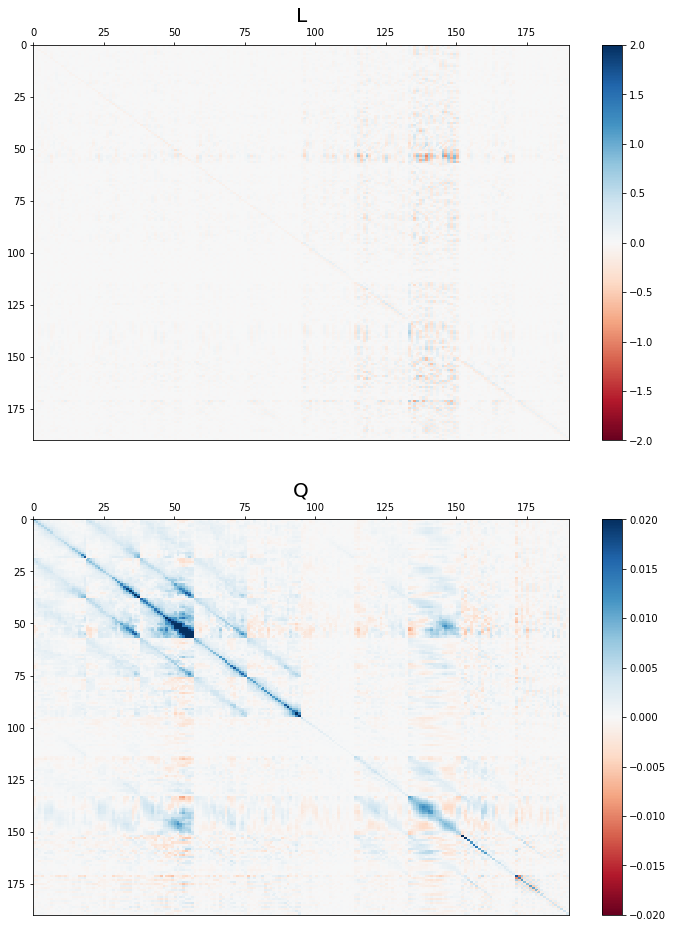

In [1596]:
LIMER = LIMG(50,50,50,device=device, static_feat=static_feats)
Q,L,G_eval = LIMER.NoiseQ()
G1 = LIMER.forward()

plt.pcolor(G1.numpy(),vmin=-2,vmax=2,cmap='RdBu')
plt.show()
eigvalss = np.linalg.eigvals(G1.numpy().T)
plt.plot(np.log(eigvalss))
print(np.max(np.log(eigvalss)/LIMER.tlag))
print('should be negative')

fig, axs = plt.subplots(2,1, figsize=(12, 16), facecolor='w', edgecolor='k')
ax1,ax2= axs.flatten()
fig.subplots_adjust(hspace = 0.2,wspace=0.3)

bing=ax1.pcolor(np.array(L.real),cmap='RdBu',vmin=-2,vmax=2)
ax1.set_title('L',fontsize=20)
ax1.invert_yaxis()
ax1.xaxis.tick_top()
cbar=fig.colorbar(bing,ax=ax1)

bing=ax2.pcolor(np.array(Q.real),cmap='RdBu',vmin=-.02,vmax=.02)
ax2.set_title('Q',fontsize=20)
ax2.invert_yaxis()
ax2.xaxis.tick_top()
cbar=fig.colorbar(bing,ax=ax2)
plt.show()

## Max Amplification Curve 

In [1597]:
#Define range of days to determine amplification for 
tau_arr = np.arange(31)+1   #Start at month 1, not month 0 
gamma1  = np.full([len(tau_arr)],np.nan)  #Empty array to store leading eigenvalue in 

/Users/wchapman/opt/miniconda3/envs/HeatTorch/lib/python3.7/site-packages/scipy/sparse/linalg/eigen/arpack/arpack.py:1268: RuntimeWarning: k >= N - 1 for N * N square matrix. Attempting to use scipy.linalg.eig instead.
  RuntimeWarning)


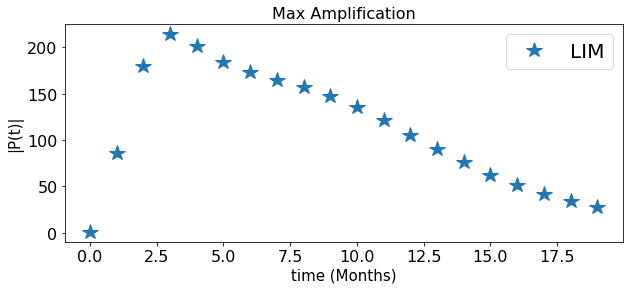

In [1598]:
import scipy

impo = np.zeros(20)
for tt in range(0,20):
    Gpow = torch.linalg.matrix_power(LIMER.forward(), tt).numpy()
    [w,q]=scipy.sparse.linalg.eigs(np.matmul(Gpow.T,Gpow),200)# this isn't quite it yet. 
    
    impo[tt] =np.max(w[0].real)
    
plt.figure(figsize=(10,4))
ax1 = plt.subplot(111)    
plt.plot(np.arange(0,20),impo,'*',label='LIM',markersize=16)
plt.xlabel('time (Months)',fontsize=15)
plt.ylabel('|P(t)|',fontsize=15)
plt.setp(ax1.get_xticklabels(), fontsize=16)
plt.setp(ax1.get_yticklabels(), fontsize=16)
plt.legend(fontsize=20)
plt.title('Max Amplification',fontsize=16)
plt.show()

In [1599]:
lat=1
xDat = LIMER.static_feat.numpy()
# Take transpose of input data matrix 
xDat_T = np.transpose(xDat) 

    # ------------------------------------------------------------------
    # STEP 1: Compute the lagged and contemporaneous covariance matrices 
sizes = np.shape(xDat)    #Get size of matrix to determine how many data points and how many time records to consider 
nDat = sizes[0]
nT   = sizes[1]
  
#Get the value of the data (xDat) at the specified lag to use in computing the lagged covariance matrix 
xLagged = np.full([nDat,nT-lag],np.nan)  #Initialize matrix full of NaNs
for iT in range(nT-lag):                 #Get the value of the data at the specified lag
    xLagged[:,iT] = xDat[:,iT+lag]

# Initialize matrices full of NaNs 
c0 = np.full([nDat, nDat], np.nan)    #Initialize matrix full of NaNs
cT = np.full([nDat, nDat], np.nan)    #Initialize matrix full of NaNs
    
# Compute covariance matrices for each data point 
for iR in range(nDat):
    for iC in range(nDat):
        # Contemporaneous covariance matrix:
        c0[iR,iC] = np.nansum(xDat[iR,:]*xDat_T[:,iC]) / np.nansum(np.isfinite(xDat[iR,:]*xDat_T[:,iC]))
        # Lagged covariance matrix:
        cT[iR,iC] = np.nansum(xLagged[iR,:]*xDat_T[:-lag,iC]) / np.nansum(np.isfinite((xLagged[iR,:]*xDat_T[:-lag,iC])))

    # --------------------------------------------------------------------

In [1600]:
G = LIMER.forward().numpy()
# Define the modes (u) and eigen-values (g) of G
g, u = LA.eig(G)

iSort = g.argsort()[::-1]    #Sort the eigen values and vectors in order 
g     = g[iSort]
u     = u[:,iSort] 

# Define the adjoints (v) based on the transpose of G 
eigVal_T, v = LA.eig(np.transpose(G))
iSortT      = eigVal_T.argsort()[::-1]
eigVal_T    = eigVal_T[iSortT]
v           = v[:,iSortT] 
   
# But modes should ultimately be sorted by decreasing decay time (i.e., decreasing values of 1/beta.real) 

# Compute Beta  
b_tau   = np.log(g)
b_alpha = b_tau/lag

# Sort data by decreasing decay time 
sortVal = -1/b_alpha.real              #Decay time 

iSort2 = sortVal.argsort()[::-1]      #Sorted indices 
u      = u[:,iSort2]
v      = v[:,iSort2]
g      = g[iSort2]

b_alpha = b_alpha[iSort2]

# Make diagonal array of Beta (values should be negative)
beta = np.zeros((nDat, nDat), complex)
np.fill_diagonal(beta, b_alpha)

 
#Need to normalize u so that u_transpose*v = identitity matrix, and u*v_transpose = identity matrix as well 
normFactors = np.dot(np.transpose(u),v)
normU       = np.dot(u,LA.inv(normFactors))

# --------------------------------------------------------------------
# STEP 3: Compute L and Q matrices 

# Compute L matrix as normU * beta * v_transpose 
L = np.dot(normU, np.dot(beta, np.transpose(v)))

# Compute Q matrix 
Q_negative = np.dot(L, c0) + np.dot(c0, np.transpose(L))
Q = -Q_negative 
# Also define the periods and decay times 
periods = (2 * np.pi) / b_alpha.imag 
decayT  = -1 / b_alpha.real 
nonnormU = u
u=normU


b_alpha__,L__,Q__,G__,c0__,cT__,u__,v__,g__,periods__,decayT__ = LIM(static_feats, tau0)

my way
my way


/Users/wchapman/opt/miniconda3/envs/HeatTorch/lib/python3.7/site-packages/ipykernel_launcher.py:50: RuntimeWarning: divide by zero encountered in true_divide
/Users/wchapman/opt/miniconda3/envs/HeatTorch/lib/python3.7/site-packages/ipykernel_launcher.py:87: RuntimeWarning: divide by zero encountered in true_divide


/Users/wchapman/opt/miniconda3/envs/HeatTorch/lib/python3.7/site-packages/ipykernel_launcher.py:26: ComplexWarning: Casting complex values to real discards the imaginary part


T0 = 1  days; Peak growth =  [3]  month


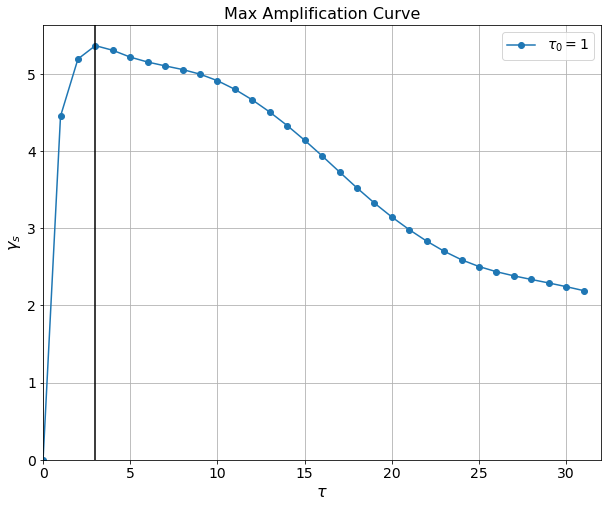

In [1601]:
#Define range of days to determine amplification for 
tau_arr = np.arange(31)+1   #Start at day 1, not day 0 

gamma1  = np.full([len(tau_arr)],np.nan)  #Empty array to store leading eigenvalue in 

#Get diagonal matrix of g 
g_diag = np.zeros((LIMER.static_feat.numpy().shape[0], LIMER.static_feat.numpy().shape[0]), complex)
np.fill_diagonal(g_diag, g)

tau0=1

#Check G(tau) for each value in tau_arr given tau0 
for iLag in range(len(tau_arr)):
    G_tau = np.dot(u,np.dot((g_diag)**(tau_arr[iLag]/tau0),np.transpose(v)))
    # ---- EOF analysis of GtG ---- #
    GTG = np.dot(np.transpose(G_tau),G_tau)

    eigVal_GTG, eigVec_GTG = np.linalg.eig(GTG)

    #Sort the eigenvalues in order 
    iSort_GTG  = eigVal_GTG.argsort()[::-1]   
    eigVal_GTG = eigVal_GTG[iSort_GTG]
    eigVec_GTG = eigVec_GTG[:,iSort_GTG]

    #Save first eigen value for this Tau (the maximum growing mode)
    gamma1[iLag] = np.log(eigVal_GTG[0])

#Insert a value of zero for day zero (initial conditions = no amplification)
gamma_all = np.insert(gamma1, 0, 0)


print('T0 =', tau0,' days; Peak growth = ',np.where(gamma_all==np.max(gamma_all))[0],' month')
# Define the lag associated with the maximum amplification (Tau_peak)
Tau_peak = int(np.where(gamma_all==np.max(gamma_all))[0])

# Set up figure window 
fig, ax1  = plt.subplots()
fig.set_size_inches(10,8)

# Plot leading eigenvalue     
ax1.plot(np.arange(32),gamma_all,'o-')
ax1.set_xlim([0,32])
ax1.set_ylim([np.min(gamma_all)*1.05,np.max(gamma_all)*1.05])  #Extend to 5% above maximum value

ax1.set_xlabel(r'$\tau $',fontsize=16)
ax1.set_ylabel(r'$\gamma_s $',fontsize=16)
ax1.grid()
ax1.axvline(Tau_peak,color='k')
ax1.set_title('Max Amplification Curve',fontsize=16)
ax1.legend([r'$\tau_0 = $'+str(tau0)],fontsize=14)
ax1.tick_params(labelsize=14)

/Users/wchapman/opt/miniconda3/envs/HeatTorch/lib/python3.7/site-packages/ipykernel_launcher.py:84: RuntimeWarning: divide by zero encountered in true_divide


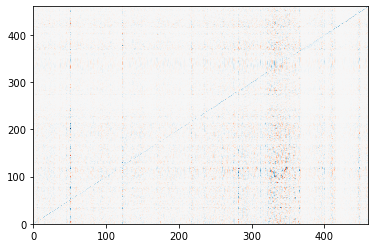

/Users/wchapman/opt/miniconda3/envs/HeatTorch/lib/python3.7/site-packages/ipykernel_launcher.py:61: RuntimeWarning: divide by zero encountered in true_divide


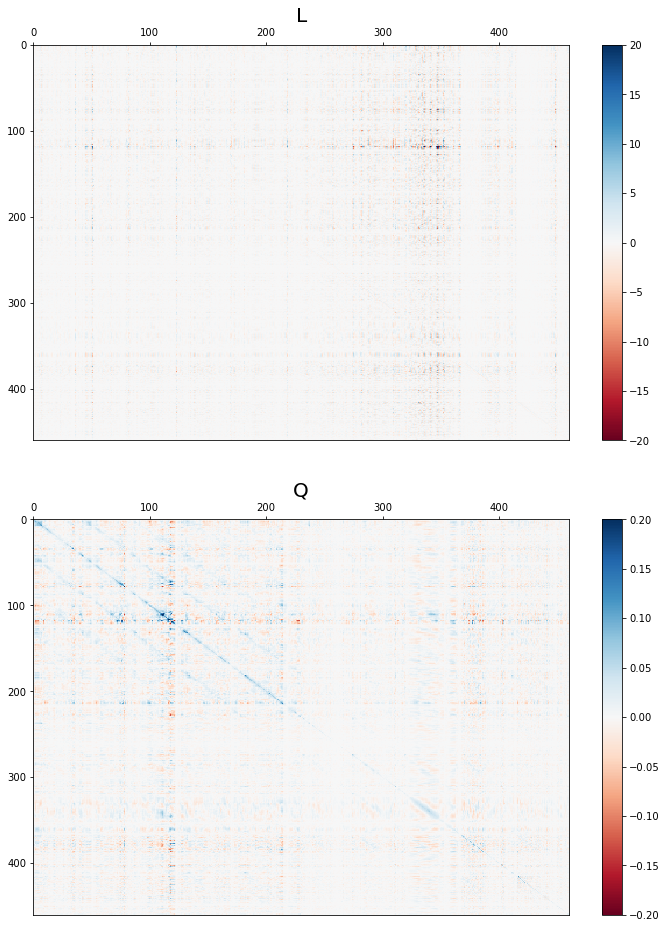

In [1178]:
from numpy import linalg as LA 
tau0=1
lag=tau0
### Compute g_diag
G = LIMER.forward().numpy()
b_alpha__,L__,Q__,G,c0__,cT__,u__,v__,g__,periods__,decayT__ = LIM(static_feats, tau0)

# G=G__
nDat = G.shape[0]
plt.pcolor(G,vmin=-2,vmax=2,cmap='RdBu')
plt.show()


g, u = LA.eig(G)
iSort = g.argsort()[::-1]    #Sort the eigen values and vectors in order 
g     = g[iSort]
u     = u[:,iSort]


#define adjoints (v) based on the transpose of G. 
eigVal_T, v = LA.eig(np.transpose(G))
iSortT      = eigVal_T.argsort()[::-1]
eigVal_T    = eigVal_T[iSortT]
v           = v[:,iSortT] 

# Compute Beta  
b_tau   = np.log(g)
b_alpha = b_tau/lag

# Sort data by decreasing decay time 
sortVal = -1/b_alpha.real              #Decay time 

iSort2 = sortVal.argsort()[::-1]      #Sorted indices 
u      = u[:,iSort2]
v      = v[:,iSort2]
g      = g[iSort2]
b_alpha = b_alpha[iSort2]

# Make diagonal array of Beta (values should be negative)
beta = np.zeros((nDat, nDat), complex)
np.fill_diagonal(beta, b_alpha)
    
#Need to normalize u so that u_transpose*v = identitity matrix, and u*v_transpose = identity matrix as well 
normFactors = np.dot(np.transpose(u),v)
normU       = np.dot(u,LA.inv(normFactors))

# Compute L matrix as normU * beta * v_transpose 
L = np.dot(normU, np.dot(beta, np.transpose(v)))

# Compute Q matrix 
Q_negative = np.dot(L, c0) + np.dot(c0, np.transpose(L))


c0=(LIMER.static_feat.numpy()@LIMER.static_feat.numpy().T)/(LIMER.static_feat.numpy().shape[1])

# Compute Q matrix 
Q_negative = np.dot(L, c0) + np.dot(c0, np.transpose(L))
Q = -Q_negative 

# Also define the periods and decay times 
periods = (2 * np.pi) / b_alpha.imag 
decayT  = -1 / b_alpha.real


fig, axs = plt.subplots(2,1, figsize=(12, 16), facecolor='w', edgecolor='k')
ax1,ax2= axs.flatten()
fig.subplots_adjust(hspace = 0.2,wspace=0.3)

bing=ax1.pcolor(np.array(L.real),cmap='RdBu',vmin=-20,vmax=20)
ax1.set_title('L',fontsize=20)
ax1.invert_yaxis()
ax1.xaxis.tick_top()
cbar=fig.colorbar(bing,ax=ax1)

bing=ax2.pcolor(np.array(Q.real),cmap='RdBu',vmin=-.2,vmax=.2)
ax2.set_title('Q',fontsize=20)
ax2.invert_yaxis()
ax2.xaxis.tick_top()
cbar=fig.colorbar(bing,ax=ax2)
plt.show()

In [1749]:
def LIM(xDat,lag):  
    import numpy as np 
    from numpy import linalg as LA 

    # Take transpose of input data matrix 
    xDat_T = np.transpose(xDat) 

    # ------------------------------------------------------------------
    # STEP 1: Compute the lagged and contemporaneous covariance matrices 
    sizes = np.shape(xDat)    #Get size of matrix to determine how many data points and how many time records to consider 
    nDat = sizes[0]
    nT   = sizes[1]
  
    #Get the value of the data (xDat) at the specified lag to use in computing the lagged covariance matrix 
    xLagged = np.full([nDat,nT-lag],np.nan)  #Initialize matrix full of NaNs
    for iT in range(nT-lag):                 #Get the value of the data at the specified lag
        xLagged[:,iT] = xDat[:,iT+lag]

    # Initialize matrices full of NaNs 
    c0 = np.full([nDat, nDat], np.nan)    #Initialize matrix full of NaNs
    cT = np.full([nDat, nDat], np.nan)    #Initialize matrix full of NaNs
    
    # Compute covariance matrices for each data point 
    for iR in range(nDat):
        for iC in range(nDat):
            # Contemporaneous covariance matrix:
            c0[iR,iC] = np.nansum(xDat[iR,:]*xDat_T[:,iC]) / np.nansum(np.isfinite(xDat[iR,:]*xDat_T[:,iC]))
            # Lagged covariance matrix:
            cT[iR,iC] = np.nansum(xLagged[iR,:]*xDat_T[:-lag,iC]) / np.nansum(np.isfinite((xLagged[iR,:]*xDat_T[:-lag,iC])))

    # --------------------------------------------------------------------
    # STEP 2: Compute the Green function, defining its eigen values and vectors 
    
    G = cT.dot(LA.inv(c0))    #The Green function is defined as the product between covariance matrices 
#   print('my way')
#     G = LIMER.forward().numpy()
#     print('my way')

    # Define the modes (u) and eigen-values (g) of G
    g, u = LA.eig(G)

    iSort = g.argsort()[::-1]    #Sort the eigen values and vectors in order 
    g     = g[iSort]
    u     = u[:,iSort] 

    # Define the adjoints (v) based on the transpose of G 
    eigVal_T, v = LA.eig(np.transpose(G))
    iSortT      = eigVal_T.argsort()[::-1]
    eigVal_T    = eigVal_T[iSortT]
    v           = v[:,iSortT] 
   
    # But modes should ultimately be sorted by decreasing decay time (i.e., decreasing values of 1/beta.real) 

    # Compute Beta  
    b_tau   = np.log(g)
    b_alpha = b_tau/lag

    # Sort data by decreasing decay time 
    sortVal = -1/b_alpha.real              #Decay time 

    iSort2 = sortVal.argsort()[::-1]      #Sorted indices 
    u      = u[:,iSort2]
    v      = v[:,iSort2]
    g      = g[iSort2]
    b_alpha = b_alpha[iSort2]

    # Make diagonal array of Beta (values should be negative)
    beta = np.zeros((nDat, nDat), complex)
    np.fill_diagonal(beta, b_alpha)

 
    #Need to normalize u so that u_transpose*v = identitity matrix, and u*v_transpose = identity matrix as well 
    normFactors = np.dot(np.transpose(u),v)
    normU       = np.dot(u,LA.inv(normFactors))

    # --------------------------------------------------------------------
    # STEP 3: Compute L and Q matrices 

    # Compute L matrix as normU * beta * v_transpose 
    L = np.dot(normU, np.dot(beta, np.transpose(v)))

    # Compute Q matrix 
    Q_negative = np.dot(L, c0) + np.dot(c0, np.transpose(L))
    Q = -Q_negative 

    # Also define the periods and decay times 
    periods = (2 * np.pi) / b_alpha.imag 
    decayT  = -1 / b_alpha.real 

    # --------------------------------------------------------------------
    # RETURN statement 
    return(b_alpha, L, Q, G, c0, cT, normU, v, g, periods, decayT) 




In [1750]:
tau0=1
b_alpha__,L__,Q__,G__,c0__,cT__,u__,v__,g__,periods__,decayT__ = LIM(static_feats, tau0)

/Users/wchapman/opt/miniconda3/envs/HeatTorch/lib/python3.7/site-packages/ipykernel_launcher.py:87: RuntimeWarning: divide by zero encountered in true_divide


my way
my way
...plotting...


/Users/wchapman/opt/miniconda3/envs/HeatTorch/lib/python3.7/site-packages/ipykernel_launcher.py:87: RuntimeWarning: divide by zero encountered in true_divide
/Users/wchapman/opt/miniconda3/envs/HeatTorch/lib/python3.7/site-packages/ipykernel_launcher.py:31: ComplexWarning: Casting complex values to real discards the imaginary part


T0 = 1  days; Peak growth =  [3]  month


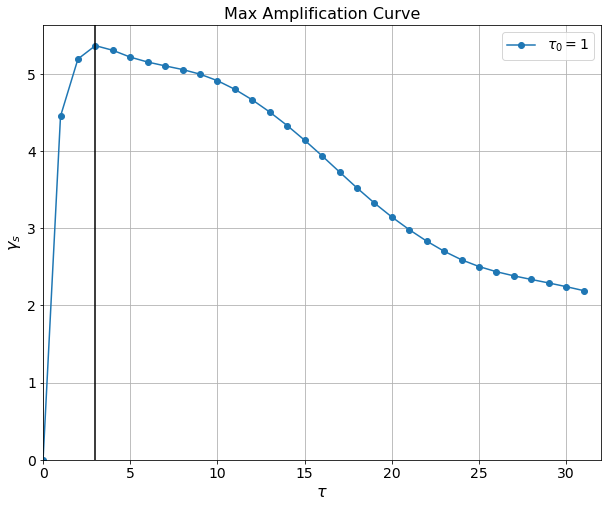

In [1604]:
tau0=1
b_alpha__,L__,Q__,G__,c0__,cT__,u__,v__,g__,periods__,decayT__ = LIM(static_feats, tau0)


print('...plotting...')
#Define range of days to determine amplification for 
tau_arr = np.arange(31)+1   #Start at day 1, not day 0 

gamma1  = np.full([len(tau_arr)],np.nan)  #Empty array to store leading eigenvalue in 

#Get diagonal matrix of g 
g_diag = np.zeros((LIMER.static_feat.numpy().shape[0], LIMER.static_feat.numpy().shape[0]), complex)
np.fill_diagonal(g_diag, g__)

tau0=1

#Check G(tau) for each value in tau_arr given tau0 
for iLag in range(len(tau_arr)):
    G_tau = np.dot(u__,np.dot((g_diag)**(tau_arr[iLag]/tau0),np.transpose(v__)))
    # ---- EOF analysis of GtG ---- #
    GTG = np.dot(np.transpose(G_tau),G_tau)

    eigVal_GTG, eigVec_GTG = np.linalg.eig(GTG)

    #Sort the eigenvalues in order 
    iSort_GTG  = eigVal_GTG.argsort()[::-1]   
    eigVal_GTG = eigVal_GTG[iSort_GTG]
    eigVec_GTG = eigVec_GTG[:,iSort_GTG]

    #Save first eigen value for this Tau (the maximum growing mode)
    gamma1[iLag] = np.log(eigVal_GTG[0])

#Insert a value of zero for day zero (initial conditions = no amplification)
gamma_all = np.insert(gamma1, 0, 0)


print('T0 =', tau0,' days; Peak growth = ',np.where(gamma_all==np.max(gamma_all))[0],' month')
# Define the lag associated with the maximum amplification (Tau_peak)
Tau_peak = int(np.where(gamma_all==np.max(gamma_all))[0])

# Set up figure window 
fig, ax1  = plt.subplots()
fig.set_size_inches(10,8)

# Plot leading eigenvalue     
ax1.plot(np.arange(32),gamma_all,'o-')
ax1.set_xlim([0,32])
ax1.set_ylim([np.min(gamma_all)*1.05,np.max(gamma_all)*1.05])  #Extend to 5% above maximum value

ax1.set_xlabel(r'$\tau $',fontsize=16)
ax1.set_ylabel(r'$\gamma_s $',fontsize=16)
ax1.grid()
ax1.axvline(Tau_peak,color='k')
ax1.set_title('Max Amplification Curve',fontsize=16)
ax1.legend([r'$\tau_0 = $'+str(tau0)],fontsize=14)
ax1.tick_params(labelsize=14)



/Users/wchapman/opt/miniconda3/envs/HeatTorch/lib/python3.7/site-packages/ipykernel_launcher.py:87: RuntimeWarning: divide by zero encountered in true_divide
/Users/wchapman/opt/miniconda3/envs/HeatTorch/lib/python3.7/site-packages/ipykernel_launcher.py:34: ComplexWarning: Casting complex values to real discards the imaginary part


...plotting...
T0 = 1  days; Peak growth =  [3]  month


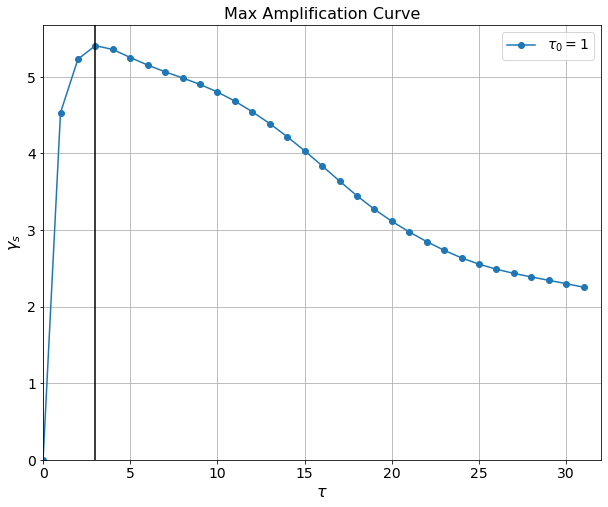

In [1751]:
static_feats_scaled = static_feats-np.expand_dims(np.mean(static_feats,axis=1),axis=1)
static_feats_scaled = static_feats_scaled/np.std(static_feats_scaled)

tau0=1
b_alpha__,L__,Q__,G__,c0__,cT__,u__,v__,g__,periods__,decayT__ = LIM(static_feats_scaled, tau0)


print('...plotting...')
#Define range of days to determine amplification for 
tau_arr = np.arange(31)+1   #Start at day 1, not day 0 

gamma1  = np.full([len(tau_arr)],np.nan)  #Empty array to store leading eigenvalue in 

#Get diagonal matrix of g 
g_diag = np.zeros((LIMER.static_feat.numpy().shape[0], LIMER.static_feat.numpy().shape[0]), complex)
np.fill_diagonal(g_diag, g__)

tau0=1

#Check G(tau) for each value in tau_arr given tau0 
for iLag in range(len(tau_arr)):
    G_tau = np.dot(u__,np.dot((g_diag)**(tau_arr[iLag]/tau0),np.transpose(v__)))
    # ---- EOF analysis of GtG ---- #
    GTG = np.dot(np.transpose(G_tau),G_tau)

    eigVal_GTG, eigVec_GTG = np.linalg.eig(GTG)

    #Sort the eigenvalues in order 
    iSort_GTG  = eigVal_GTG.argsort()[::-1]   
    eigVal_GTG = eigVal_GTG[iSort_GTG]
    eigVec_GTG = eigVec_GTG[:,iSort_GTG]

    #Save first eigen value for this Tau (the maximum growing mode)
    gamma1[iLag] = np.log(eigVal_GTG[0])

#Insert a value of zero for day zero (initial conditions = no amplification)
gamma_all = np.insert(gamma1, 0, 0)


print('T0 =', tau0,' days; Peak growth = ',np.where(gamma_all==np.max(gamma_all))[0],' month')
# Define the lag associated with the maximum amplification (Tau_peak)
Tau_peak = int(np.where(gamma_all==np.max(gamma_all))[0])

# Set up figure window 
fig, ax1  = plt.subplots()
fig.set_size_inches(10,8)

# Plot leading eigenvalue     
ax1.plot(np.arange(32),gamma_all,'o-')
ax1.set_xlim([0,32])
ax1.set_ylim([np.min(gamma_all)*1.05,np.max(gamma_all)*1.05])  #Extend to 5% above maximum value

ax1.set_xlabel(r'$\tau $',fontsize=16)
ax1.set_ylabel(r'$\gamma_s $',fontsize=16)
ax1.grid()
ax1.axvline(Tau_peak,color='k')
ax1.set_title('Max Amplification Curve',fontsize=16)
ax1.legend([r'$\tau_0 = $'+str(tau0)],fontsize=14)
ax1.tick_params(labelsize=14)



In [655]:
BB = xr.open_dataset('/Users/wchapman/Desktop/Heater/HeatGCN/Heater/Data/SODA/SODA.input.36mn.1871_1970.nc')
BB

<xarray.Dataset>
Dimensions:  (lat: 24, lev: 36, lon: 72, time: 100)
Coordinates:
  * lon      (lon) float64 0.0 5.0 10.0 15.0 20.0 ... 340.0 345.0 350.0 355.0
  * lat      (lat) float64 -55.0 -50.0 -45.0 -40.0 -35.0 ... 45.0 50.0 55.0 60.0
  * lev      (lev) float64 1.0 2.0 3.0 4.0 5.0 6.0 ... 32.0 33.0 34.0 35.0 36.0
  * time     (time) datetime64[ns] 1871-01-01 1872-01-01 ... 1970-01-01
Data variables:
    sst      (time, lev, lat, lon) float32 ...
    t300     (time, lev, lat, lon) float32 ...
Attributes:
    CDI:          Climate Data Interface version 1.6.3 (http://code.zmaw.de/p...
    Conventions:  CF-1.4
    history:      Wed Aug 29 12:46:31 2018: cdo -f nc import_binary set/soda....
    CDO:          Climate Data Operators version 1.6.3 (http://code.zmaw.de/p...

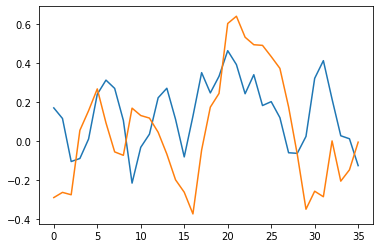

In [661]:
plt.plot(BB.sel(lat=-5,lon=145,time='1969-01-01').sst)
plt.plot(BB.sel(lat=5,lon=145,time='1969-01-01').sst)

## Optimal Structure Init

In [1222]:
load_data_kwargs = {
        'window': params['window'], 'lead_months': params['horizon'], 'lon_min': params['lon_min'],
        'lon_max': params['lon_max'], 'lat_min': params['lat_min'], 'lat_max': params['lat_max'],
        'data_dir': params['data_dir'], 'use_heat_content': params['use_heat_content'],
        'add_index_node': net_params['index_node']
    }
cmip5, SODA, GODAS, cords, cnn_mask = load_cnn_data(**load_data_kwargs, return_new_coordinates=True, return_mask=True)
dinny = np.zeros(cnn_mask[:-1].shape)*np.nan
# dinny[cnn_mask[:-1]] = best_model_lim.LIM_learner.eofs[0,:-1]

lats=np.unique(SODA[0].lat)
lons=np.unique(SODA[0].lon)



/Users/wchapman/opt/miniconda3/envs/HeatTorch/lib/python3.7/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/Users/wchapman/opt/miniconda3/envs/HeatTorch/lib/python3.7/site-packages/numpy/core/_asarray.py:83: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)
/Users/wchapman/opt/miniconda3/envs/HeatTorch/lib/python3.7/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/Users/

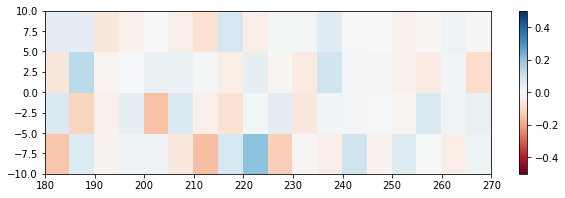

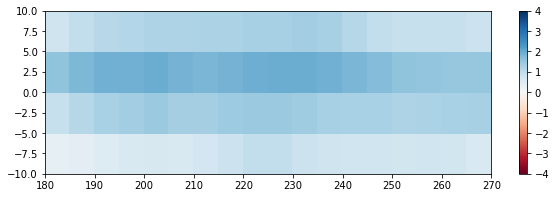

In [1606]:
#Make diagonal matrix of g (again, if not done before)
Tau_peak = 7

g_diag = np.zeros((LIMER.static_feat.numpy().shape[0], LIMER.static_feat.numpy().shape[0]), complex)
np.fill_diagonal(g_diag, g)
G_tau = np.dot(u,np.dot((g_diag)**(Tau_peak/tau0),np.transpose(v)))

# ---- EOF analysis of GtG ---- #
GTG = np.dot(np.transpose(G_tau),G_tau)

eigVal_GTG, eigVec_GTG = LA.eig(GTG)

#Sort the eigenvalues in order 
iSort_GTG  = eigVal_GTG.argsort()[::-1]   
eigVal_GTG = eigVal_GTG[iSort_GTG] 
eigVec_GTG = eigVec_GTG[:,iSort_GTG]

#The optimal structure is the first eigenVector of the matrix GtG. 
optimStruct = eigVec_GTG[:,0].real
#Get the forecast by projecting G(tau) onto that optimal structure 
forecast = np.dot(G_tau.real,optimStruct)
# optimStruct = optimStruct[230:]


opty_heat = xr.DataArray(np.zeros((len(lats), len(lons)))*np.nan, coords=[("lat", lats), ("lon", lons)])
opty_for = xr.DataArray(np.zeros((len(lats), len(lons)))*np.nan, coords=[("lat", lats), ("lon", lons)])

for node, (lat_i, lon_i) in enumerate(cords[:-1]):
    opty_heat.loc[lat_i, lon_i] = optimStruct[node]
    opty_for.loc[lat_i, lon_i] = forecast[node]
    
    
plt.figure(figsize=(10,3))
plt.pcolor(lons,lats,opty_heat.data,vmin=-.5,vmax=.5,cmap='RdBu')
plt.colorbar()
plt.show()

plt.figure(figsize=(10,3))
plt.pcolor(lons,lats,opty_for.data,vmin=-4,vmax=4,cmap='RdBu')
plt.colorbar()
plt.show()

In [1755]:
b_alpha__,L__,Q__,G__,c0__,cT__,u__,v__,g__,periods__,decayT__ = LIM(static_feats_scaled[:95,:], tau0)
g__.shape

/Users/wchapman/opt/miniconda3/envs/HeatTorch/lib/python3.7/site-packages/ipykernel_launcher.py:87: RuntimeWarning: divide by zero encountered in true_divide


(95,)

/Users/wchapman/opt/miniconda3/envs/HeatTorch/lib/python3.7/site-packages/ipykernel_launcher.py:87: RuntimeWarning: divide by zero encountered in true_divide


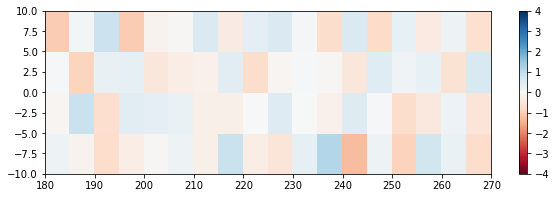

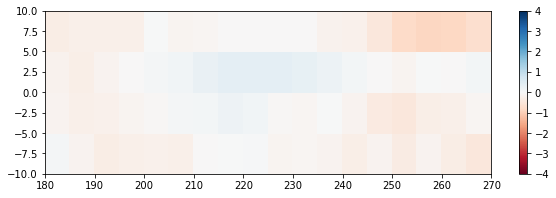

In [1801]:
static_feats_scaled = static_feats-np.expand_dims(np.mean(static_feats,axis=1),axis=1)
static_feats_scaled = static_feats_scaled/np.std(static_feats_scaled)

tau0=1
b_alpha__,L__,Q__,G__,c0__,cT__,u__,v__,g__,periods__,decayT__ = LIM(static_feats_scaled[:,:], tau0)
g__[g__<0]=0

Tau_peak = 3

wgtMatrix = np.zeros([ndat,ndat])
# -- MODIFY HERE -- # 
for i in range(95):          # For the moisture norm, we only want to consider the bottom half of G. 
    wgtMatrix[i,i]=1   # So the weight matrix should be 1s on diagonal in bottom half

g_diag = np.zeros((G__.shape[0],G__.shape[0]), complex)
np.fill_diagonal(g_diag, g__)
G_tau = np.dot(u__,np.dot((g_diag)**(Tau_peak/tau0),np.transpose(v__)))

# ---- EOF analysis of GtG ---- #
GTG = np.dot(np.transpose(G_tau), G_tau)

eigVal_GTG, eigVec_GTG = LA.eig(GTG)

#Sort the eigenvalues in order 
iSort_GTG  = eigVal_GTG.argsort()[::-1]   
eigVal_GTG = eigVal_GTG[iSort_GTG] 
eigVec_GTG = eigVec_GTG[:,iSort_GTG]

#The optimal structure is the first eigenVector of the matrix GtG. 
optimStruct = eigVec_GTG[:,2].real
#Get the forecast by projecting G(tau) onto that optimal structure 
forecast = np.dot(G_tau.real,optimStruct)
# optimStruct = optimStruct[230:]


opty_heat = xr.DataArray(np.zeros((len(lats), len(lons)))*np.nan, coords=[("lat", lats), ("lon", lons)])
opty_for = xr.DataArray(np.zeros((len(lats), len(lons)))*np.nan, coords=[("lat", lats), ("lon", lons)])

for node, (lat_i, lon_i) in enumerate(cords[:-1]):
    opty_heat.loc[lat_i, lon_i] = optimStruct[node]
    opty_for.loc[lat_i, lon_i] = forecast[node]
    
    
plt.figure(figsize=(10,3))
plt.pcolor(lons,lats,opty_heat.data*10,vmin=-4,vmax=4,cmap='RdBu')
plt.colorbar()
plt.show()

plt.figure(figsize=(10,3))
plt.pcolor(lons,lats,opty_for.data,vmin=-4,vmax=4,cmap='RdBu')
plt.colorbar()
plt.show()


## Test LIM

torch.Size([64, 190])


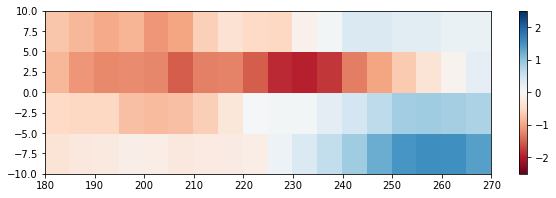

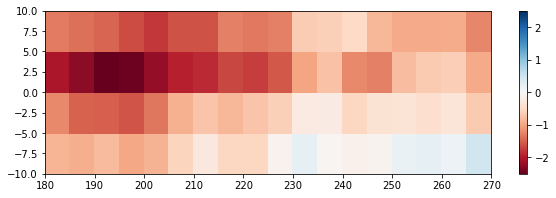

In [1685]:
Gpow = torch.linalg.matrix_power(LIMER.forward(), 6)
# Gpow = torch.tensor(np.dot(u,np.dot((g_diag)**(3/tau0),np.transpose(v))).real)

inbaby = iter(testloader).next()[0]
Forecast_inits =torch.cat((inbaby[:,0,-1,:].to(torch.float64).to('cpu'),inbaby[:,1,-1,:].to(torch.float64).to('cpu')),1)
fcast = torch.mm(Forecast_inits.to(torch.float64).to('cpu'),Gpow.T)

print(fcast.shape)
look=0

opty_heat = xr.DataArray(np.zeros((len(lats), len(lons)))*np.nan, coords=[("lat", lats), ("lon", lons)])
opty_for = xr.DataArray(np.zeros((len(lats), len(lons)))*np.nan, coords=[("lat", lats), ("lon", lons)])

for node, (lat_i, lon_i) in enumerate(cords[:-1]):
    opty_heat.loc[lat_i, lon_i] = Forecast_inits.numpy()[look,node]
    opty_for.loc[lat_i, lon_i] = fcast.numpy()[look,node]
    
    
plt.figure(figsize=(10,3))
plt.pcolor(lons,lats,opty_heat.data,vmin=-2.5,vmax=2.5,cmap='RdBu')
plt.colorbar()
plt.show()

plt.figure(figsize=(10,3))
plt.pcolor(lons,lats,opty_for.data,vmin=-2.5,vmax=2.5,cmap='RdBu')
plt.colorbar()
plt.show()

torch.Size([64, 190])


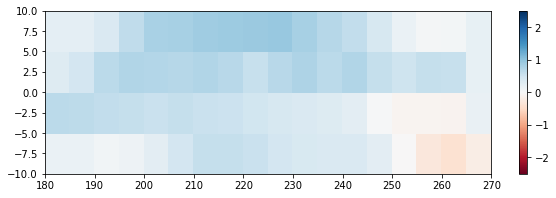

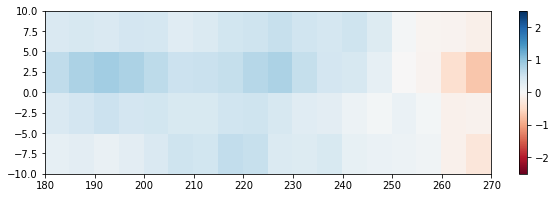

In [1610]:
Gpow = torch.linalg.matrix_power(LIMER.forward(), 3)
# Gpow = torch.tensor(np.dot(u,np.dot((g_diag)**(8/tau0),np.transpose(v))).real)

inbaby = iter(valloader).next()[0]
Forecast_inits =torch.cat((inbaby[:,0,-1,:].to(torch.float64).to('cpu'),inbaby[:,1,-1,:].to(torch.float64).to('cpu')),1)
fcast = torch.mm(Forecast_inits.to(torch.float64).to('cpu'),Gpow.T)

print(fcast.shape)
look=38

opty_heat = xr.DataArray(np.zeros((len(lats), len(lons)))*np.nan, coords=[("lat", lats), ("lon", lons)])
opty_for = xr.DataArray(np.zeros((len(lats), len(lons)))*np.nan, coords=[("lat", lats), ("lon", lons)])

for node, (lat_i, lon_i) in enumerate(cords[:-1]):
    opty_heat.loc[lat_i, lon_i] = Forecast_inits.numpy()[look,node]
    opty_for.loc[lat_i, lon_i] = fcast.numpy()[look,node]
    
    
plt.figure(figsize=(10,3))
plt.pcolor(lons,lats,opty_heat.data,vmin=-2.5,vmax=2.5,cmap='RdBu')
plt.colorbar()
plt.show()

plt.figure(figsize=(10,3))
plt.pcolor(lons,lats,opty_for.data,vmin=-2.5,vmax=2.5,cmap='RdBu')
plt.colorbar()
plt.show()

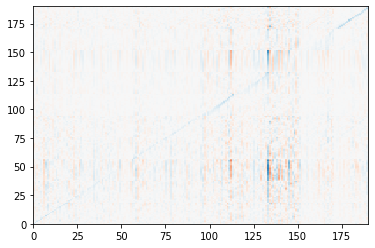

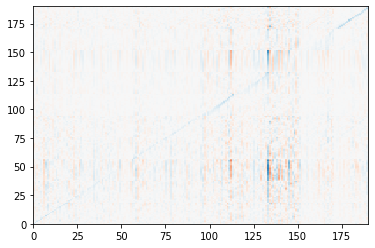

In [1611]:
G_tau           = np.dot(u,np.dot((g_diag)**(3/tau0),np.transpose(v)))
plt.pcolor(G_tau.real,vmin=-2,vmax=2,cmap='RdBu')
plt.show()


Gpow = torch.linalg.matrix_power(LIMER.forward(), 3)
plt.pcolor(Gpow,vmin=-2,vmax=2,cmap='RdBu')
plt.show()

my way
my way


/Users/wchapman/opt/miniconda3/envs/HeatTorch/lib/python3.7/site-packages/ipykernel_launcher.py:87: RuntimeWarning: divide by zero encountered in true_divide


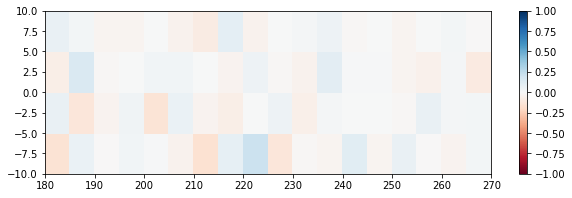

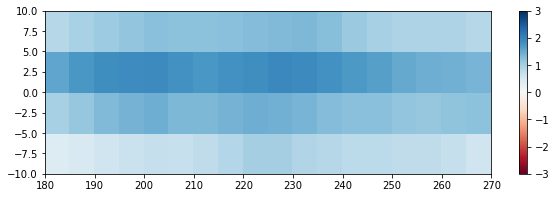

In [1689]:
#Initial conditions/definitions from LIM 
b_alpha,L,Q,G,c0,cT,u,v,g,periods,decayT = LIM(static_feats[:95],8)

#Make diagonal matrix of g
g_diag = np.zeros((nDat, nDat), complex)
np.fill_diagonal(g_diag, g)
#Define Green's function at the peak of the max amplification growth 
G_tau           = np.dot(u,np.dot((g_diag)**(maxAmp/tau0),np.transpose(v)))

# ---- EOF analysis of GtG ---- #
matr = np.dot(np.transpose(G_tau),G_tau)

eigVal_GTG, eigVec_GTG = LA.eig(matr)

#Sort the eigenvalues in order 
iSort_GTG  = eigVal_GTG.argsort()[::-1]   
eigVal_GTG = eigVal_GTG[iSort_GTG] 
eigVec_GTG = eigVec_GTG[:,iSort_GTG]

#The optimal structure is the first eigenVector of the matrix GtG. 
optimStruct = eigVec_GTG[:,0].real

#Get the forecast by projecting G(tau) onto that optimal structure 
forecastStruct = np.dot(G_tau.real,optimStruct)


opty_heat = xr.DataArray(np.zeros((len(lats), len(lons)))*np.nan, coords=[("lat", lats), ("lon", lons)])
opty_for = xr.DataArray(np.zeros((len(lats), len(lons)))*np.nan, coords=[("lat", lats), ("lon", lons)])

for node, (lat_i, lon_i) in enumerate(cords[:-1]):
    opty_heat.loc[lat_i, lon_i] = optimStruct[node]
    opty_for.loc[lat_i, lon_i] = forecastStruct[node]
    

    
plt.figure(figsize=(10,3))
plt.pcolor(lons,lats,opty_heat.data,vmin=-1,vmax=1,cmap='RdBu')
plt.colorbar()
plt.show()

plt.figure(figsize=(10,3))
plt.pcolor(lons,lats,opty_for.data,vmin=-3,vmax=3,cmap='RdBu')
plt.colorbar()
plt.show()

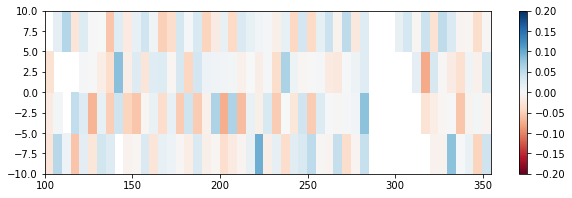

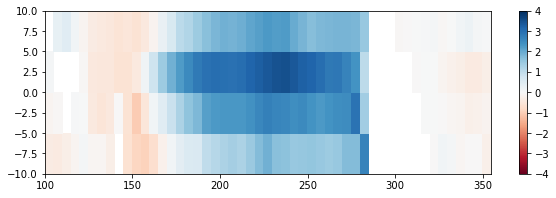

In [1550]:
Tau_peak=7
G_tau = (np.linalg.matrix_power(G,(Tau_peak)))
GTG = np.dot(np.transpose(G_tau),G_tau)
eigVal_GTG, eigVec_GTG = LA.eig(GTG)

GTG = np.dot((G_tau),G_tau.T)

iSort_GTG  = eigVal_GTG.argsort()[::-1]   
eigVal_GTG = eigVal_GTG[iSort_GTG] 
eigVec_GTG = eigVec_GTG[:,iSort_GTG]

optimStruct = eigVec_GTG[:,0].real
forecast = np.dot(optimStruct,G_tau.T)

opty_heat = xr.DataArray(np.zeros((len(lats), len(lons)))*np.nan, coords=[("lat", lats), ("lon", lons)])
opty_for = xr.DataArray(np.zeros((len(lats), len(lons)))*np.nan, coords=[("lat", lats), ("lon", lons)])

for node, (lat_i, lon_i) in enumerate(cords[:-1]):
    opty_heat.loc[lat_i, lon_i] = optimStruct[node]
    opty_for.loc[lat_i, lon_i] = forecast[node]
    

    
plt.figure(figsize=(10,3))
plt.pcolor(lons,lats,opty_heat.data,vmin=-.2,vmax=.2,cmap='RdBu')
plt.colorbar()
plt.show()

plt.figure(figsize=(10,3))
plt.pcolor(lons,lats,opty_for.data,vmin=-4,vmax=4,cmap='RdBu')
plt.colorbar()
plt.show()

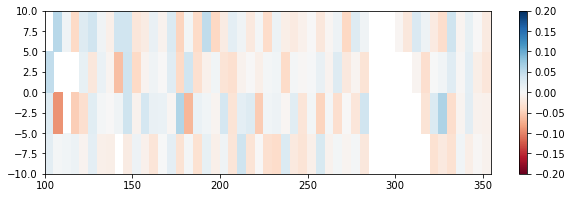

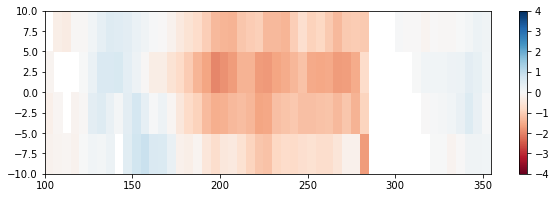

In [1421]:
#Make diagonal matrix of g (again, if not done before)
Tau_peak = 4

g_diag = np.zeros((LIMER.static_feat.numpy().shape[0], LIMER.static_feat.numpy().shape[0]), complex)
np.fill_diagonal(g_diag, g__)
G_tau = np.dot(u,np.dot((g_diag)**(Tau_peak/tau0),np.transpose(v)))

# ---- EOF analysis of GtG ---- #
GTG = np.dot(np.transpose(G_tau),G_tau)

eigVal_GTG, eigVec_GTG = LA.eig(GTG)

#Sort the eigenvalues in order 
iSort_GTG  = eigVal_GTG.argsort()[::-1]   
eigVal_GTG = eigVal_GTG[iSort_GTG] 
eigVec_GTG = eigVec_GTG[:,iSort_GTG]

#The optimal structure is the first eigenVector of the matrix GtG. 
optimStruct = eigVec_GTG[:,0].real
#Get the forecast by projecting G(tau) onto that optimal structure 
forecast = np.dot(G_tau.real,optimStruct)
# optimStruct = optimStruct[230:]


opty_heat = xr.DataArray(np.zeros((len(lats), len(lons)))*np.nan, coords=[("lat", lats), ("lon", lons)])
opty_for = xr.DataArray(np.zeros((len(lats), len(lons)))*np.nan, coords=[("lat", lats), ("lon", lons)])

for node, (lat_i, lon_i) in enumerate(cords[:-1]):
    opty_heat.loc[lat_i, lon_i] = optimStruct[node]
    opty_for.loc[lat_i, lon_i] = forecast[node]
    
    
plt.figure(figsize=(10,3))
plt.pcolor(lons,lats,opty_heat.data,vmin=-.2,vmax=.2,cmap='RdBu')
plt.colorbar()
plt.show()

plt.figure(figsize=(10,3))
plt.pcolor(lons,lats,opty_for.data,vmin=-4,vmax=4,cmap='RdBu')
plt.colorbar()
plt.show()

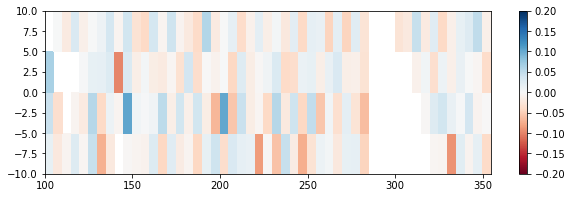

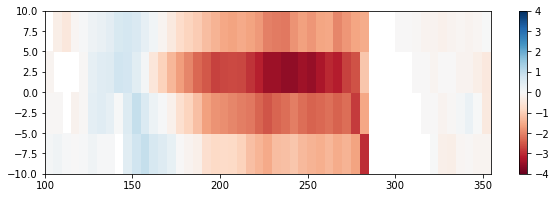

In [1440]:
#Make diagonal matrix of g (again, if not done before)
g_diag = np.zeros((LIMER.static_feat.numpy().shape[0], LIMER.static_feat.numpy().shape[0]), complex)
np.fill_diagonal(g_diag, g)

#Define Green's function at the peak of the max amplification growth
G_tau           = np.dot(u,np.dot((g_diag)**(Tau_peak/tau0),np.transpose(v)))

# ---- EOF analysis of GtG ---- #
GTG = np.dot(np.transpose(G_tau),G_tau)

eigVal_GTG, eigVec_GTG = LA.eig(GTG)

#Sort the eigenvalues in order 
iSort_GTG  = eigVal_GTG.argsort()[::-1]   
eigVal_GTG = eigVal_GTG[iSort_GTG] 
eigVec_GTG = eigVec_GTG[:,iSort_GTG]

#The optimal structure is the first eigenVector of the matrix GtG. 
optimStruct = eigVec_GTG[:,0].real

#Get the forecast by projecting G(tau) onto that optimal structure 
forecast = np.dot(G_tau.real,optimStruct)

opty_heat = xr.DataArray(np.zeros((len(lats), len(lons)))*np.nan, coords=[("lat", lats), ("lon", lons)])
opty_for = xr.DataArray(np.zeros((len(lats), len(lons)))*np.nan, coords=[("lat", lats), ("lon", lons)])

for node, (lat_i, lon_i) in enumerate(cords[:-1]):
    opty_heat.loc[lat_i, lon_i] = optimStruct[node]
    opty_for.loc[lat_i, lon_i] = forecast[node]
    
    
plt.figure(figsize=(10,3))
plt.pcolor(lons,lats,opty_heat.data,vmin=-.2,vmax=.2,cmap='RdBu')
plt.colorbar()
plt.show()

plt.figure(figsize=(10,3))
plt.pcolor(lons,lats,opty_for.data,vmin=-4,vmax=4,cmap='RdBu')
plt.colorbar()
plt.show()

In [1438]:
b_alpha,L,Q,G,c0,cT,u,v,g,periods,decayT = LIM(static_feats,1)


maxAmp=8
#Make diagonal matrix of g
g_diag = np.zeros((nDat, nDat), complex)
np.fill_diagonal(g_diag, g)
#Define Green's function at the peak of the max amplification growth (13 days in this case)
G_tau           = np.dot(u,np.dot((g_diag)**(maxAmp/tau0),np.transpose(v)))

# ---- EOF analysis of GtG ---- #
matr = np.dot(np.transpose(G_tau),G_tau)

eigVal_GTG, eigVec_GTG = LA.eig(matr)

#Sort the eigenvalues in order 
iSort_GTG  = eigVal_GTG.argsort()[::-1]   
eigVal_GTG = eigVal_GTG[iSort_GTG] 
eigVec_GTG = eigVec_GTG[:,iSort_GTG]

#The optimal structure is the first eigenVector of the matrix GtG. 
optimStruct = eigVec_GTG[:,0].real

#Get the forecast by projecting G(tau) onto that optimal structure 
forecastStruct = np.dot(G_tau.real,optimStruct)

my way
my way


/Users/wchapman/opt/miniconda3/envs/HeatTorch/lib/python3.7/site-packages/ipykernel_launcher.py:87: RuntimeWarning: divide by zero encountered in true_divide


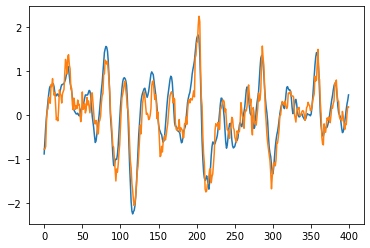

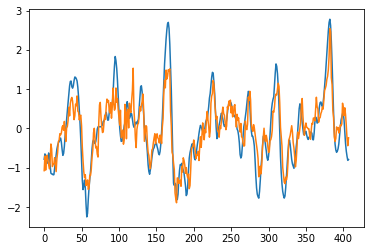

array([[1.        , 0.87549958],
       [0.87549958, 1.        ]])

In [33]:
_, val_stats,preddd,trr = evaluate_LIM(valloader,best_model_lim, device=device,return_preds=True)
plt.plot(preddd[0:400])
plt.plot(trr[0:400])
plt.show()

_, val_stats,preddd,trr = evaluate_LIM(testloader,best_model_lim, device=device,return_preds=True)
plt.plot(preddd[0:])
plt.plot(trr[0:])
plt.show()
np.corrcoef(preddd[0:400],trr[0:400])


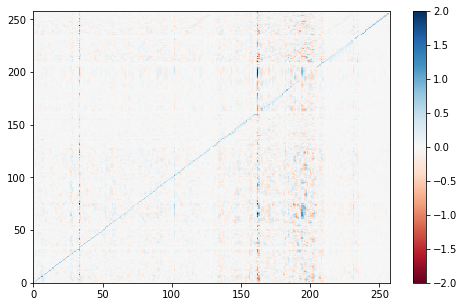

In [42]:
plt.figure(figsize=(8,5))
plt.pcolor(best_model_lim.adj,cmap='RdBu',vmin=-2,vmax=2)
plt.colorbar()
plt.show()

In [114]:
class LIMG(nn.Module):
    def __init__(self, num_nodes, max_num_edges, dim, static_feat, device='cpu', alpha1=0.1, alpha2=2.0,
                 self_loops=True):
        super().__init__()
        if static_feat is None:
            raise ValueError("Please give static node features (e.g. part of the timeseries)")
        self.num_nodes = num_nodes
        xd = static_feat.shape[1]
        tlag = 1
        x0=static_feat[:,0:-tlag]
        x1=static_feat[:,tlag:]
        
        xd = x0.shape[1]
        #covariance structrure
        self.lin1 = nn.Linear(xd, dim)
        self.lin2 = nn.Linear(xd, dim)
        self.linlag1 = nn.Linear(xd, dim)
        self.linlag2 = nn.Linear(xd, dim)
        
        self.static_feat = x0 if isinstance(x0, torch.Tensor) else torch.from_numpy(x0)
        self.static_feat = self.static_feat.to(torch.float64).to(device)
        
        #lagged feature
        self.static_feat1 = x1 if isinstance(x1, torch.Tensor) else torch.from_numpy(x1)
        self.static_feat1 = self.static_feat1.to(torch.float64).to(device)

        self.device = device
        self.dim = dim
        self.alpha1 = alpha1
        self.alpha2 = alpha2
        self.num_edges = max_num_edges
        self.self_loops = self_loops
        self.diag = torch.eye(self.num_nodes).bool().to(device)

    def forward(self):
        #covariance structure
        nodevec1 = self.static_feat
        nodevec2 = self.static_feat      
        #lagged covariance structure
        nodevec11 = self.static_feat
        nodevec21 = self.static_feat1
        
        adj = (nodevec21 @ nodevec11.T)@(torch.linalg.pinv(nodevec1 @ nodevec1.T))
        
#         adj = adj.flatten()
#         mask = torch.zeros(self.num_nodes * self.num_nodes).to(self.device)
#         _, strongest_idxs = torch.topk(adj, self.num_edges)  # Adj to get the strongest weight value indices
#         mask[strongest_idxs] = 1
#         adj = adj * mask
#         adj = adj.reshape((self.num_nodes, self.num_nodes))
#         if self.self_loops:
#             adj[self.diag] = adj[self.diag].clamp(min=0.5)

        return adj

    def NoiseQ(self):
        #covariance structure
        nodevec1 = self.static_feat
        nodevec2 = self.static_feat      
        #lagged covariance structure
        nodevec11 = self.static_feat
        nodevec21 = self.static_feat1
        
        
        G_1 = (nodevec21 @ nodevec11.T)@(torch.linalg.pinv(nodevec1 @ nodevec1.T))

        x0_c = nodevec1.T
        C0 = x0_c.T @ x0_c / (x0_c.shape[0] - 1) 

        G_eval, G_evects = torch.linalg.eig(G_1)
        L_evals = (1/tau) * torch.log(G_eval)
        L = G_evects @ torch.diag(L_evals) @ torch.linalg.pinv(G_evects)
        Q = -(L @ C0 + C0 @ L.H)  # Noise covariance
        return Q

## Fit Noise

In [43]:
(adj, static_feats, _), (trainloader,valloader,testloader) = get_dataloaders(params, net_params)
static_feats = static_feats[:,2:]
static_feats = np.concatenate([static_feats[:,:int(static_feats.shape[1]/2)],static_feats[:,int(static_feats.shape[1]/2):]])


/Users/wchapman/opt/miniconda3/envs/HeatTorch/lib/python3.7/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/Users/wchapman/opt/miniconda3/envs/HeatTorch/lib/python3.7/site-packages/numpy/core/_asarray.py:83: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)
/Users/wchapman/opt/miniconda3/envs/HeatTorch/lib/python3.7/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/Users/

MASKING OUT 7 nodes
Train set: 36132 Validation set 600 Test set 408


In [134]:
tlag=1
x0=static_feats[:,0:-tlag]
x1=static_feats[:,tlag:]
nodevec1 = x0
nodevec2 = x0
#lagged covariance structure
nodevec11 = x0
nodevec21 = x1
G_1 = (nodevec21 @ nodevec11.T)@(pinv(nodevec1 @ nodevec1.T))


x0_c = static_feats.T[0:-tlag,:]

C0 = x0_c.T @ x0_c / (x0_c.shape[0] - 1) 

G_eval, G_evects = eig(G_1)
L_evals = (1/tau) * np.log(G_eval)
L = G_evects @ np.diag(L_evals) @ pinv(G_evects)
L = np.matrix(L)
Q = -(L @ C0 + C0 @ L.H)  # Noise covariance

#Check if ! is Hermetian
is_adj = abs(Q - Q.H)


In [90]:
max_neg_evals=25

C0 = x0_c.T @ x0_c / (x0_c.shape[0] - 1) 
G_eval, G_evects = eig(G_1)
L_evals = (1/tau) * np.log(G_eval)
L = G_evects @ np.diag(L_evals) @ pinv(G_evects)
L = np.matrix(L)
Q = -(L @ C0 + C0 @ L.H)  # Noise covariance

# Check if Q is Hermetian
is_adj = abs(Q - Q.H)
tol = 1e-10
if np.any(abs(is_adj) > tol):
    raise ValueError('Determined Q is not Hermetian (complex ''conjugate transpose is equivalent.)')
    
q_evals, q_evects = eigh(Q)
sort_idx = q_evals.argsort()
q_evals = q_evals[sort_idx][::-1]
q_evects = q_evects[:, sort_idx][:, ::-1]
num_neg = (q_evals < 0).sum()

if num_neg > 0:
    num_left = len(q_evals) - num_neg
    if num_neg > max_neg_evals:
        print('Found {:d} modes with negative eigenvalues in'
                             ' the noise covariance term, Q.'.format(num_neg))
        raise ValueError('More than {:d} negative eigenvalues of Q '
                                 'detected.  Consider further dimensional '
                                 'reduction.'.format(max_neg_evals))

    else:
        print('Removing negative eigenvalues and rescaling {:d} '
                            'remaining eigenvalues of Q.'.format(num_left))
        pos_q_evals = q_evals[q_evals > 0]
        scale_factor = q_evals.sum() / pos_q_evals.sum()
        print('Q eigenvalue rescaling: {:1.2f}'.format(scale_factor))

        q_evals = q_evals[:-num_neg]*scale_factor
        q_evects = q_evects[:, :-num_neg]
else:
    scale_factor = None
    
# Change back to arrays
L = np.array(L)
q_evects = np.array(q_evects)

Removing negative eigenvalues and rescaling 238 remaining eigenvalues of Q.
Q eigenvalue rescaling: 0.78


In [71]:
def save_model(epochs, model, optimizer, criterion,strpath):
    """
    Function to save the trained model to disk.
    """
    print(f"Saving final model...")
    torch.save({
                'epoch': epochs,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': criterion,
                }, strpath)
    
    
save_model(20,best_model_lim,optimizer,criterion,'/glade/work/wchapman/HeatGCN/Heater/saved_models/LIM_best.pth')
bb = torch.load('/glade/work/wchapman/HeatGCN/Heater/saved_models/LIM_best.pth')
model = nlim(net_params, params,static_feat=static_feats, adj=adj)
model.load_state_dict(bb['model_state_dict'])

Saving final model...
[GraphConvolution (6 -> 250), GraphConvolution (250 -> 100)]


<All keys matched successfully>

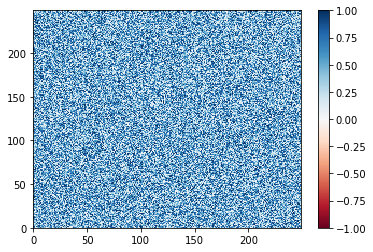

In [67]:
plt.pcolor(best_model_lim.Gbias.cpu().data.numpy(),vmin=-1,vmax=1,cmap='RdBu')
plt.colorbar()

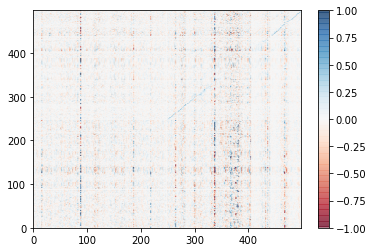

In [74]:
plt.pcolor(best_model_lim.Gpow.cpu().data.numpy(),vmin=-1,vmax=1,cmap='RdBu',alpha=0.5)
plt.colorbar()

# LIMG with PCs

In [13]:
import torch
import torch.nn as nn
# from graphino.readout_MLP import ONI_MLP
# from graphino.GCN.graph_conv_layer import GraphConvolution
# from graphino.structure_learner import EdgeStructureLearner
# from utilities.utils import get_activation_function
class nlim(nn.Module):
    def __init__(self, net_params,params, static_feat=None, adj=None, device="cpu", outsize=1, verbose=True):
        super().__init__()
        self.L = net_params['L']
        assert self.L > 1
        self.act = net_params['activation']
        self.out_dim = self.mlp_input_dim = net_params['out_dim']
        self.batch_norm = net_params['batch_norm']
        self.graph_pooling = net_params['readout'].lower()
        self.jumping_knowledge = net_params['jumping_knowledge']
        self.tau = params['horizon']
        self.device=device
        self.numpreds = static_feats.shape[0]
        self.num_eofs = 100
        
        self.Gbias = nn.Parameter(torch.rand(self.num_eofs,self.num_eofs),requires_grad=True)
        dropout = net_params['dropout']
        hid_dim = net_params['hidden_dim']
        num_nodes = net_params['num_nodes']
        activation = get_activation_function(self.act, functional=True, num=1, device=device)
        conv_kwargs = {'activation': activation, 'batch_norm': self.batch_norm,
                       'residual': net_params['residual'], 'dropout': dropout}
        
        
        layers = [GraphConvolution(net_params['in_dim'], hid_dim, **conv_kwargs)]
        layers += [GraphConvolution(hid_dim, hid_dim, **conv_kwargs) for _ in range(self.L - 2)]
        layers.append(GraphConvolution(hid_dim, self.out_dim, **conv_kwargs))
        
        self.layers = nn.ModuleList(layers)
        
        if self.jumping_knowledge:
            self.mlp_input_dim = self.mlp_input_dim + hid_dim * (self.L - 1)
        if self.graph_pooling in ['sum+mean', 'mean+sum', 'mean&sum', 'sum&mean']:
            self.mlp_input_dim = self.mlp_input_dim * 2
        self.MLP_layer = LIM_MLP(static_feats.shape[0], outsize, act_func=self.act, batch_norm=net_params['mlp_batch_norm'],
                                    dropout=dropout, device=device,L=4)
        if adj is None:
            self.adj, self.learn_adj = None, True
            max_num_edges = int(net_params['avg_edges_per_node'] * num_nodes)
            self.LIM_learner = LIMG_PC(50,50,50,device=device, static_feat=static_feat,num_eofs=self.num_eofs)
        else:
            print('Using a static connectivity structure !!!')
            self.adj, self.learn_adj = torch.from_numpy(adj).float().to(device), False

        if verbose:
            print([x for x in self.layers])

    def get_adj(self):
        if self.learn_adj:
            return self.LIM_learner.forward()
        return self.adj


    def forward(self, input, readout=True):
        if self.learn_adj:
            # Generate an adjacency matrix/connectivity structure for the graph convolutional forward pass
            self.adj = self.LIM_learner.forward()
            self.Gpow_pure = torch.linalg.matrix_power(self.adj, self.tau)
            self.Gpow = torch.linalg.matrix_power(self.adj, self.tau)
            self.Gpow = self.Gpow #+ self.Gbias
            
            #project input space onto pcs. 
            Forecast_inits =torch.cat((input[:,0,-1,:].to(torch.float64).to(self.device),input[:,1,-1,:].to(torch.float64).to(self.device)),1)
#             Forecast_inits = (torch.from_numpy(static_feats)[:,-64:]).T #input must be timexspace dimensions
            proj_pcs = Forecast_inits@self.LIM_learner.eofs.T.to(torch.float64).to(self.device) #project the dataset onto the EOFS using a matrix mult.
            for_pcs_space = torch.mm(self.Gpow,proj_pcs.T)
            self.xfor = for_pcs_space.T@self.LIM_learner.eofs.to(torch.float64).to(self.device)
            out = self.MLP_layer(self.xfor.float())
            
        return  out

#     def graph_embedding_to_pred(self, g_emb):
#         out = self.MLP_layer.forward(g_emb).squeeze(1)
#         return out


import torch
import torch.nn as nn
torch.manual_seed(0)
import random
random.seed(0)

class LIMG(nn.Module):
    def __init__(self, num_nodes, max_num_edges, dim, static_feat, device='cpu', alpha1=0.1, alpha2=2.0,
                 self_loops=True):
        super().__init__()
        if static_feat is None:
            raise ValueError("Please give static node features (e.g. part of the timeseries)")
        self.num_nodes = num_nodes
        xd = static_feat.shape[1]
        tlag = 1
        x0=static_feat[:,0:-tlag]
        x1=static_feat[:,tlag:]
        
        xd = x0.shape[1]
        #covariance structrure
        self.lin1 = nn.Linear(xd, dim)
        self.lin2 = nn.Linear(xd, dim)
        self.linlag1 = nn.Linear(xd, dim)
        self.linlag2 = nn.Linear(xd, dim)
        
        self.static_feat = x0 if isinstance(x0, torch.Tensor) else torch.from_numpy(x0)
        self.static_feat = self.static_feat.to(torch.float64).to(device)
        
        #lagged feature
        self.static_feat1 = x1 if isinstance(x1, torch.Tensor) else torch.from_numpy(x1)
        self.static_feat1 = self.static_feat1.to(torch.float64).to(device)

        self.device = device
        self.dim = dim
        self.alpha1 = alpha1
        self.alpha2 = alpha2
        self.num_edges = max_num_edges
        self.self_loops = self_loops
        self.diag = torch.eye(self.num_nodes).bool().to(device)

    def forward(self):
        #covariance structure
        nodevec1 = self.static_feat
        nodevec2 = self.static_feat      
        #lagged covariance structure
        nodevec11 = self.static_feat
        nodevec21 = self.static_feat1
        
        adj = (nodevec21 @ nodevec11.T)@(torch.linalg.pinv(nodevec1 @ nodevec1.T))
        
#         adj = adj.flatten()
#         mask = torch.zeros(self.num_nodes * self.num_nodes).to(self.device)
#         _, strongest_idxs = torch.topk(adj, self.num_edges)  # Adj to get the strongest weight value indices
#         mask[strongest_idxs] = 1
#         adj = adj * mask
#         adj = adj.reshape((self.num_nodes, self.num_nodes))
#         if self.self_loops:
#             adj[self.diag] = adj[self.diag].clamp(min=0.5)

        return adj


class LIMG_PC(nn.Module):
    def __init__(self, num_nodes, max_num_edges, dim, static_feat, device='cpu', alpha1=0.1, alpha2=2.0,
                 self_loops=True,num_eofs=100):
        super().__init__()
        if static_feat is None:
            raise ValueError("Please give static node features (e.g. part of the timeseries)")
        self.num_nodes = num_nodes
        
        A, Lh, E = torch.linalg.svd(torch.from_numpy(static_feats).T)
        A = A[:, :len(Lh)] #trim the time field (in case time > space)
        A = A[:, :len(Lh)] #trim the time field (in case time > space)
        PCs = A*Lh
        select_neofs=22
        self.select_neofs=num_eofs
        
        # normalize time series and scale in singular values to retain variance
        self.eofs = E[:self.select_neofs,:]
        n=torch.var(self.eofs,axis=1)
        self.eofs=self.eofs/torch.unsqueeze(n,dim=1)
    
        self.PCS=PCs[:,:self.select_neofs]
        self.PCS = self.PCS*torch.unsqueeze(n,dim=1).T*Lh[:self.select_neofs]
        self.eig_vals=Lh
        
        A, Lh, E = torch.linalg.svd(torch.from_numpy(static_feats).T)
        A = A[:, :len(Lh)] #trim the time field (in case time > space)
        A = A[:, :len(Lh)] #trim the time field (in case time > space)
        
        self.var_explained=(Lh*Lh)/(torch.sum(Lh*Lh))
        tau0_data = (self.PCS[:,:self.select_neofs].T)
        
        tlag = 1
        x0=tau0_data[:,0:-tlag]
        x1=tau0_data[:,tlag:]
        
        #covariance structrure
        self.static_feat = x0 if isinstance(x0, torch.Tensor) else torch.from_numpy(x0)
        self.static_feat = self.static_feat.to(torch.float64).to(device)
        
        #lagged feature
        self.static_feat1 = x1 if isinstance(x1, torch.Tensor) else torch.from_numpy(x1)
        self.static_feat1 = self.static_feat1.to(torch.float64).to(device)

        self.device = device
        self.dim = dim
        self.alpha1 = alpha1
        self.alpha2 = alpha2
        self.num_edges = max_num_edges
        self.self_loops = self_loops
        self.diag = torch.eye(self.num_nodes).bool().to(device)

    def forward(self):
        #covariance structure
        nodevec1 = self.static_feat
        nodevec2 = self.static_feat      
        #lagged covariance structure
        nodevec11 = self.static_feat
        nodevec21 = self.static_feat1
        
        adj = (nodevec21 @ nodevec11.T)@(torch.linalg.pinv(nodevec1 @ nodevec1.T))
        

        return adj
    
    def forward_params(self):
        #covariance structure
        nodevec1 = self.static_feat
        nodevec2 = self.static_feat      
        #lagged covariance structure
        nodevec11 = self.static_feat
        nodevec21 = self.static_feat1
        
        cT = (nodevec21 @ nodevec11.T)/(nodevec11.shape[1]-1)
        c0 = (nodevec1 @ nodevec1.T)/(nodevec11.shape[1]-1)
#         G = (nodevec21 @ nodevec11.T)@(torch.linalg.pinv(nodevec1 @ nodevec1.T))

        G = (cT.numpy())@(np.linalg.pinv(c0.numpy()))

        g, u = np.linalg.eig(G)
        
        #sort the eigenvecs
        iSort = g.argsort()[::-1]    #Sort the eigen values and vectors in order 
        g     = g[iSort]
        u     = u[:,iSort]         
        
        
        # Define the adjoints (v) based on the transpose of G 
        eigVal_T, v = np.linalg.eig(np.transpose(G))
#         iSortT      = torch.flip(eigVal_T.real.argsort(), dims=(0,))
        iSortT = eigVal_T.argsort()[::-1]
        eigVal_T    = eigVal_T[iSortT]
        v           = v[:,iSortT] 
        
        # But modes should ultimately be sorted by decreasing decay time (i.e., decreasing values of 1/beta.real) 

        # Compute Beta 
        
        b_tau   = np.log(g)
        b_alpha = b_tau/lag
        
        
        # Sort data by decreasing decay time 
        sortVal = -1/b_alpha.real              #Decay time  

        
        
#         iSort2 =torch.flip(sortVal.argsort(), dims=(0,))
        iSort2 = sortVal.argsort()[::-1]
        u      = u[:,iSort2]
        v      = v[:,iSort2]
        g      = g[iSort2]
        b_alpha = b_alpha[iSort2]
        
        nDat = G.shape[0]
        # Make diagonal array of Beta (values should be negative)
#         beta = torch.zeros((nDat, nDat), dtype=torch.cdouble)
#         beta.fill_diagonal_(b_alpha)
        
        beta = np.zeros((nDat, nDat), dtype=complex)
        mask = np.diag(np.ones_like(b_alpha))
        beta = mask*np.diag(b_alpha) + (1. - mask)*beta
        
        #Need to normalize u so that u_transpose*v = identitity matrix, and u*v_transpose = identity matrix as well 
        normFactors = (u.T@v)
        normU       = (u@np.linalg.inv(normFactors))
        
        # STEP 3: Compute L and Q matrices 

        # Compute L matrix as normU * beta * v_transpose 
        L = np.dot(normU, np.dot(beta, np.transpose(v)))
    
        # Compute Q matrix 
        Q_negative = np.dot(L, c0) + np.dot(c0, np.transpose(L))
        Q = -Q_negative 

        # Also define the periods and decay times 
        # Also define the periods and decay times 
        periods = (2 * np.pi) / b_alpha.imag 
        decayT  = -1 / b_alpha.real 
        
        device ='cpu'
        b_alpha=torch.from_numpy(b_alpha).cdouble().to(device)
        L=torch.from_numpy(L).cdouble().to(device)
        Q=torch.from_numpy(Q).cdouble().to(device)
        G=torch.from_numpy(G).cdouble().to(device)
        normU=torch.from_numpy(normU).cdouble().to(device)
        v=torch.from_numpy(v).cdouble().to(device)
        g=torch.from_numpy(g).cdouble().to(device)
        periods=torch.from_numpy(periods).float().to(device)
        decayT=torch.from_numpy(decayT).float().to(device)
        
        
        
        return b_alpha, L, Q, G, c0, cT, normU, v, g, periods, decayT, nodevec11, nodevec21

class EdgeStructureLearner(nn.Module):
    def __init__(self, num_nodes, max_num_edges, dim, static_feat, device='cpu', alpha1=0.1, alpha2=2.0,
                 self_loops=True):
        super().__init__()
        if static_feat is None:
            raise ValueError("Please give static node features (e.g. part of the timeseries)")
        self.num_nodes = num_nodes
        xd = static_feat.shape[1]
        self.lin1 = nn.Linear(xd, dim)
        self.lin2 = nn.Linear(xd, dim)
        self.static_feat = static_feat if isinstance(static_feat, torch.Tensor) else torch.from_numpy(static_feat)
        self.static_feat = self.static_feat.float().to(device)

        self.device = device
        self.dim = dim
        self.alpha1 = alpha1
        self.alpha2 = alpha2
        self.num_edges = max_num_edges
        self.self_loops = self_loops
        self.diag = torch.eye(self.num_nodes).bool().to(device)

    def forward(self):
        nodevec1 = torch.tanh(self.alpha1 * self.lin1(self.static_feat))
        nodevec2 = torch.tanh(self.alpha1 * self.lin2(self.static_feat))

        adj = torch.sigmoid(self.alpha2 * nodevec1 @ nodevec2.T)
        adj = adj.flatten()
        mask = torch.zeros(self.num_nodes * self.num_nodes).to(self.device)
        _, strongest_idxs = torch.topk(adj, self.num_edges)  # Adj to get the strongest weight value indices
        mask[strongest_idxs] = 1
        adj = adj * mask
        adj = adj.reshape((self.num_nodes, self.num_nodes))
        if self.self_loops:
            adj[self.diag] = adj[self.diag].clamp(min=0.5)
        return adj



class nonLIMG(nn.Module):
    def __init__(self, num_nodes, max_num_edges, dim, static_feat, device='cpu', alpha1=0.1, alpha2=2.0,
                 self_loops=True):
        super().__init__()
        if static_feat is None:
            raise ValueError("Please give static node features (e.g. part of the timeseries)")
        self.num_nodes = num_nodes
        xd = static_feat.shape[1]
        tlag = 1
        x0=static_feat[:,0:-tlag]
        x1=static_feat[:,tlag:]
        
        xd = x0.shape[1]
        #covariance structrure
        self.lin1 = nn.Linear(xd, dim)
        self.lin2 = nn.Linear(xd, dim)
        self.linlag1 = nn.Linear(xd, dim)
        self.linlag2 = nn.Linear(xd, dim)
        
        self.static_feat = x0 if isinstance(x0, torch.Tensor) else torch.from_numpy(x0)
        self.static_feat = self.static_feat.to(torch.float64).to(device)
        
        #lagged feature
        self.static_feat1 = x1 if isinstance(x1, torch.Tensor) else torch.from_numpy(x1)
        self.static_feat1 = self.static_feat1.to(torch.float64).to(device)

        self.device = device
        self.dim = dim
        self.alpha1 = alpha1
        self.alpha2 = alpha2
        self.num_edges = max_num_edges
        self.self_loops = self_loops
        self.diag = torch.eye(self.num_nodes).bool().to(device)

    def forward(self):
        #covariance structure
        nodevec1 = self.lin1(self.static_feat.to(torch.float32).to(device))
        nodevec2 = self.lin2(self.static_feat.to(torch.float32).to(device))    
        #lagged covariance structure
        nodevec11 = self.linlag1(self.static_feat.to(torch.float32).to(device))
        nodevec21 = self.linlag2(self.static_feat.to(torch.float32).to(device))
        
        adj = (nodevec21 @ nodevec11.T)@(torch.linalg.pinv(nodevec1 @ nodevec1.T))
        return adj
    
    
    
    

class LIM_MLP(nn.Module):
    """
    Fully connected MLP on top of node embeddings
    L - number of hidden layers, each of those having half the number of neurons than the previous one.
    """
    def __init__(self, input_dim, output_dim, dropout=0, L=2, batch_norm=True, act_func='elu', device='cpu'):
        super().__init__()
        FC_layers = []
        for l in range(L):
            out_dim_l = input_dim // 2 ** (l + 1)
            FC_layers.append(
                nn.Linear(input_dim // 2 ** l, out_dim_l, bias=True,device=device)
            )
            if batch_norm:
                FC_layers.append(nn.BatchNorm1d(out_dim_l,device=device))
            FC_layers.append(get_activation_function(act_func, device=device))
            if dropout > 0:
                FC_layers.append(nn.Dropout(dropout))

        self.FC_layers = nn.ModuleList(FC_layers)
        self.out_dim_last_L = input_dim // 2 ** L
        self.out_layer = nn.Linear(self.out_dim_last_L, output_dim, bias=True,device=device)
        self.L = L

    def forward(self, x):
        x=x.to(torch.float32)
        for module in self.FC_layers:
            x = module(x.to(torch.float32))
        y = self.out_layer(x)
        return y


def train_epoch_LIM(dataloader, model, criterion, optims, device, epoch, nth_step=100):
    if not isinstance(optims, list):
        optims = [optims]
    model.train()
    total_loss = 0
    for iter, (X, Y) in enumerate(dataloader, 1):
        X, Y = X.to(device), Y.to(device)
        Y=Y.unsqueeze(dim=1)
        for optim in optims:
            optim.zero_grad()        
#         X = X.reshape((X.shape[0], -1, X.shape[3])).transpose(1, 2)  # shape = (batch_size x #features x #nodes)
        preds = model(X)
        loss = criterion(preds, Y)
        loss.backward()
        
        for optim in optims:
            optim.step()
        total_loss += loss.item()
    num_edges = torch.count_nonzero(model.adj.detach()).item()
    return total_loss / iter, num_edges



def train_epoch(dataloader, model, criterion, optims, device, epoch, nth_step=100):
    if not isinstance(optims, list):
        optims = [optims]
    model.train()
    total_loss = 0
    for iter, (X, Y) in enumerate(dataloader, 1):
        X, Y = X.to(device), Y.to(device)
        for optim in optims:
            optim.zero_grad()
        X = X.reshape((X.shape[0], -1, X.shape[3])).transpose(1, 2)  # shape = (batch_size x #features x #nodes)

        preds = model(X)
        loss = criterion(preds, Y)
        loss.backward()
        
        for optim in optims:
            optim.step()
        total_loss += loss.item()
    num_edges = torch.count_nonzero(model.adj.detach()).item()
    return total_loss / iter, num_edges

# Set Params # Set Params # Set Params # Set Params # Set Params # Set Params
# Set Params # Set Params # Set Params # Set Params # Set Params # Set Params
# Set Params # Set Params # Set Params # Set Params # Set Params # Set Params
# Set Params # Set Params # Set Params # Set Params # Set Params # Set Params

net_params ={'L': 2, 
         'num_nodes': 189, 
         'readout': 'mean', 
         'activation': 'ELU',
         'avg_edges_per_node': 8,
         'in_dim': 6,
         'adj_dim': 50,
         'jumping_knowledge': True, 
         'index_node': False, 
         'batch_norm': True, 
         'mlp_batch_norm': True, 
         'residual': True, 
         'self_loop': True, 
         'tanh_alpha': 0.1, 
         'sig_alpha': 2.0, 
         'dropout': 0.0,
         'hidden_dim': 250,
         'out_dim': 100}

params = {'horizon': 3,
 'window': 3,
 'lon_min': 0,
 'lon_max': 360,
 'lat_min': -30,
 'lat_max': 30,
 'model_dir': 'out/graphino/',
 'data_dir': 'Data//',
 'useCMIP5': True,
 'use_heat_content': True,
 'seed': 41,
 'shuffle': True,
 'epochs': 5,
 'batch_size': 32,
 'lr': 0.005,
 'nesterov': True,
 'weight_decay': 1e-06,
 'validation_frac': 0,
 'validation_set': 'cmip5',
 'loss': 'MSE',
 'optimizer': 'adam',
 'scheduler': 'No',
 'grid_edges': False}


(adj, static_feats, _), (trainloader,valloader,testloader) = get_dataloaders(params, net_params)
static_feats = static_feats[:,2:]
static_feats = np.concatenate([static_feats[:,:int(static_feats.shape[1]/2)],static_feats[:,int(static_feats.shape[1]/2):]])

# static_feats=static_feats[:,:2000]
model = nlim(net_params, params,static_feat=static_feats, adj=adj)
optimizer = get_optimizer(params['optimizer'], model, lr=params['lr'],weight_decay=params['weight_decay'], nesterov=params['nesterov'])
criterion = get_loss(params['loss'])




# Train model# Train model# Train model# Train model# Train model# Train model
# Train model# Train model# Train model# Train model# Train model# Train model
# Train model# Train model# Train model# Train model# Train model# Train model
# Train model# Train model# Train model# Train model# Train model# Train model

t_total = time.time()
device="cpu"
model = model.to(device)
val_stats = None
best_val_loss = cur_val = 1000

with tqdm(range(1, params['epochs'] + 1)) as t:
    for epoch in t:
        start_t = time.time()
        loss, num_edges = train_epoch_LIM(trainloader, model, criterion, optimizer, device, epoch)
        duration = time.time() - start_t
        if valloader is not None:
            # Note that the default 'validation set' is included in the training set (=SODA),
            # and is not used at all.
            _, val_stats = evaluate_LIM(valloader, model, device=device)
            _, train_stats = evaluate_LIM(trainloader, model, device=device)
            print('validation: ',val_stats)
            print('train: ',train_stats)
            
        update_tqdm(t, loss, n_edges=num_edges, time=duration, val_stats=val_stats)
        #save the best model....
        if epoch == 1:
            best_accuracy = val_stats['corrcoef']
            best_model_lim = copy.deepcopy(model)
        else:
            print(epoch)
            if best_accuracy > val_stats['corrcoef']:
                continue
            else:
                print('new best')
                best_accuracy = val_stats['corrcoef']
                best_model_lim = copy.deepcopy(model)

/glade/work/wchapman/miniconda3/envs/gputorch/lib/python3.7/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/glade/work/wchapman/miniconda3/envs/gputorch/lib/python3.7/site-packages/numpy/core/_asarray.py:83: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)
/glade/work/wchapman/miniconda3/envs/gputorch/lib/python3.7/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/glade/

Train set: 36132 Validation set 600 Test set 408
[GraphConvolution (6 -> 250), GraphConvolution (250 -> 100)]
Using Adam optimizer: Lr= 0.005 Wd= 1e-06


 20%|██        | 1/5 [00:23<01:32, 23.22s/it, n_edges=1e+4, time=18.4, train_loss=0.288, val_all_season_cc=0.889, val_corrcoef=0.89, val_mae=5.82, val_rmse=0.387]

validation:  {'corrcoef': 0.8900420813111206, 'rmse': 0.38674563, 'all_season_cc': 0.8894289631467668, 'mae': 5.818090632557869}
train:  {'corrcoef': 0.8513181525683912, 'rmse': 0.4369818, 'all_season_cc': 0.8511774048364339, 'mae': 383.15329556167126}


 40%|████      | 2/5 [00:45<01:07, 22.62s/it, n_edges=1e+4, time=17.3, train_loss=0.216, val_all_season_cc=0.904, val_corrcoef=0.9, val_mae=6.36, val_rmse=0.421]

validation:  {'corrcoef': 0.9001728334997567, 'rmse': 0.42055205, 'all_season_cc': 0.90398120993931, 'mae': 6.364457428455353}
train:  {'corrcoef': 0.8699007122124878, 'rmse': 0.4392498, 'all_season_cc': 0.8698607133847264, 'mae': 384.38349735736847}
2
new best


 60%|██████    | 3/5 [01:07<00:45, 22.60s/it, n_edges=1e+4, time=17.7, train_loss=0.188, val_all_season_cc=0.869, val_corrcoef=0.872, val_mae=5.59, val_rmse=0.375]

validation:  {'corrcoef': 0.872168662604176, 'rmse': 0.37473804, 'all_season_cc': 0.8687672957961042, 'mae': 5.590284436941147}
train:  {'corrcoef': 0.8675415819077019, 'rmse': 0.40586206, 'all_season_cc': 0.8675502421378015, 'mae': 353.1595920473337}
3


 80%|████████  | 4/5 [01:30<00:22, 22.63s/it, n_edges=1e+4, time=17.6, train_loss=0.177, val_all_season_cc=0.906, val_corrcoef=0.91, val_mae=4.8, val_rmse=0.329]

validation:  {'corrcoef': 0.9102569345644933, 'rmse': 0.32878044, 'all_season_cc': 0.9063614862496615, 'mae': 4.798890486359596}
train:  {'corrcoef': 0.8962284861698111, 'rmse': 0.38268608, 'all_season_cc': 0.8962015281236947, 'mae': 335.0968735218048}
4
new best


100%|██████████| 5/5 [01:54<00:00, 22.98s/it, n_edges=1e+4, time=18.7, train_loss=0.17, val_all_season_cc=0.9, val_corrcoef=0.901, val_mae=5.05, val_rmse=0.331]

validation:  {'corrcoef': 0.9010076954747697, 'rmse': 0.3307493, 'all_season_cc': 0.90031340702143, 'mae': 5.045865714550018}
train:  {'corrcoef': 0.8900869244476052, 'rmse': 0.37980998, 'all_season_cc': 0.890139445344892, 'mae': 332.1061147451401}
5


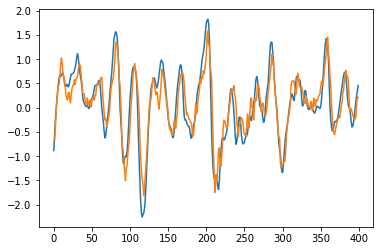

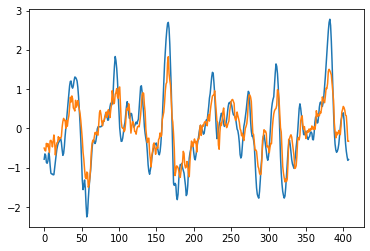

array([[1.        , 0.88799063],
       [0.88799063, 1.        ]])

In [23]:
_, val_stats,preddd,trr = evaluate_LIM(valloader,best_model_lim, device=device,return_preds=True)
plt.plot(preddd[0:400])
plt.plot(trr[0:400])
plt.show()

_, val_stats,preddd,trr = evaluate_LIM(testloader,best_model_lim, device=device,return_preds=True)
plt.plot(preddd[0:])
plt.plot(trr[0:])
plt.show()
np.corrcoef(preddd[0:400],trr[0:400])


In [2230]:
import json

with open('/Users/wchapman/Desktop/DeepLIM/configs/DLIM_config.json', 'r') as f:
    coco = json.load(f)
params, net_params = coco['params'], coco['net_params']

bb = torch.load('/Users/wchapman/Desktop/DeepLIM/out/1lead/config/LIM_seed_22_optimizer_adam_loss_MSE.pth')
model22 = nlim(net_params, params,static_feat=static_feats, adj=adj)
model22.load_state_dict(bb['model_state_dict'])


bb = torch.load('/Users/wchapman/Desktop/DeepLIM/out/2lead/config/LIM_seed_42_optimizer_adam_loss_MSE.pth')
model41 = nlim(net_params, params,static_feat=static_feats, adj=adj)
model41.load_state_dict(bb['model_state_dict'])

[GraphConvolution (6 -> 250), GraphConvolution (250 -> 100)]
[GraphConvolution (6 -> 250), GraphConvolution (250 -> 100)]


<All keys matched successfully>

In [2231]:
bb['args']

"Namespace(data_dir='Data/', epochs=15, gpu_id=-1, grid_edges='false', horizon=2, lr=None, optim='adam', out='out', seed=42, weight_decay=None)"

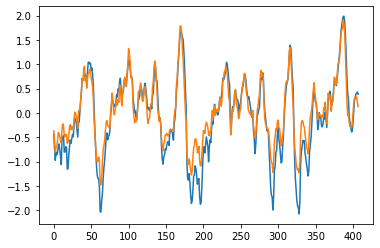

array([[1.        , 0.47916399],
       [0.47916399, 1.        ]])

In [2217]:
_, val_stats,preddd41,trr41 = evaluate_LIM(testloader,model41, device=device,return_preds=True)
# plt.plot(preddd[0:])
plt.plot(trr41[0:])

_, val_stats,preddd22,trr22 = evaluate_LIM(testloader,model22, device=device,return_preds=True)
# plt.plot(preddd[0:])
plt.plot(trr22[0:])

model41
plt.show()
np.corrcoef(preddd[0:400],trr[0:400])


In [2195]:
# _, val_stats,preddd,trr = evaluate_LIM(valloader,best_model_lim, device=device,return_preds=True)
# plt.plot(preddd[0:400])
# plt.plot(trr[0:400])
# plt.show()

# _, val_stats,preddd,trr = evaluate_LIM(testloader,best_model_lim, device=device,return_preds=True)
# plt.plot(preddd[0:])
# plt.plot(trr[0:])
# plt.show()
# np.corrcoef(preddd[0:400],trr[0:400])


1199 shape
complex128
...plotting...
T0 = 1  days; Peak growth =  [9]  month


/Users/wchapman/opt/miniconda3/envs/HeatTorch/lib/python3.7/site-packages/ipykernel_launcher.py:309: RuntimeWarning: divide by zero encountered in true_divide
/Users/wchapman/opt/miniconda3/envs/HeatTorch/lib/python3.7/site-packages/ipykernel_launcher.py:94: RuntimeWarning: divide by zero encountered in true_divide
/Users/wchapman/opt/miniconda3/envs/HeatTorch/lib/python3.7/site-packages/ipykernel_launcher.py:33: ComplexWarning: Casting complex values to real discards the imaginary part


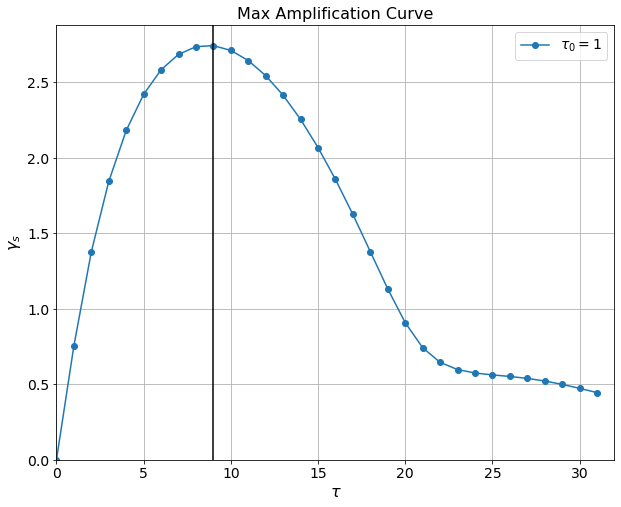

In [2114]:
GG = LIMG_PC(50,50,50,device=device, static_feat=static_feats,num_eofs=10)
b_alpha, L, Q, G, c0, cT, u, v, g, periods, decayT,n1,n2 = GG.forward_params()
b_alpha__,L__,Q__,G__,c0__,cT__,u__,v__,g__,periods__,decayT__ = LIM(n1.numpy(), tau0)

print('...plotting...')
#Define range of days to determine amplification for 
tau_arr = np.arange(31)+1   #Start at day 1, not day 0 

gamma1  = np.full([len(tau_arr)],np.nan)  #Empty array to store leading eigenvalue in 

#Get diagonal matrix of g 
g_diag = np.zeros((G.shape[0], G.shape[0]), complex)
np.fill_diagonal(g_diag, g)

tau0=1

#Check G(tau) for each value in tau_arr given tau0 
for iLag in range(len(tau_arr)):
    G_tau = np.dot(u,np.dot((g_diag)**(tau_arr[iLag]/tau0),np.transpose(v)))
    G_tau_fake = np.linalg.matrix_power(G.numpy(),(int(tau_arr[iLag]/tau0)))
    # ---- EOF analysis of GtG ---- #
    GTG = np.dot(np.transpose(G_tau),G_tau)

    eigVal_GTG, eigVec_GTG = np.linalg.eig(GTG)

    #Sort the eigenvalues in order 
    iSort_GTG  = eigVal_GTG.argsort()[::-1]   
    eigVal_GTG = eigVal_GTG[iSort_GTG]
    eigVec_GTG = eigVec_GTG[:,iSort_GTG]

    #Save first eigen value for this Tau (the maximum growing mode)
#     print(gamma1)
    gamma1[iLag] = np.log(eigVal_GTG[0])

#Insert a value of zero for day zero (initial conditions = no amplification)
gamma_all = np.insert(gamma1, 0, 0)


print('T0 =', tau0,' days; Peak growth = ',np.where(gamma_all==np.max(gamma_all))[0],' month')
# Define the lag associated with the maximum amplification (Tau_peak)
Tau_peak = int(np.where(gamma_all==np.max(gamma_all))[0])

# Set up figure window 
fig, ax1  = plt.subplots()
fig.set_size_inches(10,8)

# Plot leading eigenvalue     
ax1.plot(np.arange(32),gamma_all,'o-')
ax1.set_xlim([0,32])
ax1.set_ylim([np.min(gamma_all)*1.05,np.max(gamma_all)*1.05])  #Extend to 5% above maximum value

ax1.set_xlabel(r'$\tau $',fontsize=16)
ax1.set_ylabel(r'$\gamma_s $',fontsize=16)
ax1.grid()
ax1.axvline(Tau_peak,color='k')
ax1.set_title('Max Amplification Curve',fontsize=16)
ax1.legend([r'$\tau_0 = $'+str(tau0)],fontsize=14)
ax1.tick_params(labelsize=14)


## Optimal Structure

## Set lat/lons

In [2115]:
load_data_kwargs = {
        'window': params['window'], 'lead_months': params['horizon'], 'lon_min': params['lon_min'],
        'lon_max': params['lon_max'], 'lat_min': params['lat_min'], 'lat_max': params['lat_max'],
        'data_dir': params['data_dir'], 'use_heat_content': params['use_heat_content'],
        'add_index_node': net_params['index_node']
    }
cmip5, SODA, GODAS, cords, cnn_mask = load_cnn_data(**load_data_kwargs, return_new_coordinates=True, return_mask=True)
dinny = np.zeros(cnn_mask[:-1].shape)*np.nan
# dinny[cnn_mask[:-1]] = best_model_lim.LIM_learner.eofs[0,:-1]

lats=np.unique(SODA[0].lat)
lons=np.unique(SODA[0].lon)


/Users/wchapman/opt/miniconda3/envs/HeatTorch/lib/python3.7/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/Users/wchapman/opt/miniconda3/envs/HeatTorch/lib/python3.7/site-packages/numpy/core/_asarray.py:83: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)
/Users/wchapman/opt/miniconda3/envs/HeatTorch/lib/python3.7/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/Users/

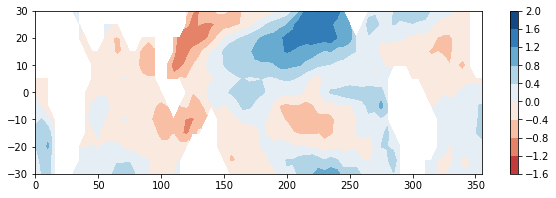

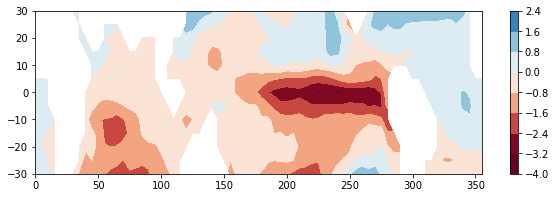

In [2116]:
# #Make diagonal matrix of g (again, if not done before)
g_diag = np.zeros((G.shape[0], G.shape[0]), complex)
np.fill_diagonal(g_diag, g)

#Define Green's function at the peak of the max amplification growth
G_tau           = np.dot(normU,np.dot((g_diag)**(Tau_peak/tau0),np.transpose(v)))


# G_tau = np.linalg.matrix_power(G.numpy(),(int(tau_arr[iLag]/tau0)))

# ---- EOF analysis of GtG ---- #
GTG = np.dot(np.transpose(G_tau),G_tau)

eigVal_GTG, eigVec_GTG = LA.eig(GTG)

#Sort the eigenvalues in order 
iSort_GTG  = eigVal_GTG.argsort()[::-1]   
eigVal_GTG = eigVal_GTG[iSort_GTG] 
eigVec_GTG = eigVec_GTG[:,iSort_GTG]

#The optimal structure is the first eigenVector of the matrix GtG. 
optimStruct = eigVec_GTG[:,0].real
xfor = optimStruct.T@GG.eofs.numpy()

#Get the forecast by projecting G(tau) onto that optimal structure 
forecast = np.dot(G_tau.real,optimStruct)

optimStruct = optimStruct.T@(GG.eofs.numpy()/np.expand_dims(GG.eig_vals.numpy()[:GG.eofs.shape[0]],axis=1))
forecast = forecast.T@(GG.eofs.numpy()/np.expand_dims(GG.eig_vals.numpy()[:GG.eofs.shape[0]],axis=1))

opty_heat = xr.DataArray(np.zeros((len(lats), len(lons)))*np.nan, coords=[("lat", lats), ("lon", lons)])
opty_for = xr.DataArray(np.zeros((len(lats), len(lons)))*np.nan, coords=[("lat", lats), ("lon", lons)])

for node, (lat_i, lon_i) in enumerate(cords[:-1]):
    opty_heat.loc[lat_i, lon_i] = optimStruct[node]
    opty_for.loc[lat_i, lon_i] = forecast[node]
    
    
plt.figure(figsize=(10,3))
plt.contourf(lons,lats,opty_heat.data,vmin=-2,vmax=2,cmap='RdBu')
plt.colorbar()
plt.show()

plt.figure(figsize=(10,3))
plt.contourf(lons,lats,opty_for.data,vmin=-3,vmax=3,cmap='RdBu')
plt.colorbar()
plt.show()

## Fix the max amplification curve

1199 shape
complex128
...plotting...
T0 = 1  days; Peak growth =  [9]  month


/Users/wchapman/opt/miniconda3/envs/HeatTorch/lib/python3.7/site-packages/ipykernel_launcher.py:309: RuntimeWarning: divide by zero encountered in true_divide
/Users/wchapman/opt/miniconda3/envs/HeatTorch/lib/python3.7/site-packages/ipykernel_launcher.py:94: RuntimeWarning: divide by zero encountered in true_divide
/Users/wchapman/opt/miniconda3/envs/HeatTorch/lib/python3.7/site-packages/ipykernel_launcher.py:33: ComplexWarning: Casting complex values to real discards the imaginary part


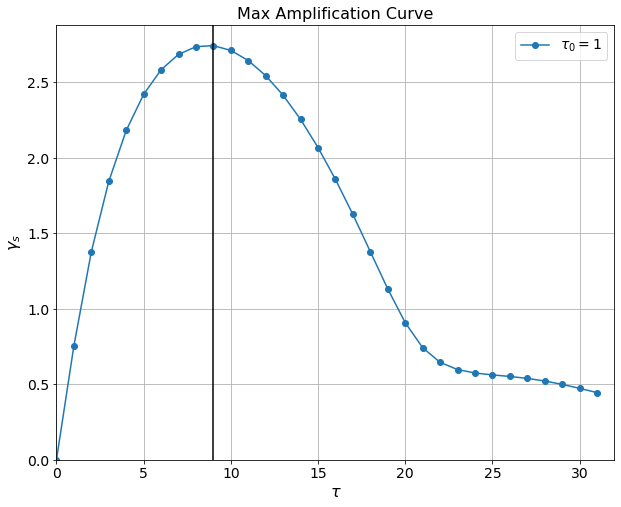

In [2113]:
GG = LIMG_PC(50,50,50,device=device, static_feat=static_feats,num_eofs=10)
b_alpha, L, Q, G, c0, cT, u, v, g, periods, decayT,n1,n2 = GG.forward_params()
b_alpha__,L__,Q__,G__,c0__,cT__,u__,v__,g__,periods__,decayT__ = LIM(n1.numpy(), tau0)

print('...plotting...')
#Define range of days to determine amplification for 
tau_arr = np.arange(31)+1   #Start at day 1, not day 0 

gamma1  = np.full([len(tau_arr)],np.nan)  #Empty array to store leading eigenvalue in 

#Get diagonal matrix of g 
g_diag = np.zeros((G.shape[0], G.shape[0]), complex)
np.fill_diagonal(g_diag, g)

tau0=1

#Check G(tau) for each value in tau_arr given tau0 
for iLag in range(len(tau_arr)):
    G_tau = np.dot(u,np.dot((g_diag)**(tau_arr[iLag]/tau0),np.transpose(v)))
    G_tau_fake = np.linalg.matrix_power(G.numpy(),(int(tau_arr[iLag]/tau0)))
    # ---- EOF analysis of GtG ---- #
    GTG = np.dot(np.transpose(G_tau),G_tau)

    eigVal_GTG, eigVec_GTG = np.linalg.eig(GTG)

    #Sort the eigenvalues in order 
    iSort_GTG  = eigVal_GTG.argsort()[::-1]   
    eigVal_GTG = eigVal_GTG[iSort_GTG]
    eigVec_GTG = eigVec_GTG[:,iSort_GTG]

    #Save first eigen value for this Tau (the maximum growing mode)
#     print(gamma1)
    gamma1[iLag] = np.log(eigVal_GTG[0])

#Insert a value of zero for day zero (initial conditions = no amplification)
gamma_all = np.insert(gamma1, 0, 0)


print('T0 =', tau0,' days; Peak growth = ',np.where(gamma_all==np.max(gamma_all))[0],' month')
# Define the lag associated with the maximum amplification (Tau_peak)
Tau_peak = int(np.where(gamma_all==np.max(gamma_all))[0])

# Set up figure window 
fig, ax1  = plt.subplots()
fig.set_size_inches(10,8)

# Plot leading eigenvalue     
ax1.plot(np.arange(32),gamma_all,'o-')
ax1.set_xlim([0,32])
ax1.set_ylim([np.min(gamma_all)*1.05,np.max(gamma_all)*1.05])  #Extend to 5% above maximum value

ax1.set_xlabel(r'$\tau $',fontsize=16)
ax1.set_ylabel(r'$\gamma_s $',fontsize=16)
ax1.grid()
ax1.axvline(Tau_peak,color='k')
ax1.set_title('Max Amplification Curve',fontsize=16)
ax1.legend([r'$\tau_0 = $'+str(tau0)],fontsize=14)
ax1.tick_params(labelsize=14)


## Expected Error

In [2145]:
GG = LIMG_PC(50,50,50,device=device, static_feat=static_feats,num_eofs=200)
b_alpha, L, Q, G, c0, cT, u, v, g, periods, decayT,n1,n2 = GG.forward_params()

# Define expected error for range of lags defined in main part of Section 5 above. 
lags = np.arange(1,9)
tau_arr = np.arange(18)+1   #Start at day 1, not day 0 

all_epsilon = np.full([len(lags),len(tau_arr)],np.nan)  #Empty array to store error in 

for iT0 in range(len(lags)):
    T0 = lags[iT0]
    
    #Carry out LIM with this value of lag
    b_alpha_fnct,L_fnct,Q_fnct,G_fnct,c0_fnct,cT_fnct,u_fnct,v_fnct,g_fnct,periods_fnct,decayT_fnct = LIM(n1.numpy(),T0)

    #Make diagonal matrix of g
    g_diag = np.zeros((np.shape(n1.numpy())[0], np.shape(n1.numpy())[0]), complex)
    np.fill_diagonal(g_diag, g_fnct)
    
    # Compute the Green function for various values of Tau given T0
    epsilon_tau = np.full([len(tau_arr)],np.nan)
    for iT in range(len(tau_arr)):
        G_tau           = np.dot(u_fnct,np.dot((g_diag)**(tau_arr[iT]/T0),np.transpose(v_fnct)))
        #Expected error 
        all_epsilon[iT0, iT] = (c0_fnct - np.dot(G_tau, np.dot(c0_fnct,np.transpose(G_tau)) ) ).trace()
        
        
        


1199 shape
complex128


/Users/wchapman/opt/miniconda3/envs/HeatTorch/lib/python3.7/site-packages/ipykernel_launcher.py:309: RuntimeWarning: divide by zero encountered in true_divide
/Users/wchapman/opt/miniconda3/envs/HeatTorch/lib/python3.7/site-packages/ipykernel_launcher.py:94: RuntimeWarning: divide by zero encountered in true_divide
/Users/wchapman/opt/miniconda3/envs/HeatTorch/lib/python3.7/site-packages/ipykernel_launcher.py:25: ComplexWarning: Casting complex values to real discards the imaginary part


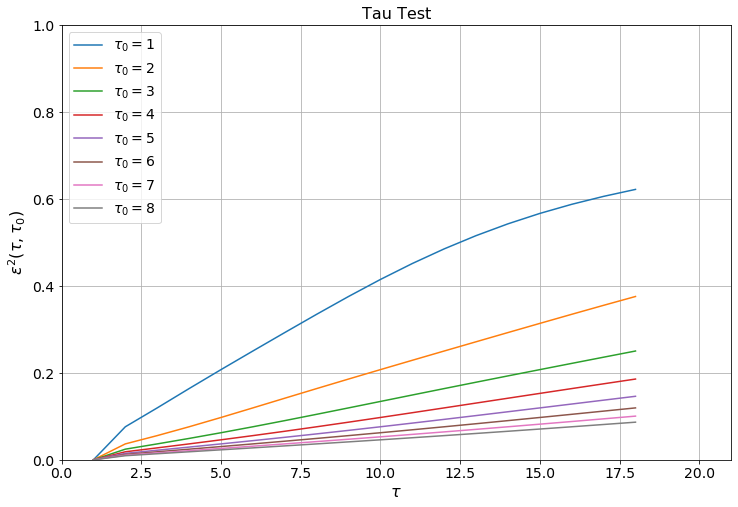

In [2146]:
# Expected error on day 0, when conditions are known, is set to zero 
new_epsilon        = np.full([len(lags),len(tau_arr)],np.nan)
new_epsilon[:,0]   = 0                    
new_epsilon[:,1::] = all_epsilon[:,1::]

# Normalize by variance 
norm_epsilon = new_epsilon/np.nansum(np.nanvar(n1.numpy(),axis=1))

# Set up plot 
fig, ax1 = plt.subplots()
fig.set_size_inches(12,8)

# Plot each line for various choices of tau0 
for iT0 in range(len(lags)):
    ax1.plot(tau_arr, norm_epsilon[iT0,:],label = r'$\tau_{0} = $'+str(lags[iT0]))

ax1.set_xlabel(r'$\tau $',fontsize=16)
ax1.set_ylabel(r'$\epsilon^{2} (\tau , \tau_0 ) $',fontsize=16)
ax1.legend(fontsize=14)
ax1.set_title('Tau Test',fontsize=16)
ax1.set_xlim([0,21])
ax1.set_ylim([0,1])
ax1.tick_params(labelsize=14)
ax1.grid()

In [2148]:
GG = LIMG_PC(50,50,50,device=device, static_feat=static_feats,num_eofs=10)

b_alpha, L, Q, G, c0, cT, u, v, g, periods, decayT,n1,n2 = GG.forward_params()


1199 shape
complex128


/Users/wchapman/opt/miniconda3/envs/HeatTorch/lib/python3.7/site-packages/ipykernel_launcher.py:309: RuntimeWarning: divide by zero encountered in true_divide


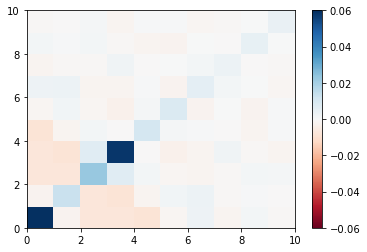

In [2156]:
plt.pcolor(Q.numpy().real,cmap='RdBu',vmin=-.06,vmax=0.06)
plt.colorbar()

## Q forcing

In [2172]:
from numpy.linalg import eigh
Q=np.matrix(Q)
is_adj = abs(Q - Q.H)
tol = 1e-10
if np.any(abs(is_adj) > tol):
    raise ValueError('Determined Q is not Hermetian (complex '
                             'conjugate transpose is equivalent.)')
    
    
q_evals, q_evects = eigh(Q)
sort_idx = q_evals.argsort()
q_evals = q_evals[sort_idx][::-1]
q_evects = q_evects[:, sort_idx][:, ::-1]
num_neg = (q_evals < 0).sum()


if num_neg > 0:
    num_left = len(q_evals) - num_neg
    if num_neg > max_neg_evals:
        logger.debug('Found {:d} modes with negative eigenvalues in'
                             ' the noise covariance term, Q.'.format(num_neg))
        raise ValueError('More than {:d} negative eigenvalues of Q '
                                 'detected.  Consider further dimensional '
                                 'reduction.'.format(max_neg_evals))

    else:
        logger.info('Removing negative eigenvalues and rescaling {:d} '
                            'remaining eigenvalues of Q.'.format(num_left))
        pos_q_evals = q_evals[q_evals > 0]
        scale_factor = q_evals.sum() / pos_q_evals.sum()
        logger.info('Q eigenvalue rescaling: {:1.2f}'.format(scale_factor))

        q_evals = q_evals[:-num_neg]*scale_factor
        q_evects = q_evects[:, :-num_neg]
else:
    scale_factor = None
    
q_evects = np.array(q_evects)

1199 shape
complex128


/Users/wchapman/opt/miniconda3/envs/HeatTorch/lib/python3.7/site-packages/ipykernel_launcher.py:309: RuntimeWarning: divide by zero encountered in true_divide


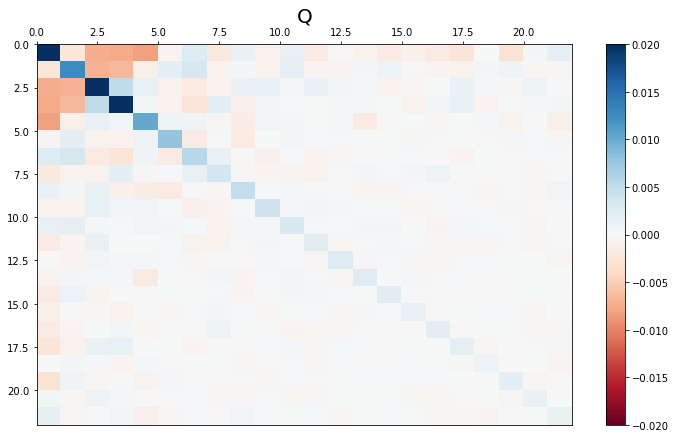

In [2186]:
GG = LIMG_PC(50,50,50,device=device, static_feat=static_feats,num_eofs=22)

b_alpha, L, Q, G, c0, cT, u, v, g, periods, decayT,n1,n2 = GG.forward_params()

fig, axs = plt.subplots(1,1, figsize=(12, 7), facecolor='w', edgecolor='k')
ax2= axs
fig.subplots_adjust(hspace = 0.2,wspace=0.3)

plt.pcolor(np.array(Q.real),cmap='RdBu',vmin=-.02,vmax=.02)
ax2.set_title('Q',fontsize=20)
ax2.invert_yaxis()
ax2.xaxis.tick_top()
cbar=fig.colorbar(bing,ax=ax2)
plt.show()

In [2112]:
def LIM(xDat,lag):  
    import numpy as np 
    from numpy import linalg as LA 

#     # Take transpose of input data matrix 
#     xDat_T = np.transpose(xDat) 

#     # ------------------------------------------------------------------
#     # STEP 1: Compute the lagged and contemporaneous covariance matrices 
    sizes = np.shape(xDat)    #Get size of matrix to determine how many data points and how many time records to consider 
    nDat = sizes[0]
    nT   = sizes[1]

#     #Get the value of the data (xDat) at the specified lag to use in computing the lagged covariance matrix 
#     xLagged = np.full([nDat,nT-lag],np.nan)  #Initialize matrix full of NaNs
#     for iT in range(nT-lag):                 #Get the value of the data at the specified lag
#         xLagged[:,iT] = xDat[:,iT+lag]

#     # Initialize matrices full of NaNs 
#     c0 = np.full([nDat, nDat], np.nan)    #Initialize matrix full of NaNs
#     cT = np.full([nDat, nDat], np.nan)    #Initialize matrix full of NaNs
    
#     # Compute covariance matrices for each data point 
#     for iR in range(nDat):
#         for iC in range(nDat):
#             # Contemporaneous covariance matrix:
#             c0[iR,iC] = np.nansum(xDat[iR,:]*xDat_T[:,iC]) / np.nansum(np.isfinite(xDat[iR,:]*xDat_T[:,iC]))
#             # Lagged covariance matrix:
#             cT[iR,iC] = np.nansum(xLagged[iR,:]*xDat_T[:-lag,iC]) / np.nansum(np.isfinite((xLagged[iR,:]*xDat_T[:-lag,iC])))

#     # --------------------------------------------------------------------
#     # STEP 2: Compute the Green function, defining its eigen values and vectors 
    
    tlag = 1
    x0=xDat[:,0:-tlag]
    x1=xDat[:,tlag:]
   
    
    cT = (x1 @ x0.T)/(x0.shape[1]-1)
    c0 = (x0 @ x0.T)/(x0.shape[1]-1)
    
    G = cT.dot(LA.inv(c0))    #The Green function is defined as the product between covariance matrices 
    # Define the modes (u) and eigen-values (g) of G
    g, u = LA.eig(G)

    iSort = g.argsort()[::-1]    #Sort the eigen values and vectors in order 
    g     = g[iSort]
    u     = u[:,iSort] 

    # Define the adjoints (v) based on the transpose of G 
    eigVal_T, v = LA.eig(np.transpose(G))
    
    iSortT      = eigVal_T.argsort()[::-1]
    eigVal_T    = eigVal_T[iSortT]
    v           = v[:,iSortT] 
   
    # But modes should ultimately be sorted by decreasing decay time (i.e., decreasing values of 1/beta.real) 

    # Compute Beta  
    b_tau   = np.log(g)
    b_alpha = b_tau/lag
    

    # Sort data by decreasing decay time 
    sortVal = -1/b_alpha.real              #Decay time 

    iSort2 = sortVal.argsort()[::-1]      #Sorted indices 
    u      = u[:,iSort2]
    v      = v[:,iSort2]
    g      = g[iSort2]
    b_alpha = b_alpha[iSort2]
    

    # Make diagonal array of Beta (values should be negative)
    beta = np.zeros((nDat, nDat), complex)
    np.fill_diagonal(beta, b_alpha)

 
    #Need to normalize u so that u_transpose*v = identitity matrix, and u*v_transpose = identity matrix as well 
    normFactors = np.dot(np.transpose(u),v)
    normU       = np.dot(u,LA.inv(normFactors))

    # --------------------------------------------------------------------
    # STEP 3: Compute L and Q matrices 

    # Compute L matrix as normU * beta * v_transpose 
    L = np.dot(normU, np.dot(beta, np.transpose(v)))

    # Compute Q matrix 
    Q_negative = np.dot(L, c0) + np.dot(c0, np.transpose(L))
    Q = -Q_negative 

    # Also define the periods and decay times 
    periods = (2 * np.pi) / b_alpha.imag 
    decayT  = -1 / b_alpha.real 

    # --------------------------------------------------------------------
    # RETURN statement 
    return(b_alpha, L, Q, G, c0, cT, normU, v, g, periods, decayT) 




In [2108]:
class LIMG_PC(nn.Module):
    def __init__(self, num_nodes, max_num_edges, dim, static_feat, device='cpu', alpha1=0.1, alpha2=2.0,
                 self_loops=True,num_eofs=100):
        super().__init__()
        if static_feat is None:
            raise ValueError("Please give static node features (e.g. part of the timeseries)")
        self.num_nodes = num_nodes
        
        A, Lh, E = torch.linalg.svd(torch.from_numpy(static_feats).T)
        A = A[:, :len(Lh)] #trim the time field (in case time > space)
        A = A[:, :len(Lh)] #trim the time field (in case time > space)
        PCs = A*Lh
        select_neofs=22
        self.select_neofs=num_eofs
        
        # normalize time series and scale in singular values to retain variance
        self.eofs = E[:self.select_neofs,:]
        n=torch.var(self.eofs,axis=1)
        self.eofs=self.eofs/torch.unsqueeze(n,dim=1)
    
        self.PCS=PCs[:,:self.select_neofs]
        self.PCS = self.PCS*torch.unsqueeze(n,dim=1).T*Lh[:self.select_neofs]
        self.eig_vals=Lh
        
        A, Lh, E = torch.linalg.svd(torch.from_numpy(static_feats).T)
        A = A[:, :len(Lh)] #trim the time field (in case time > space)
        A = A[:, :len(Lh)] #trim the time field (in case time > space)
        
        self.var_explained=(Lh*Lh)/(torch.sum(Lh*Lh))
        tau0_data = (self.PCS[:,:self.select_neofs].T)
        
        tlag = 1
        x0=tau0_data[:,0:-tlag]
        x1=tau0_data[:,tlag:]
        
        #covariance structrure
        self.static_feat = x0 if isinstance(x0, torch.Tensor) else torch.from_numpy(x0)
        self.static_feat = self.static_feat.to(torch.float64).to(device)
        
        #lagged feature
        self.static_feat1 = x1 if isinstance(x1, torch.Tensor) else torch.from_numpy(x1)
        self.static_feat1 = self.static_feat1.to(torch.float64).to(device)

        self.device = device
        self.dim = dim
        self.alpha1 = alpha1
        self.alpha2 = alpha2
        self.num_edges = max_num_edges
        self.self_loops = self_loops
        self.diag = torch.eye(self.num_nodes).bool().to(device)

    def forward(self):
        #covariance structure
        nodevec1 = self.static_feat
        nodevec2 = self.static_feat      
        #lagged covariance structure
        nodevec11 = self.static_feat
        nodevec21 = self.static_feat1
        
        adj = (nodevec21 @ nodevec11.T)@(torch.linalg.pinv(nodevec1 @ nodevec1.T))
        

        return adj
    
    def forward_params(self):
        #covariance structure
        nodevec1 = self.static_feat
        nodevec2 = self.static_feat      
        #lagged covariance structure
        nodevec11 = self.static_feat
        nodevec21 = self.static_feat1
        
        print(nodevec11.shape[1],'shape')
        cT = (nodevec21 @ nodevec11.T)/(nodevec11.shape[1]-1)
        c0 = (nodevec1 @ nodevec1.T)/(nodevec11.shape[1]-1)
#         G = (nodevec21 @ nodevec11.T)@(torch.linalg.pinv(nodevec1 @ nodevec1.T))

        G = (cT.numpy())@(np.linalg.pinv(c0.numpy()))

        g, u = np.linalg.eig(G)
        
        #sort the eigenvecs
        iSort = g.argsort()[::-1]    #Sort the eigen values and vectors in order 
        g     = g[iSort]
        u     = u[:,iSort]         
        
        
        # Define the adjoints (v) based on the transpose of G 
        eigVal_T, v = np.linalg.eig(np.transpose(G))
#         iSortT      = torch.flip(eigVal_T.real.argsort(), dims=(0,))
        iSortT = eigVal_T.argsort()[::-1]
        eigVal_T    = eigVal_T[iSortT]
        v           = v[:,iSortT] 
        
        # But modes should ultimately be sorted by decreasing decay time (i.e., decreasing values of 1/beta.real) 

        # Compute Beta 
        
        b_tau   = np.log(g)
        b_alpha = b_tau/lag
        
        
        # Sort data by decreasing decay time 
        sortVal = -1/b_alpha.real              #Decay time  

        
        
#         iSort2 =torch.flip(sortVal.argsort(), dims=(0,))
        iSort2 = sortVal.argsort()[::-1]
        u      = u[:,iSort2]
        v      = v[:,iSort2]
        g      = g[iSort2]
        b_alpha = b_alpha[iSort2]
        
        nDat = G.shape[0]
        # Make diagonal array of Beta (values should be negative)
#         beta = torch.zeros((nDat, nDat), dtype=torch.cdouble)
#         beta.fill_diagonal_(b_alpha)
        
        
        beta = np.zeros((nDat, nDat), dtype=complex)
        mask = np.diag(np.ones_like(b_alpha))
        beta = mask*np.diag(b_alpha) + (1. - mask)*beta
        
        #Need to normalize u so that u_transpose*v = identitity matrix, and u*v_transpose = identity matrix as well 
        normFactors = (u.T@v)
        normU       = (u@np.linalg.inv(normFactors))
        
        # STEP 3: Compute L and Q matrices 

        # Compute L matrix as normU * beta * v_transpose 
        L = np.dot(normU, np.dot(beta, np.transpose(v)))
    
        # Compute Q matrix 
        Q_negative = np.dot(L, c0) + np.dot(c0, np.transpose(L))
        Q = -Q_negative 

        # Also define the periods and decay times 
        # Also define the periods and decay times 
        periods = (2 * np.pi) / b_alpha.imag 
        decayT  = -1 / b_alpha.real 
        
        device ='cpu'
        print(L.dtype)
        b_alpha=torch.from_numpy(b_alpha).cdouble().to(device)
        L=torch.from_numpy(L).cdouble().to(device)
        Q=torch.from_numpy(Q).cdouble().to(device)
        G=torch.from_numpy(G).cdouble().to(device)
        normU=torch.from_numpy(normU).cdouble().to(device)
        v=torch.from_numpy(v).cdouble().to(device)
        g=torch.from_numpy(g).cdouble().to(device)
        periods=torch.from_numpy(periods).float().to(device)
        decayT=torch.from_numpy(decayT).float().to(device)
        
        
        
        return b_alpha, L, Q, G, c0, cT, normU, v, g, periods, decayT, nodevec11, nodevec21


In [2104]:
print(G.dtype)
print(G__.dtype)

torch.float32
float64


In [2105]:
GG = LIMG_PC(50,50,50,device=device, static_feat=static_feats,num_eofs=10)

b_alpha, L, Q, G, c0, cT, u, v, g, periods, decayT,n1,n2 = GG.forward_params()
b_alpha__,L__,Q__,G__,c0__,cT__,u__,v__,g__,periods__,decayT__ = LIM(n1.numpy(), tau0)


1199 shape
class EIGVAL [0.92604326+0.14394669j 0.92604326-0.14394669j 0.87552626+0.11779352j
 0.87552626-0.11779352j 0.88848339+0.j         0.906334  +0.j
 0.99357445+0.j         0.97518422+0.j         0.93583999+0.j
 0.94951686+0.j        ]
class eigval_sorted [0.99357445+0.j         0.97518422+0.j         0.94951686+0.j
 0.93583999+0.j         0.92604326+0.14394669j 0.92604326-0.14394669j
 0.906334  +0.j         0.88848339+0.j         0.87552626+0.11779352j
 0.87552626-0.11779352j]
class. b alpha presort [-0.00644628+0.j         -0.02512888+0.j         -0.051802  +0.j
 -0.06631076+0.j         -0.06489676+0.15420861j -0.06489676-0.15420861j
 -0.09834738+0.j         -0.11823933+0.j         -0.12396053+0.13373718j
 -0.12396053-0.13373718j]
class sortVal: [155.12814898  39.7948505   19.30427546  15.08050769  15.40909014
  15.40909014  10.16803873   8.45742309   8.06708392   8.06708392]
class isort2 [0 1 2 5 4 3 6 7 9 8]
class. b alpha postsort [-0.00644628+0.j         -0.02512888+0.j   

/Users/wchapman/opt/miniconda3/envs/HeatTorch/lib/python3.7/site-packages/ipykernel_launcher.py:146: RuntimeWarning: divide by zero encountered in true_divide
/Users/wchapman/opt/miniconda3/envs/HeatTorch/lib/python3.7/site-packages/ipykernel_launcher.py:101: RuntimeWarning: divide by zero encountered in true_divide


In [ ]:
import scipy

impo = np.zeros(20)
for tt in range(0,20):
    Gpow = torch.linalg.matrix_power(LIMER.forward(), tt).numpy()
    [w,q]=scipy.sparse.linalg.eigs(np.matmul(Gpow.T,Gpow),200)# this isn't quite it yet. 
    
    impo[tt] =np.max(w[0].real)
    
plt.figure(figsize=(10,4))
ax1 = plt.subplot(111)    
plt.plot(np.arange(0,20),impo,'*',label='LIM',markersize=16)
plt.xlabel('time (Months)',fontsize=15)
plt.ylabel('|P(t)|',fontsize=15)
plt.setp(ax1.get_xticklabels(), fontsize=16)
plt.setp(ax1.get_yticklabels(), fontsize=16)
plt.legend(fontsize=20)
plt.title('Max Amplification',fontsize=16)
plt.show()

In [989]:
G = cT.numpy().dot(np.linalg.inv(c0.numpy()))

In [990]:
g,u = np.linalg.eig(G)

In [994]:
iSort = g.argsort()[::-1]
g     = g[iSort]
u     = u[:,iSort] 
b_tau =np.log(g)/1
b_alpha = b_tau/lag
print(-1/b_alpha)
periods = (2 * np.pi) / b_alpha.imag 
print(periods)

[155.12814898-0.j         39.7948505 -0.j         19.30427546-0.j
  15.08050769-0.j          2.31841326+5.509047j    2.31841326-5.509047j
  10.16803873-0.j          8.45742309-0.j          3.72792937+4.0219475j
   3.72792937-4.0219475j]
[         inf          inf          inf          inf  40.74471073
 -40.74471073          inf          inf  46.98159122 -46.98159122]


/Users/wchapman/opt/miniconda3/envs/HeatTorch/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in true_divide
  import sys


In [992]:
-1/b_alpha

array([155.12814898-0.j       ,  39.7948505 -0.j       ,
        19.30427546-0.j       ,  15.08050769-0.j       ,
         2.31841326+5.509047j ,   2.31841326-5.509047j ,
        10.16803873-0.j       ,   8.45742309-0.j       ,
         3.72792937+4.0219475j,   3.72792937-4.0219475j])

1199 shape


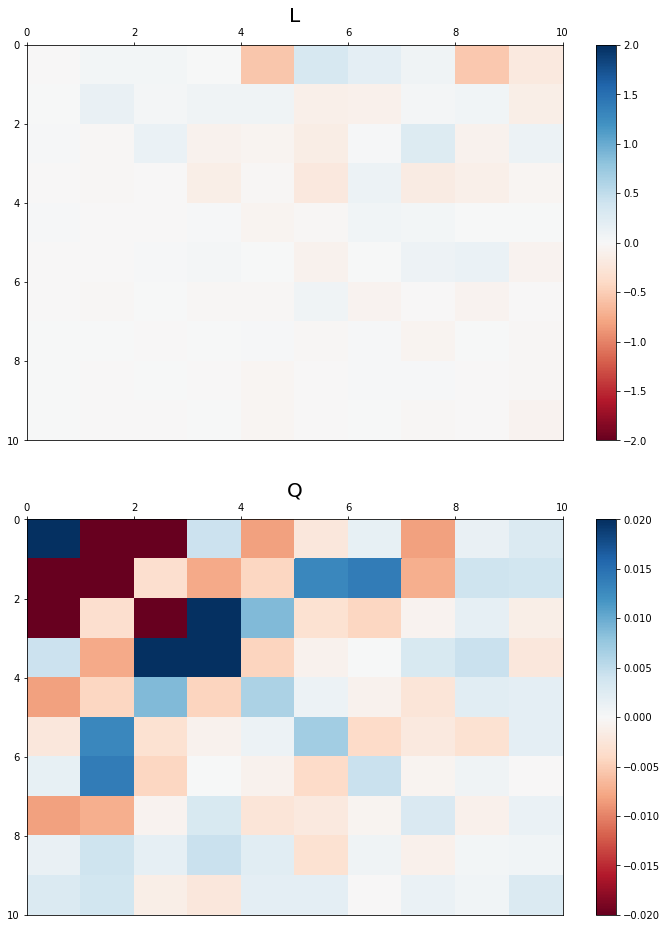

In [1808]:
b_alpha, L, Q, G, c0, cT, normU, v, g, periods, decayT,n1,n2 = GG.forward_params()

fig, axs = plt.subplots(2,1, figsize=(12, 16), facecolor='w', edgecolor='k')
ax1,ax2= axs.flatten()
fig.subplots_adjust(hspace = 0.2,wspace=0.3)

bing=ax1.pcolor(np.array(L.real),cmap='RdBu',vmin=-2,vmax=2)
ax1.set_title('L',fontsize=20)
ax1.invert_yaxis()
ax1.xaxis.tick_top()
cbar=fig.colorbar(bing,ax=ax1)

bing=ax2.pcolor(np.array(Q.real),cmap='RdBu',vmin=-0.02,vmax=0.02)
ax2.set_title('Q',fontsize=20)
ax2.invert_yaxis()
ax2.xaxis.tick_top()
cbar=fig.colorbar(bing,ax=ax2)
plt.show()

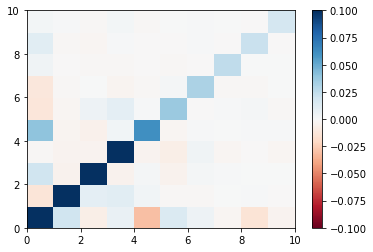

In [1809]:
plt.pcolor(cT,vmin=-.1,vmax=.1,cmap='RdBu')
plt.colorbar()

In [ ]:
tau0=1
lag=tau0
### Compute g_diag
G = GG.forward().numpy()
nDat = G.shape[0]
plt.pcolor(G)

g,u=np.linalg.eig(G)
iSort = g.argsort()[::-1]
g =g[iSort]
u = u[:,iSort]

#define adjoints (v) based on the transpose of G. 
eigVal_T, v = np.linalg.eig(G.T)
iSortT      = eigVal_T.argsort()[::-1]
eigVal_T    = eigVal_T[iSortT]
v           = v[:,iSortT] 

# Compute Beta  
b_tau   = np.log(g)
b_alpha = b_tau/lag

# Sort data by decreasing decay time 
sortVal = -1/b_alpha.real              #Decay time 

iSort2 = sortVal.argsort()[::-1]      #Sorted indices 
u      = u[:,iSort2]
v      = v[:,iSort2]
g      = g[iSort2]
b_alpha = b_alpha[iSort2]

# Make diagonal array of Beta (values should be negative)
beta = np.zeros((nDat, nDat), complex)
np.fill_diagonal(beta, b_alpha)

#Need to normalize u so that u_transpose*v = identitity matrix, and u*v_transpose = identity matrix as well 
normFactors = np.dot(np.transpose(u),v)
normU       = np.dot(u,np.linalg.inv(normFactors))

# Compute L matrix as normU * beta * v_transpose 
L = np.dot(normU, np.dot(beta, np.transpose(v)))
c0=(LIMER.static_feat.numpy()@LIMER.static_feat.numpy().T)/(LIMER.static_feat.numpy().shape[1])

# Compute Q matrix 
Q_negative = np.dot(L, c0) + np.dot(c0, np.transpose(L))
Q = -Q_negative 

fig, axs = plt.subplots(2,1, figsize=(12, 16), facecolor='w', edgecolor='k')
ax1,ax2= axs.flatten()
fig.subplots_adjust(hspace = 0.2,wspace=0.3)

bing=ax1.pcolor(np.array(L.real),cmap='RdBu',vmin=-20,vmax=20)
ax1.set_title('L',fontsize=20)
ax1.invert_yaxis()
ax1.xaxis.tick_top()
cbar=fig.colorbar(bing,ax=ax1)

bing=ax2.pcolor(np.array(Q.real),cmap='RdBu',vmin=-.2,vmax=.2)
ax2.set_title('Q',fontsize=20)
ax2.invert_yaxis()
ax2.xaxis.tick_top()
cbar=fig.colorbar(bing,ax=ax2)
plt.show()

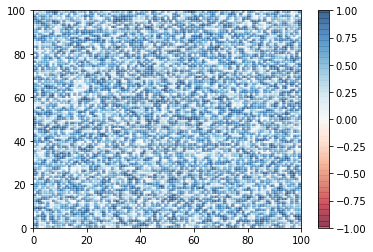

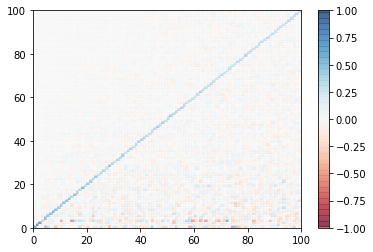

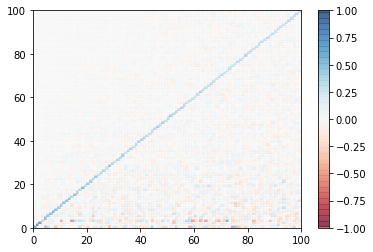

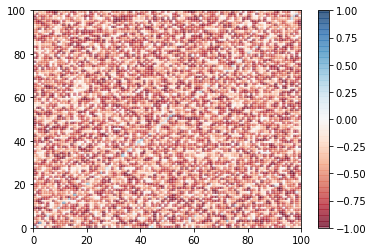

In [714]:
plt.pcolor(best_model_lim.Gbias.cpu().data.numpy(),vmin=-1,vmax=1,cmap='RdBu',alpha=0.5)
plt.colorbar()
plt.show()

plt.pcolor(best_model_lim.Gpow.cpu().data.numpy(),vmin=-1,vmax=1,cmap='RdBu',alpha=0.5)
plt.colorbar()
plt.show()

plt.pcolor(best_model_lim.Gpow_pure.cpu().data.numpy(),vmin=-1,vmax=1,cmap='RdBu',alpha=0.5)
plt.colorbar()
plt.show()

plt.pcolor(best_model_lim.Gpow.cpu().data.numpy()-best_model_lim.Gbias.cpu().data.numpy(),vmin=-1,vmax=1,cmap='RdBu',alpha=0.5)
plt.colorbar()
plt.show()

In [694]:
load_data_kwargs = {
        'window': params['window'], 'lead_months': params['horizon'], 'lon_min': params['lon_min'],
        'lon_max': params['lon_max'], 'lat_min': params['lat_min'], 'lat_max': params['lat_max'],
        'data_dir': params['data_dir'], 'use_heat_content': params['use_heat_content'],
        'add_index_node': net_params['index_node']
    }
cmip5, SODA, GODAS, cords, cnn_mask = load_cnn_data(**load_data_kwargs, return_new_coordinates=True, return_mask=True)
dinny = np.zeros(cnn_mask[:-1].shape)*np.nan
# dinny[cnn_mask[:-1]] = best_model_lim.LIM_learner.eofs[0,:-1]

lats=np.unique(SODA[0].lat)
lons=np.unique(SODA[0].lon)


/Users/wchapman/opt/miniconda3/envs/HeatTorch/lib/python3.7/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/Users/wchapman/opt/miniconda3/envs/HeatTorch/lib/python3.7/site-packages/numpy/core/_asarray.py:83: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)
/Users/wchapman/opt/miniconda3/envs/HeatTorch/lib/python3.7/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/Users/

In [698]:
static_feats

A, Lh, E = torch.linalg.svd(torch.from_numpy(static_feats).T)
A = A[:, :len(Lh)] #trim the time field (in case time > space)
A = A[:, :len(Lh)] #trim the time field (in case time > space)
PCs = A*Lh
select_neofs=100
eofs = E[:select_neofs,:].numpy()

In [699]:
opty_heat = xr.DataArray(np.zeros((len(lats), len(lons)))*np.nan, coords=[("lat", lats), ("lon", lons)])

for node, (lat_i, lon_i) in enumerate(cords[:-1]):
    opty_heat.loc[lat_i, lon_i] = eofs[0,node]


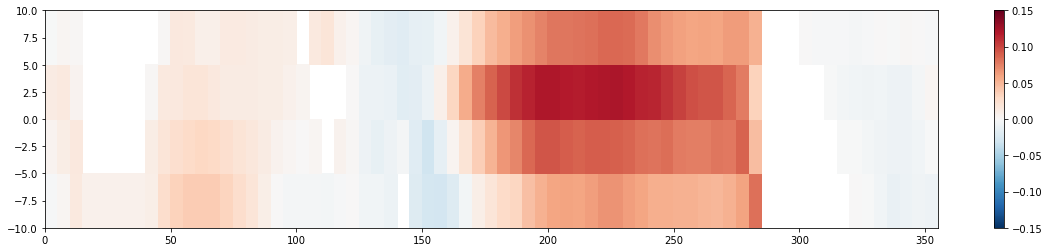

In [711]:
plt.figure(figsize=(20,4))
plt.pcolor(lons,lats,opty_heat.data,cmap='RdBu_r',vmax=.15,vmin=-.15)
plt.colorbar()

In [693]:
load_data_kwargs = {
        'window': params['window'], 'lead_months': params['horizon'], 'lon_min': params['lon_min'],
        'lon_max': params['lon_max'], 'lat_min': params['lat_min'], 'lat_max': params['lat_max'],
        'data_dir': params['data_dir'], 'use_heat_content': params['use_heat_content'],
        'add_index_node': net_params['index_node']
    }
cmip5, SODA, GODAS, cords, cnn_mask = load_cnn_data(**load_data_kwargs, return_new_coordinates=True, return_mask=True)
dinny = np.zeros(cnn_mask[:-1].shape)*np.nan
# dinny[cnn_mask[:-1]] = best_model_lim.LIM_learner.eofs[0,:-1]

lats=np.unique(SODA[0].lat)
lons=np.unique(SODA[0].lon)



/Users/wchapman/opt/miniconda3/envs/HeatTorch/lib/python3.7/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/Users/wchapman/opt/miniconda3/envs/HeatTorch/lib/python3.7/site-packages/numpy/core/_asarray.py:83: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)
/Users/wchapman/opt/miniconda3/envs/HeatTorch/lib/python3.7/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/Users/

In [583]:
load_data_kwargs = {
        'window': params['window'], 'lead_months': params['horizon'], 'lon_min': params['lon_min'],
        'lon_max': params['lon_max'], 'lat_min': params['lat_min'], 'lat_max': params['lat_max'],
        'data_dir': params['data_dir'], 'use_heat_content': params['use_heat_content'],
        'add_index_node': net_params['index_node']
    }
cmip5, SODA, GODAS, cords, cnn_mask = load_cnn_data(**load_data_kwargs, return_new_coordinates=True, return_mask=True)
dinny = np.zeros(cnn_mask[:-1].shape)*np.nan
dinny[cnn_mask[:-1]] = best_model_lim.LIM_learner.eofs[0,:-1]

lats=np.unique(SODA[0].lat)
lons=np.unique(SODA[0].lon)

# plt.pcolor(lons,lats,np.reshape(dinny,[len(lats),-1]),cmap='RdBu',vmin=-.1,vmax=.1)
# plt.colorbar()
# plt.show()

/glade/work/wchapman/miniconda3/envs/gputorch/lib/python3.7/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/glade/work/wchapman/miniconda3/envs/gputorch/lib/python3.7/site-packages/numpy/core/_asarray.py:83: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)
/glade/work/wchapman/miniconda3/envs/gputorch/lib/python3.7/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/glade/

MASKING OUT 83 nodes


In [ ]:
static_feats = get_static_feats(params, net_params, cords, SODA[0])
def get_static_feats(params, net_params, coordinates, trainset):
    max_lat = max(params['lat_max'], params['lat_min'])
    static_feats = np.array([
        [lat / max_lat, (lon - 180) / 360] for lat, lon in coordinates
    ])  # (#nodes, 2) = (#nodes (lat, lon))
    trainset_sst = trainset[:, 0, 0, :].squeeze()  # take SSTs of the first timestep before prediction
    static_feats = np.concatenate((static_feats, trainset_sst.T), axis=1)  # (#nodes, 2 + len(trainset))
    if trainset.shape[1] == 2:
        trainset_hc = trainset[:, 1, 0, :].squeeze()  # take SSTs of the first timestep before prediction
        static_feats = np.concatenate((static_feats, trainset_hc.T), axis=1)  # (#nodes, 2 + 2*len(trainset))
    return static_feats

In [585]:
static_feats = get_static_feats(params, net_params, cords, SODA[0])
static_feats.shape

(422, 2402)

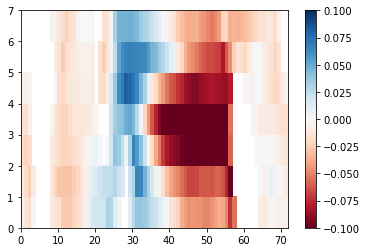

In [571]:
plt.pcolor(np.reshape(dinny,[len(lats),-1]),cmap='RdBu',vmin=-.1,vmax=.1)
plt.colorbar()

In [527]:
centrality_heat = xa.DataArray(np.zeros((len(SODA[0].lat), len(SODA[0].lon))), coords=[("lat", np.array(SODA[0].lat)), ("lon", np.array(SODA[0].lon))])

In [ ]:
centrality_heat = xa.DataArray(np.zeros((len(SODA[0].lat), len(SODA[0].lon))), coords=[("lat", np.array(SODA[0].lat)), ("lon", np.array(SODA[0].lon))])
for node, (lat_i, lon_i) in enumerate(coordinates):
    centrality_heat.loc[lat_i, lon_i] = centrality[node]

In [541]:
cnn_mask.shape
dinny = np.zeros(cnn_mask[:-1].shape)
dinny[cnn_mask[:-1]] = best_model_lim.LIM_learner.eofs[0,:-1]

In [542]:
dinny.shape

(259,)

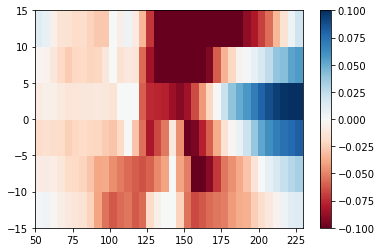

In [553]:
plt.pcolor(lons,lats,np.reshape(dinny,[7,-1]),cmap='RdBu',vmin=-.1,vmax=.1)
plt.colorbar()
plt.show()


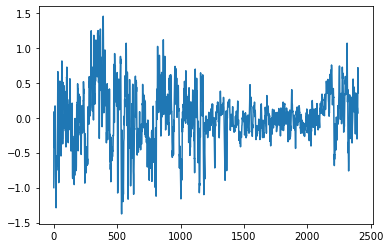

In [442]:
plt.plot(static_feats[30,:])

In [425]:
np.where(np.cumsum(best_model_lim.LIM_learner.eig_vals/torch.sum(best_model_lim.LIM_learner.eig_vals)))

tensor([0.0540, 0.1029, 0.1335, 0.1584, 0.1809, 0.2006, 0.2174, 0.2336, 0.2482,
        0.2622, 0.2754, 0.2882, 0.2994, 0.3103, 0.3206, 0.3306, 0.3403, 0.3499,
        0.3589, 0.3679, 0.3766, 0.3851, 0.3933, 0.4013, 0.4089, 0.4163, 0.4238,
        0.4310, 0.4382, 0.4450, 0.4515, 0.4579, 0.4643, 0.4704, 0.4764, 0.4823,
        0.4882, 0.4940, 0.4996, 0.5052, 0.5107, 0.5161, 0.5215, 0.5267, 0.5319,
        0.5370, 0.5421, 0.5471, 0.5520, 0.5568, 0.5616, 0.5664, 0.5711, 0.5757,
        0.5803, 0.5849, 0.5893, 0.5937, 0.5980, 0.6023, 0.6065, 0.6106, 0.6148,
        0.6189, 0.6229, 0.6270, 0.6309, 0.6349, 0.6388, 0.6427, 0.6466, 0.6504,
        0.6542, 0.6579, 0.6616, 0.6653, 0.6690, 0.6726, 0.6762, 0.6797, 0.6832,
        0.6867, 0.6902, 0.6937, 0.6971, 0.7004, 0.7038, 0.7071, 0.7104, 0.7137,
        0.7169, 0.7201, 0.7233, 0.7265, 0.7296, 0.7327, 0.7358, 0.7389, 0.7419,
        0.7449, 0.7479, 0.7509, 0.7539, 0.7568, 0.7597, 0.7626, 0.7654, 0.7683,
        0.7711, 0.7738, 0.7766, 0.7793, 

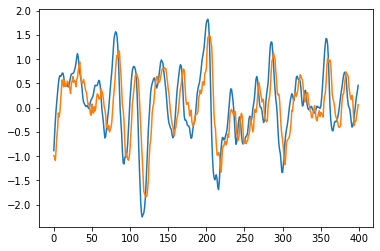

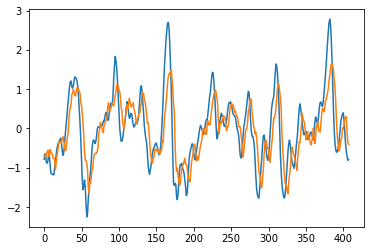

array([[1.        , 0.73893997],
       [0.73893997, 1.        ]])

In [409]:
_, val_stats,preddd,trr = evaluate_LIM(valloader,best_model_lim, device=device,return_preds=True)
plt.plot(preddd[0:400])
plt.plot(trr[0:400])
plt.show()

_, val_stats,preddd,trr = evaluate_LIM(testloader,best_model_lim, device=device,return_preds=True)
plt.plot(preddd[0:])
plt.plot(trr[0:])
plt.show()
np.corrcoef(preddd[0:400],trr[0:400])


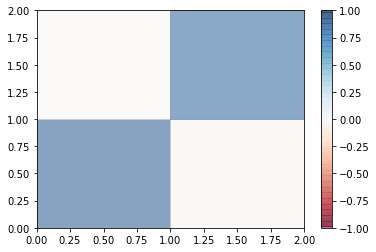

In [411]:
plt.pcolor(best_model_lim.Gpow.cpu().data.numpy(),vmin=-1,vmax=1,cmap='RdBu',alpha=0.5)
plt.colorbar()

## Learn Gpower from batches? 

In [86]:
import torch
import torch.nn as nn
# from graphino.readout_MLP import ONI_MLP
# from graphino.GCN.graph_conv_layer import GraphConvolution
# from graphino.structure_learner import EdgeStructureLearner
# from utilities.utils import get_activation_function
class nlim(nn.Module):
    def __init__(self, net_params,params, static_feat=None, adj=None, device="cuda:0", outsize=1, verbose=True):
        super().__init__()
        self.L = net_params['L']
        assert self.L > 1
        self.act = net_params['activation']
        self.out_dim = self.mlp_input_dim = net_params['out_dim']
        self.batch_norm = net_params['batch_norm']
        self.graph_pooling = net_params['readout'].lower()
        self.jumping_knowledge = net_params['jumping_knowledge']
        self.tau = params['horizon']
        self.device=device
        self.numpreds = static_feats.shape[0]
        self.Gbias = nn.Parameter(torch.rand(self.numpreds,self.numpreds),requires_grad=True)
        dropout = net_params['dropout']
        hid_dim = net_params['hidden_dim']
        num_nodes = net_params['num_nodes']
        activation = get_activation_function(self.act, functional=True, num=1, device=device)
        conv_kwargs = {'activation': activation, 'batch_norm': self.batch_norm,
                       'residual': net_params['residual'], 'dropout': dropout}
        
        
        layers = [GraphConvolution(net_params['in_dim'], hid_dim, **conv_kwargs)]
        layers += [GraphConvolution(hid_dim, hid_dim, **conv_kwargs) for _ in range(self.L - 2)]
        layers.append(GraphConvolution(hid_dim, self.out_dim, **conv_kwargs))
        
        self.layers = nn.ModuleList(layers)
        
        if self.jumping_knowledge:
            self.mlp_input_dim = self.mlp_input_dim + hid_dim * (self.L - 1)
        if self.graph_pooling in ['sum+mean', 'mean+sum', 'mean&sum', 'sum&mean']:
            self.mlp_input_dim = self.mlp_input_dim * 2
        self.MLP_layer = LIM_MLP(static_feats.shape[0], outsize, act_func=self.act, batch_norm=net_params['mlp_batch_norm'],
                                    dropout=dropout, device=device,L=3)
        
        print('this shape squared:',static_feats.shape[0])
        self.G_layer = LearnG(static_feats.shape[0], static_feats.shape[0]**2, act_func=self.act, batch_norm=net_params['mlp_batch_norm'],
                                    dropout=dropout, device=device,L=2)
        
        if adj is None:
            self.adj, self.learn_adj = None, True
            max_num_edges = int(net_params['avg_edges_per_node'] * num_nodes)
            self.LIM_learner = LIMG(50,50,50,device=device, static_feat=static_feat)
        else:
            print('Using a static connectivity structure !!!')
            self.adj, self.learn_adj = torch.from_numpy(adj).float().to(device), False

        if verbose:
            print([x for x in self.layers])

    def get_adj(self):
        if self.learn_adj:
            return self.LIM_learner.forward()
        return self.adj


    def forward(self, input, readout=True):
        if self.learn_adj:
            # Generate an adjacency matrix/connectivity structure for the graph convolutional forward pass
            self.adj = self.LIM_learner.forward()
            self.Gpow = torch.linalg.matrix_power(self.adj, self.tau)
            self.Gpow = self.Gpow + self.Gbias
            outlearnG = self.G_layer(input[:,0,-1,:])
            outlearnG = torch.mean(outlearnG,axis=0).squeeze()
            self.Gpow = self.Gpow + torch.reshape(outlearnG,(self.Gpow.shape[0],self.Gpow.shape[1]))            
            self.xfor = torch.mm(input[:,0,-1,:].to(torch.float64).to(self.device),self.Gpow.T)
            out = self.MLP_layer(self.xfor.float())
            
#         # GCN forward pass --> Generate node embeddings
#         node_embs = self.layers[0](input, self.adj)  # shape (batch-size, #nodes, #features)
#         X_all_embeddings = node_embs.clone()
#         for conv in self.layers[1:]:
#             node_embs = conv(node_embs, self.adj)
#             if self.jumping_knowledge:
#                 X_all_embeddings = torch.cat((X_all_embeddings, node_embs), dim=2)
#         final_embs = X_all_embeddings if self.jumping_knowledge else node_embs

#         # Graph pooling, e.g. take the mean over all node embeddings (dimension=1)
#         if self.graph_pooling == 'sum':
#             g_emb = torch.sum(final_embs, dim=1)
#         elif self.graph_pooling == 'mean':
#             g_emb = torch.mean(final_embs, dim=1)
#         elif self.graph_pooling == 'max':
#             g_emb, _ = torch.max(final_embs, dim=1)  # returns (values, indices)
#         elif self.graph_pooling in ['sum+mean', 'mean+sum', 'mean&sum', 'sum&mean']:
#             xmean = torch.mean(final_embs, dim=1)
#             xsum = torch.sum(final_embs, dim=1)  # (batch-size, out-dim)
#             g_emb = torch.cat((xmean, xsum), dim=1)  # (batch-size 2*out-dim)
#         else:
#             raise ValueError('Unsupported readout operation')

#         # After graph pooling: (batch-size, out-dim)
#         out = self.graph_embedding_to_pred(g_emb=g_emb) if readout else g_emb
        return  out

#     def graph_embedding_to_pred(self, g_emb):
#         out = self.MLP_layer.forward(g_emb).squeeze(1)
#         return out


import torch
import torch.nn as nn
torch.manual_seed(0)
import random
random.seed(0)

class LIMG(nn.Module):
    def __init__(self, num_nodes, max_num_edges, dim, static_feat, device='cuda', alpha1=0.1, alpha2=2.0,
                 self_loops=True):
        super().__init__()
        if static_feat is None:
            raise ValueError("Please give static node features (e.g. part of the timeseries)")
        self.num_nodes = num_nodes
        xd = static_feat.shape[1]
        tlag = 1
        x0=static_feat[:,0:-tlag]
        x1=static_feat[:,tlag:]
        
        xd = x0.shape[1]
        #covariance structrure
        self.lin1 = nn.Linear(xd, dim)
        self.lin2 = nn.Linear(xd, dim)
        self.linlag1 = nn.Linear(xd, dim)
        self.linlag2 = nn.Linear(xd, dim)
        
        self.static_feat = x0 if isinstance(x0, torch.Tensor) else torch.from_numpy(x0)
        self.static_feat = self.static_feat.to(torch.float64).to(device)
        
        #lagged feature
        self.static_feat1 = x1 if isinstance(x1, torch.Tensor) else torch.from_numpy(x1)
        self.static_feat1 = self.static_feat1.to(torch.float64).to(device)

        self.device = device
        self.dim = dim
        self.alpha1 = alpha1
        self.alpha2 = alpha2
        self.num_edges = max_num_edges
        self.self_loops = self_loops
        self.diag = torch.eye(self.num_nodes).bool().to(device)

    def forward(self):
        #covariance structure
        nodevec1 = self.static_feat
        nodevec2 = self.static_feat      
        #lagged covariance structure
        nodevec11 = self.static_feat
        nodevec21 = self.static_feat1
        
        adj = (nodevec21 @ nodevec11.T)@(torch.linalg.pinv(nodevec1 @ nodevec1.T))
        
#         adj = adj.flatten()
#         mask = torch.zeros(self.num_nodes * self.num_nodes).to(self.device)
#         _, strongest_idxs = torch.topk(adj, self.num_edges)  # Adj to get the strongest weight value indices
#         mask[strongest_idxs] = 1
#         adj = adj * mask
#         adj = adj.reshape((self.num_nodes, self.num_nodes))
#         if self.self_loops:
#             adj[self.diag] = adj[self.diag].clamp(min=0.5)

        return adj

class EdgeStructureLearner(nn.Module):
    def __init__(self, num_nodes, max_num_edges, dim, static_feat, device='cuda', alpha1=0.1, alpha2=2.0,
                 self_loops=True):
        super().__init__()
        if static_feat is None:
            raise ValueError("Please give static node features (e.g. part of the timeseries)")
        self.num_nodes = num_nodes
        xd = static_feat.shape[1]
        self.lin1 = nn.Linear(xd, dim)
        self.lin2 = nn.Linear(xd, dim)
        self.static_feat = static_feat if isinstance(static_feat, torch.Tensor) else torch.from_numpy(static_feat)
        self.static_feat = self.static_feat.float().to(device)

        self.device = device
        self.dim = dim
        self.alpha1 = alpha1
        self.alpha2 = alpha2
        self.num_edges = max_num_edges
        self.self_loops = self_loops
        self.diag = torch.eye(self.num_nodes).bool().to(device)

    def forward(self):
        nodevec1 = torch.tanh(self.alpha1 * self.lin1(self.static_feat))
        nodevec2 = torch.tanh(self.alpha1 * self.lin2(self.static_feat))

        adj = torch.sigmoid(self.alpha2 * nodevec1 @ nodevec2.T)
        adj = adj.flatten()
        mask = torch.zeros(self.num_nodes * self.num_nodes).to(self.device)
        _, strongest_idxs = torch.topk(adj, self.num_edges)  # Adj to get the strongest weight value indices
        mask[strongest_idxs] = 1
        adj = adj * mask
        adj = adj.reshape((self.num_nodes, self.num_nodes))
        if self.self_loops:
            adj[self.diag] = adj[self.diag].clamp(min=0.5)
        return adj



class nonLIMG(nn.Module):
    def __init__(self, num_nodes, max_num_edges, dim, static_feat, device='cuda', alpha1=0.1, alpha2=2.0,
                 self_loops=True):
        super().__init__()
        if static_feat is None:
            raise ValueError("Please give static node features (e.g. part of the timeseries)")
        self.num_nodes = num_nodes
        xd = static_feat.shape[1]
        tlag = 1
        x0=static_feat[:,0:-tlag]
        x1=static_feat[:,tlag:]
        
        xd = x0.shape[1]
        #covariance structrure
        self.lin1 = nn.Linear(xd, dim)
        self.lin2 = nn.Linear(xd, dim)
        self.linlag1 = nn.Linear(xd, dim)
        self.linlag2 = nn.Linear(xd, dim)
        
        self.static_feat = x0 if isinstance(x0, torch.Tensor) else torch.from_numpy(x0)
        self.static_feat = self.static_feat.to(torch.float64).to(device)
        
        #lagged feature
        self.static_feat1 = x1 if isinstance(x1, torch.Tensor) else torch.from_numpy(x1)
        self.static_feat1 = self.static_feat1.to(torch.float64).to(device)

        self.device = device
        self.dim = dim
        self.alpha1 = alpha1
        self.alpha2 = alpha2
        self.num_edges = max_num_edges
        self.self_loops = self_loops
        self.diag = torch.eye(self.num_nodes).bool().to(device)

    def forward(self):
        #covariance structure
        nodevec1 = self.lin1(self.static_feat.to(torch.float32).to(device))
        nodevec2 = self.lin2(self.static_feat.to(torch.float32).to(device))    
        #lagged covariance structure
        nodevec11 = self.linlag1(self.static_feat.to(torch.float32).to(device))
        nodevec21 = self.linlag2(self.static_feat.to(torch.float32).to(device))
        
        adj = (nodevec21 @ nodevec11.T)@(torch.linalg.pinv(nodevec1 @ nodevec1.T))
        
#         adj = adj.flatten()
#         mask = torch.zeros(self.num_nodes * self.num_nodes).to(self.device)
#         _, strongest_idxs = torch.topk(adj, self.num_edges)  # Adj to get the strongest weight value indices
#         mask[strongest_idxs] = 1
#         adj = adj * mask
#         adj = adj.reshape((self.num_nodes, self.num_nodes))
#         if self.self_loops:
#             adj[self.diag] = adj[self.diag].clamp(min=0.5)

        return adj

class LIM_MLP(nn.Module):
    """
    Fully connected MLP on top of node embeddings
    L - number of hidden layers, each of those having half the number of neurons than the previous one.
    """
    def __init__(self, input_dim, output_dim, dropout=0, L=2, batch_norm=True, act_func='elu', device='cuda'):
        super().__init__()
        FC_layers = []
        for l in range(L):
            out_dim_l = input_dim // 2 ** (l + 1)
            FC_layers.append(
                nn.Linear(input_dim // 2 ** l, out_dim_l, bias=True,device=device)
            )
            if batch_norm:
                FC_layers.append(nn.BatchNorm1d(out_dim_l,device=device))
            FC_layers.append(get_activation_function(act_func, device=device))
            if dropout > 0:
                FC_layers.append(nn.Dropout(dropout))

        self.FC_layers = nn.ModuleList(FC_layers)
        self.out_dim_last_L = input_dim // 2 ** L
        self.out_layer = nn.Linear(self.out_dim_last_L, output_dim, bias=True,device=device)
        self.L = L

    def forward(self, x):
        x=x.to(torch.float32)
        for module in self.FC_layers:
            x = module(x.to(torch.float32))
        y = self.out_layer(x)
        return y
    
    
    
class LearnG(nn.Module):
    """
    Fully connected MLP to learn the propagator matrix error. 
    L - number of hidden layers, each of those having half the number of neurons than the previous one.
    """
    def __init__(self, input_dim, output_dim, dropout=0, L=2, batch_norm=True, act_func='elu', device='cuda'):
        super().__init__()
        FC_layers = []
        for l in range(L):
            out_dim_l = input_dim // 2 ** (l + 1)
            FC_layers.append(
                nn.Linear(input_dim // 2 ** l, out_dim_l, bias=True,device=device)
            )
            if batch_norm:
                FC_layers.append(nn.BatchNorm1d(out_dim_l,device=device))
            FC_layers.append(get_activation_function(act_func, device=device))
            if dropout > 0:
                FC_layers.append(nn.Dropout(dropout))

        self.FC_layers = nn.ModuleList(FC_layers)
        self.out_dim_last_L = input_dim // 2 ** L
        self.out_layer = nn.Linear(self.out_dim_last_L, output_dim, bias=True,device=device)
        self.L = L

    def forward(self, x):
        x=x.to(torch.float32)
        for module in self.FC_layers:
            x = module(x.to(torch.float32))
        y = self.out_layer(x)
        return y


def train_epoch_LIM(dataloader, model, criterion, optims, device, epoch, nth_step=100):
    if not isinstance(optims, list):
        optims = [optims]
    model.train()
    total_loss = 0
    for iter, (X, Y) in enumerate(dataloader, 1):
        X, Y = X.to(device), Y.to(device)
        Y=Y.unsqueeze(dim=1)
        for optim in optims:
            optim.zero_grad()        
#         X = X.reshape((X.shape[0], -1, X.shape[3])).transpose(1, 2)  # shape = (batch_size x #features x #nodes)
        preds = model(X)
        loss = criterion(preds, Y)
        loss.backward()
        
        for optim in optims:
            optim.step()
        total_loss += loss.item()
    num_edges = torch.count_nonzero(model.adj.detach()).item()
    return total_loss / iter, num_edges



def train_epoch(dataloader, model, criterion, optims, device, epoch, nth_step=100):
    if not isinstance(optims, list):
        optims = [optims]
    model.train()
    total_loss = 0
    for iter, (X, Y) in enumerate(dataloader, 1):
        X, Y = X.to(device), Y.to(device)
        for optim in optims:
            optim.zero_grad()
        X = X.reshape((X.shape[0], -1, X.shape[3])).transpose(1, 2)  # shape = (batch_size x #features x #nodes)

        preds = model(X)
        loss = criterion(preds, Y)
        loss.backward()
        
        for optim in optims:
            optim.step()
        total_loss += loss.item()
    num_edges = torch.count_nonzero(model.adj.detach()).item()
    return total_loss / iter, num_edges

# Set Params # Set Params # Set Params # Set Params # Set Params # Set Params
# Set Params # Set Params # Set Params # Set Params # Set Params # Set Params
# Set Params # Set Params # Set Params # Set Params # Set Params # Set Params
# Set Params # Set Params # Set Params # Set Params # Set Params # Set Params

net_params ={'L': 2, 
         'num_nodes': 189, 
         'readout': 'mean', 
         'activation': 'ELU',
         'avg_edges_per_node': 8,
         'in_dim': 6,
         'adj_dim': 50,
         'jumping_knowledge': True, 
         'index_node': True, 
         'batch_norm': True, 
         'mlp_batch_norm': True, 
         'residual': True, 
         'self_loop': True, 
         'tanh_alpha': 0.1, 
         'sig_alpha': 2.0, 
         'dropout': 0.0,
         'hidden_dim': 250,
         'out_dim': 100}


params = {'horizon': 3,
 'window': 3,
 'lon_min': 50,
 'lon_max': 230,
 'lat_min': -15,
 'lat_max': 15,
 'model_dir': 'out/graphino/',
 'data_dir': 'Data//',
 'useCMIP5': True,
 'use_heat_content': True,
 'seed': 41,
 'shuffle': True,
 'epochs': 25,
 'batch_size': 64,
 'lr': 0.005,
 'nesterov': True,
 'weight_decay': 1e-06,
 'validation_frac': 0,
 'validation_set': 'cmip5',
 'loss': 'MSE',
 'optimizer': 'adam',
 'scheduler': 'No',
 'grid_edges': False}


(adj, static_feats, _), (trainloader,valloader,testloader) = get_dataloaders(params, net_params)
# static_feats=static_feats[:,:2000]
model = nlim(net_params, params,static_feat=static_feats, adj=adj)
optimizer = get_optimizer(params['optimizer'], model, lr=params['lr'],weight_decay=params['weight_decay'], nesterov=params['nesterov'])
criterion = get_loss(params['loss'])

# Train model# Train model# Train model# Train model# Train model# Train model
# Train model# Train model# Train model# Train model# Train model# Train model
# Train model# Train model# Train model# Train model# Train model# Train model
# Train model# Train model# Train model# Train model# Train model# Train model
t_total = time.time()
device="cuda:0"
model = model.to(device)
val_stats = None
best_val_loss = cur_val = 1000

with tqdm(range(1, params['epochs'] + 1)) as t:
    for epoch in t:
        start_t = time.time()
        loss, num_edges = train_epoch_LIM(trainloader, model, criterion, optimizer, device, epoch)
        duration = time.time() - start_t
        if valloader is not None:
            # Note that the default 'validation set' is included in the training set (=SODA),
            # and is not used at all.
            _, val_stats = evaluate_LIM(valloader, model, device=device)
            _, train_stats = evaluate_LIM(trainloader, model, device=device)
            print('validation: ',val_stats)
            print('train: ',train_stats)
            
        update_tqdm(t, loss, n_edges=num_edges, time=duration, val_stats=val_stats)
        #save the best model....
        if epoch == 1:
            best_accuracy = val_stats['corrcoef']
            best_model_lim = copy.deepcopy(model)
        else:
            print(epoch)
            if best_accuracy > val_stats['corrcoef']:
                continue
            else:
                print('new best')
                best_accuracy = val_stats['corrcoef']
                best_model_lim = copy.deepcopy(model)

/glade/work/wchapman/miniconda3/envs/gputorch/lib/python3.7/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/glade/work/wchapman/miniconda3/envs/gputorch/lib/python3.7/site-packages/numpy/core/_asarray.py:83: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)
/glade/work/wchapman/miniconda3/envs/gputorch/lib/python3.7/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/glade/

MASKING OUT 11 nodes
Train set: 36132 Validation set 600 Test set 408
this shape squared: 249
[GraphConvolution (6 -> 250), GraphConvolution (250 -> 100)]
Using Adam optimizer: Lr= 0.005 Wd= 1e-06


  4%|▍         | 1/25 [00:24<09:44, 24.36s/it, n_edges=62001, time=13, train_loss=0.185, val_all_season_cc=0.803, val_corrcoef=0.806, val_mae=3.57, val_rmse=0.459]

validation:  {'corrcoef': 0.8062041109513449, 'rmse': 0.4593934, 'all_season_cc': 0.8029595147591578, 'mae': 3.566167503595352}
train:  {'corrcoef': 0.8688017049337504, 'rmse': 0.40688625, 'all_season_cc': 0.8687816605331463, 'mae': 177.00378742814064}


  8%|▊         | 2/25 [00:48<09:18, 24.28s/it, n_edges=62001, time=12.9, train_loss=0.174, val_all_season_cc=0.871, val_corrcoef=0.878, val_mae=3.04, val_rmse=0.378]

validation:  {'corrcoef': 0.8784223095339126, 'rmse': 0.37781686, 'all_season_cc': 0.8709659580126012, 'mae': 3.0423028767108917}
train:  {'corrcoef': 0.8752920147086528, 'rmse': 0.40727982, 'all_season_cc': 0.8751408978592199, 'mae': 177.15567845106125}
2
new best


 12%|█▏        | 3/25 [01:12<08:51, 24.18s/it, n_edges=62001, time=13, train_loss=0.171, val_all_season_cc=0.844, val_corrcoef=0.85, val_mae=4.28, val_rmse=0.552]

validation:  {'corrcoef': 0.8501521977158268, 'rmse': 0.55190986, 'all_season_cc': 0.8435039655013795, 'mae': 4.281827360391617}
train:  {'corrcoef': 0.8742353073625956, 'rmse': 0.39566246, 'all_season_cc': 0.8741777478415037, 'mae': 172.26716923713684}
3


 16%|█▌        | 4/25 [01:36<08:27, 24.15s/it, n_edges=62001, time=12.8, train_loss=0.168, val_all_season_cc=0.863, val_corrcoef=0.867, val_mae=3.97, val_rmse=0.497]

validation:  {'corrcoef': 0.8672806572576729, 'rmse': 0.49704522, 'all_season_cc': 0.8629513276459052, 'mae': 3.9704663157463074}
train:  {'corrcoef': 0.874428421573837, 'rmse': 0.3954017, 'all_season_cc': 0.8743587520124478, 'mae': 172.08787335455418}
4


 20%|██        | 5/25 [02:00<08:03, 24.16s/it, n_edges=62001, time=12.9, train_loss=0.166, val_all_season_cc=0.824, val_corrcoef=0.827, val_mae=3.87, val_rmse=0.524]

validation:  {'corrcoef': 0.8270272302409236, 'rmse': 0.5243909, 'all_season_cc': 0.8238884563802052, 'mae': 3.874943733215332}
train:  {'corrcoef': 0.8752114997599294, 'rmse': 0.39617896, 'all_season_cc': 0.8751830046587843, 'mae': 172.70436011254787}
5


 24%|██▍       | 6/25 [02:25<07:40, 24.23s/it, n_edges=62001, time=13, train_loss=0.168, val_all_season_cc=0.859, val_corrcoef=0.865, val_mae=3.01, val_rmse=0.382]

validation:  {'corrcoef': 0.8654656306680494, 'rmse': 0.3820502, 'all_season_cc': 0.8594065657381801, 'mae': 3.0067732483148575}
train:  {'corrcoef': 0.8797302338611219, 'rmse': 0.39894065, 'all_season_cc': 0.879716560877991, 'mae': 173.8869064450264}
6


 28%|██▊       | 7/25 [02:49<07:15, 24.18s/it, n_edges=62001, time=12.7, train_loss=0.165, val_all_season_cc=0.749, val_corrcoef=0.763, val_mae=4.16, val_rmse=0.512]

validation:  {'corrcoef': 0.7629886805272796, 'rmse': 0.51211524, 'all_season_cc': 0.7489370786045667, 'mae': 4.162435919046402}
train:  {'corrcoef': 0.8775970543707137, 'rmse': 0.39277548, 'all_season_cc': 0.8775767971256144, 'mae': 171.14392225444317}
7


 32%|███▏      | 8/25 [03:13<06:51, 24.21s/it, n_edges=62001, time=13, train_loss=0.164, val_all_season_cc=0.862, val_corrcoef=0.87, val_mae=3.15, val_rmse=0.383]

validation:  {'corrcoef': 0.8701233346154071, 'rmse': 0.38295498, 'all_season_cc': 0.8616005220040185, 'mae': 3.152758479118347}
train:  {'corrcoef': 0.8779495964737674, 'rmse': 0.39264923, 'all_season_cc': 0.8779535664063665, 'mae': 170.96600365638733}
8


 36%|███▌      | 9/25 [03:37<06:26, 24.16s/it, n_edges=62001, time=12.8, train_loss=0.163, val_all_season_cc=0.822, val_corrcoef=0.828, val_mae=3.88, val_rmse=0.464]

validation:  {'corrcoef': 0.8282996954198455, 'rmse': 0.46426567, 'all_season_cc': 0.8221371394589095, 'mae': 3.876451253890991}
train:  {'corrcoef': 0.875013011287363, 'rmse': 0.40462762, 'all_season_cc': 0.8750308638423939, 'mae': 176.55536195635796}
9


 40%|████      | 10/25 [04:01<06:01, 24.13s/it, n_edges=62001, time=12.9, train_loss=0.162, val_all_season_cc=0.829, val_corrcoef=0.847, val_mae=3.7, val_rmse=0.447]

validation:  {'corrcoef': 0.8470730494602248, 'rmse': 0.4467633, 'all_season_cc': 0.8291048555334671, 'mae': 3.699572905898094}
train:  {'corrcoef': 0.8756506416516274, 'rmse': 0.39544752, 'all_season_cc': 0.8756070074415255, 'mae': 171.62700028717518}
10


 44%|████▍     | 11/25 [04:25<05:37, 24.10s/it, n_edges=62001, time=12.8, train_loss=0.161, val_all_season_cc=0.85, val_corrcoef=0.859, val_mae=3.14, val_rmse=0.39]

validation:  {'corrcoef': 0.8589515192039456, 'rmse': 0.39043364, 'all_season_cc': 0.8498291118448132, 'mae': 3.1382885724306107}
train:  {'corrcoef': 0.8775028331691643, 'rmse': 0.40816435, 'all_season_cc': 0.8775199648899243, 'mae': 178.90771253407001}
11


 48%|████▊     | 12/25 [04:49<05:13, 24.12s/it, n_edges=62001, time=12.9, train_loss=0.16, val_all_season_cc=0.862, val_corrcoef=0.874, val_mae=3.13, val_rmse=0.393]

validation:  {'corrcoef': 0.8735786457087977, 'rmse': 0.39253283, 'all_season_cc': 0.8617849516088533, 'mae': 3.1305676996707916}
train:  {'corrcoef': 0.8831926343851423, 'rmse': 0.38642257, 'all_season_cc': 0.883095275228238, 'mae': 168.38599579036236}
12


 52%|█████▏    | 13/25 [05:13<04:49, 24.10s/it, n_edges=62001, time=12.8, train_loss=0.16, val_all_season_cc=0.849, val_corrcoef=0.861, val_mae=3.6, val_rmse=0.469]

validation:  {'corrcoef': 0.8608791345248187, 'rmse': 0.4694526, 'all_season_cc': 0.8494711850493638, 'mae': 3.5967586040496826}
train:  {'corrcoef': 0.8816896997169681, 'rmse': 0.38473442, 'all_season_cc': 0.8816374783984761, 'mae': 167.48755304515362}
13


 56%|█████▌    | 14/25 [05:38<04:24, 24.09s/it, n_edges=62001, time=12.8, train_loss=0.157, val_all_season_cc=0.874, val_corrcoef=0.889, val_mae=2.69, val_rmse=0.348]

validation:  {'corrcoef': 0.8887665872850449, 'rmse': 0.34796217, 'all_season_cc': 0.87418068191338, 'mae': 2.689405545592308}
train:  {'corrcoef': 0.8850449743672745, 'rmse': 0.38271847, 'all_season_cc': 0.8850248873589627, 'mae': 166.854044765234}
14
new best


 60%|██████    | 15/25 [06:02<04:00, 24.08s/it, n_edges=62001, time=12.8, train_loss=0.158, val_all_season_cc=0.836, val_corrcoef=0.844, val_mae=4.51, val_rmse=0.573]

validation:  {'corrcoef': 0.844267337079685, 'rmse': 0.57256204, 'all_season_cc': 0.8356924876280544, 'mae': 4.506890892982483}
train:  {'corrcoef': 0.881640507200141, 'rmse': 0.3890101, 'all_season_cc': 0.8816722066649135, 'mae': 169.4019860625267}
15


 64%|██████▍   | 16/25 [06:26<03:36, 24.06s/it, n_edges=62001, time=12.8, train_loss=0.154, val_all_season_cc=0.845, val_corrcoef=0.86, val_mae=3.16, val_rmse=0.391]

validation:  {'corrcoef': 0.8596498408922104, 'rmse': 0.3912191, 'all_season_cc': 0.8448221381349535, 'mae': 3.158596098423004}
train:  {'corrcoef': 0.8869234096947235, 'rmse': 0.38053223, 'all_season_cc': 0.8868488638777631, 'mae': 165.82527290284634}
16


 68%|██████▊   | 17/25 [06:50<03:12, 24.06s/it, n_edges=62001, time=12.8, train_loss=0.155, val_all_season_cc=0.856, val_corrcoef=0.86, val_mae=3.22, val_rmse=0.433]

validation:  {'corrcoef': 0.8601930988180655, 'rmse': 0.4328174, 'all_season_cc': 0.8557545807141832, 'mae': 3.2231430113315582}
train:  {'corrcoef': 0.8886508103403149, 'rmse': 0.38001582, 'all_season_cc': 0.8886211217939145, 'mae': 165.86838640272617}
17


 72%|███████▏  | 18/25 [07:14<02:48, 24.05s/it, n_edges=62001, time=12.8, train_loss=0.154, val_all_season_cc=0.844, val_corrcoef=0.853, val_mae=3.37, val_rmse=0.453]

validation:  {'corrcoef': 0.8528875638470702, 'rmse': 0.4527567, 'all_season_cc': 0.8444126860214797, 'mae': 3.3695468306541443}
train:  {'corrcoef': 0.8886966349063423, 'rmse': 0.3754038, 'all_season_cc': 0.8887598710413073, 'mae': 163.1948832720518}
18


 76%|███████▌  | 19/25 [07:38<02:24, 24.05s/it, n_edges=62001, time=12.8, train_loss=0.154, val_all_season_cc=0.839, val_corrcoef=0.848, val_mae=3.24, val_rmse=0.435]

validation:  {'corrcoef': 0.8476795269357975, 'rmse': 0.4351613, 'all_season_cc': 0.8386618558725872, 'mae': 3.242255762219429}
train:  {'corrcoef': 0.8887103033584043, 'rmse': 0.3733192, 'all_season_cc': 0.888699448842261, 'mae': 162.70401452481747}
19


 80%|████████  | 20/25 [08:02<02:00, 24.05s/it, n_edges=62001, time=12.8, train_loss=0.154, val_all_season_cc=0.866, val_corrcoef=0.877, val_mae=3.57, val_rmse=0.454]

validation:  {'corrcoef': 0.877449806345149, 'rmse': 0.4544495, 'all_season_cc': 0.8664796170777733, 'mae': 3.572974592447281}
train:  {'corrcoef': 0.890868368460943, 'rmse': 0.3757352, 'all_season_cc': 0.8908922176659851, 'mae': 163.79129372537136}
20


 84%|████████▍ | 21/25 [08:26<01:36, 24.05s/it, n_edges=62001, time=12.8, train_loss=0.151, val_all_season_cc=0.861, val_corrcoef=0.872, val_mae=3.4, val_rmse=0.444]

validation:  {'corrcoef': 0.8718507795797875, 'rmse': 0.4443505, 'all_season_cc': 0.8608574156179182, 'mae': 3.4002176225185394}
train:  {'corrcoef': 0.8920547985967313, 'rmse': 0.36847302, 'all_season_cc': 0.8920547898920522, 'mae': 160.76735730469227}
21


 88%|████████▊ | 22/25 [08:50<01:12, 24.04s/it, n_edges=62001, time=12.8, train_loss=0.151, val_all_season_cc=0.849, val_corrcoef=0.858, val_mae=3.46, val_rmse=0.445]

validation:  {'corrcoef': 0.8582854332237124, 'rmse': 0.44527602, 'all_season_cc': 0.8494546176317151, 'mae': 3.459596872329712}
train:  {'corrcoef': 0.8916041381382567, 'rmse': 0.36968678, 'all_season_cc': 0.8915911571229452, 'mae': 161.26424822211266}
22


 92%|█████████▏| 23/25 [09:14<00:48, 24.06s/it, n_edges=62001, time=12.8, train_loss=0.15, val_all_season_cc=0.874, val_corrcoef=0.886, val_mae=2.81, val_rmse=0.356]

validation:  {'corrcoef': 0.8863473758657775, 'rmse': 0.35596198, 'all_season_cc': 0.8743108107654677, 'mae': 2.811009556055069}
train:  {'corrcoef': 0.8947163009152823, 'rmse': 0.38356286, 'all_season_cc': 0.8947496289743704, 'mae': 167.81594356894493}
23


 96%|█████████▌| 24/25 [09:38<00:24, 24.16s/it, n_edges=62001, time=13, train_loss=0.148, val_all_season_cc=0.875, val_corrcoef=0.889, val_mae=2.74, val_rmse=0.352]

validation:  {'corrcoef': 0.8890702310813976, 'rmse': 0.35225752, 'all_season_cc': 0.8753386985456721, 'mae': 2.7366917431354523}
train:  {'corrcoef': 0.8922214565181382, 'rmse': 0.37225246, 'all_season_cc': 0.8921658714157239, 'mae': 162.420518592}
24
new best


100%|██████████| 25/25 [10:03<00:00, 24.13s/it, n_edges=62001, time=13, train_loss=0.15, val_all_season_cc=0.851, val_corrcoef=0.864, val_mae=3.34, val_rmse=0.394]

validation:  {'corrcoef': 0.8643005268418681, 'rmse': 0.39447623, 'all_season_cc': 0.8508243874589301, 'mae': 3.33809357881546}
train:  {'corrcoef': 0.8941858105565391, 'rmse': 0.36405364, 'all_season_cc': 0.8942230312434724, 'mae': 158.5111971050501}
25


## NonLinear

In [162]:
import torch
import torch.nn as nn
# from graphino.readout_MLP import ONI_MLP
# from graphino.GCN.graph_conv_layer import GraphConvolution
# from graphino.structure_learner import EdgeStructureLearner
# from utilities.utils import get_activation_function

class nlim(nn.Module):
    def __init__(self, net_params,params, static_feat=None, adj=None, device="cuda:0", outsize=1, verbose=True):
        super().__init__()
        self.L = net_params['L']
        assert self.L > 1
        self.act = net_params['activation']
        self.out_dim = self.mlp_input_dim = net_params['out_dim']
        self.batch_norm = net_params['batch_norm']
        self.graph_pooling = net_params['readout'].lower()
        self.jumping_knowledge = net_params['jumping_knowledge']
        self.tau = params['horizon']
        self.device=device
        dropout = net_params['dropout']
        hid_dim = net_params['hidden_dim']
        num_nodes = net_params['num_nodes']
        activation = get_activation_function(self.act, functional=True, num=1, device=device)
        conv_kwargs = {'activation': activation, 'batch_norm': self.batch_norm,
                       'residual': net_params['residual'], 'dropout': dropout}
        
        
        layers = [GraphConvolution(net_params['in_dim'], hid_dim, **conv_kwargs)]
        layers += [GraphConvolution(hid_dim, hid_dim, **conv_kwargs) for _ in range(self.L - 2)]
        layers.append(GraphConvolution(hid_dim, self.out_dim, **conv_kwargs))
        
        self.layers = nn.ModuleList(layers)
        
        if self.jumping_knowledge:
            self.mlp_input_dim = self.mlp_input_dim + hid_dim * (self.L - 1)
        if self.graph_pooling in ['sum+mean', 'mean+sum', 'mean&sum', 'sum&mean']:
            self.mlp_input_dim = self.mlp_input_dim * 2
        self.MLP_layer = LIM_MLP(static_feats.shape[0], outsize, act_func=self.act, batch_norm=net_params['mlp_batch_norm'],
                                    dropout=dropout, device=device,L=3)
        if adj is None:
            self.adj, self.learn_adj = None, True
            max_num_edges = int(net_params['avg_edges_per_node'] * num_nodes)
            self.LIM_learner = nonLIMG(50,50,500,device=device, static_feat=static_feat)
        else:
            print('Using a static connectivity structure !!!')
            self.adj, self.learn_adj = torch.from_numpy(adj).float().to(device), False

        if verbose:
            print([x for x in self.layers])

    def get_adj(self):
        if self.learn_adj:
            return self.LIM_learner.forward()
        return self.adj


    def forward(self, input, readout=True):
        if self.learn_adj:
            # Generate an adjacency matrix/connectivity structure for the graph convolutional forward pass
            self.adj = self.LIM_learner.forward()
            self.Gpow = torch.linalg.matrix_power(self.adj, self.tau)
            self.xfor = torch.mm(input[:,0,2,:].to(torch.float64).to(self.device),self.Gpow.T)
            out = self.MLP_layer(self.xfor.float())
            
#         # GCN forward pass --> Generate node embeddings
#         node_embs = self.layers[0](input, self.adj)  # shape (batch-size, #nodes, #features)
#         X_all_embeddings = node_embs.clone()
#         for conv in self.layers[1:]:
#             node_embs = conv(node_embs, self.adj)
#             if self.jumping_knowledge:
#                 X_all_embeddings = torch.cat((X_all_embeddings, node_embs), dim=2)
#         final_embs = X_all_embeddings if self.jumping_knowledge else node_embs

#         # Graph pooling, e.g. take the mean over all node embeddings (dimension=1)
#         if self.graph_pooling == 'sum':
#             g_emb = torch.sum(final_embs, dim=1)
#         elif self.graph_pooling == 'mean':
#             g_emb = torch.mean(final_embs, dim=1)
#         elif self.graph_pooling == 'max':
#             g_emb, _ = torch.max(final_embs, dim=1)  # returns (values, indices)
#         elif self.graph_pooling in ['sum+mean', 'mean+sum', 'mean&sum', 'sum&mean']:
#             xmean = torch.mean(final_embs, dim=1)
#             xsum = torch.sum(final_embs, dim=1)  # (batch-size, out-dim)
#             g_emb = torch.cat((xmean, xsum), dim=1)  # (batch-size 2*out-dim)
#         else:
#             raise ValueError('Unsupported readout operation')

#         # After graph pooling: (batch-size, out-dim)
#         out = self.graph_embedding_to_pred(g_emb=g_emb) if readout else g_emb
        return  out

#     def graph_embedding_to_pred(self, g_emb):
#         out = self.MLP_layer.forward(g_emb).squeeze(1)
#         return out


import torch
import torch.nn as nn
torch.manual_seed(0)
import random
random.seed(0)

class LIMG(nn.Module):
    def __init__(self, num_nodes, max_num_edges, dim, static_feat, device='cuda', alpha1=0.1, alpha2=2.0,
                 self_loops=True):
        super().__init__()
        if static_feat is None:
            raise ValueError("Please give static node features (e.g. part of the timeseries)")
        self.num_nodes = num_nodes
        xd = static_feat.shape[1]
        tlag = 1
        x0=static_feat[:,0:-tlag]
        x1=static_feat[:,tlag:]
        
        xd = x0.shape[1]
        #covariance structrure
        self.lin1 = nn.Linear(xd, dim)
        self.lin2 = nn.Linear(xd, dim)
        self.linlag1 = nn.Linear(xd, dim)
        self.linlag2 = nn.Linear(xd, dim)
        
        self.static_feat = x0 if isinstance(x0, torch.Tensor) else torch.from_numpy(x0)
        self.static_feat = self.static_feat.to(torch.float64).to(device)
        
        #lagged feature
        self.static_feat1 = x1 if isinstance(x1, torch.Tensor) else torch.from_numpy(x1)
        self.static_feat1 = self.static_feat1.to(torch.float64).to(device)

        self.device = device
        self.dim = dim
        self.alpha1 = alpha1
        self.alpha2 = alpha2
        self.num_edges = max_num_edges
        self.self_loops = self_loops
        self.diag = torch.eye(self.num_nodes).bool().to(device)

    def forward(self):
        #covariance structure
        nodevec1 = self.static_feat
        nodevec2 = self.static_feat      
        #lagged covariance structure
        nodevec11 = self.static_feat
        nodevec21 = self.static_feat1
        adj = (nodevec21 @ nodevec11.T)@(torch.linalg.pinv(nodevec1 @ nodevec1.T))
        
#         adj = adj.flatten()
#         mask = torch.zeros(self.num_nodes * self.num_nodes).to(self.device)
#         _, strongest_idxs = torch.topk(adj, self.num_edges)  # Adj to get the strongest weight value indices
#         mask[strongest_idxs] = 1
#         adj = adj * mask
#         adj = adj.reshape((self.num_nodes, self.num_nodes))
#         if self.self_loops:
#             adj[self.diag] = adj[self.diag].clamp(min=0.5)

        return adj

class EdgeStructureLearner(nn.Module):
    def __init__(self, num_nodes, max_num_edges, dim, static_feat, device='cuda', alpha1=0.1, alpha2=2.0,
                 self_loops=True):
        super().__init__()
        if static_feat is None:
            raise ValueError("Please give static node features (e.g. part of the timeseries)")
        self.num_nodes = num_nodes
        xd = static_feat.shape[1]
        self.lin1 = nn.Linear(xd, dim)
        self.lin2 = nn.Linear(xd, dim)
        self.static_feat = static_feat if isinstance(static_feat, torch.Tensor) else torch.from_numpy(static_feat)
        self.static_feat = self.static_feat.float().to(device)

        self.device = device
        self.dim = dim
        self.alpha1 = alpha1
        self.alpha2 = alpha2
        self.num_edges = max_num_edges
        self.self_loops = self_loops
        self.diag = torch.eye(self.num_nodes).bool().to(device)

    def forward(self):
        nodevec1 = torch.tanh(self.alpha1 * self.lin1(self.static_feat))
        nodevec2 = torch.tanh(self.alpha1 * self.lin2(self.static_feat))

        adj = torch.sigmoid(self.alpha2 * nodevec1 @ nodevec2.T)
        adj = adj.flatten()
        mask = torch.zeros(self.num_nodes * self.num_nodes).to(self.device)
        _, strongest_idxs = torch.topk(adj, self.num_edges)  # Adj to get the strongest weight value indices
        mask[strongest_idxs] = 1
        adj = adj * mask
        adj = adj.reshape((self.num_nodes, self.num_nodes))
        if self.self_loops:
            adj[self.diag] = adj[self.diag].clamp(min=0.5)

        return adj



class nonLIMG(nn.Module):
    def __init__(self, num_nodes, max_num_edges, dim, static_feat, device='cuda', alpha1=0.1, alpha2=2.0,
                 self_loops=True):
        super().__init__()
        if static_feat is None:
            raise ValueError("Please give static node features (e.g. part of the timeseries)")
        self.num_nodes = num_nodes
        xd = static_feat.shape[1]
        tlag = 1
        x0=static_feat[:,0:-tlag]
        x1=static_feat[:,tlag:]
        
        xd = x0.shape[1]
        #covariance structrure
        self.lin1 = nn.Linear(xd, dim)
        self.lin2 = nn.Linear(xd, dim)
        self.linlag1 = nn.Linear(xd, dim)
        self.linlag2 = nn.Linear(xd, dim)
        
        self.static_feat = x0 if isinstance(x0, torch.Tensor) else torch.from_numpy(x0)
        self.static_feat = self.static_feat.to(torch.float64).to(device)
        
        #lagged feature
        self.static_feat1 = x1 if isinstance(x1, torch.Tensor) else torch.from_numpy(x1)
        self.static_feat1 = self.static_feat1.to(torch.float64).to(device)

        self.device = device
        self.dim = dim
        self.alpha1 = alpha1
        self.alpha2 = alpha2
        self.num_edges = max_num_edges
        self.self_loops = self_loops
        self.diag = torch.eye(self.num_nodes).bool().to(device)

    def forward(self):
        #covariance structure
        nodevec1 = self.lin1(self.static_feat.to(torch.float32).to(device))
        nodevec2 = self.lin2(self.static_feat.to(torch.float32).to(device))    
        #lagged covariance structure
        nodevec11 = self.linlag1(self.static_feat.to(torch.float32).to(device))
        nodevec21 = self.linlag2(self.static_feat.to(torch.float32).to(device))
        
        adj = (nodevec21 @ nodevec11.T)@(torch.linalg.pinv(nodevec1 @ nodevec1.T))
        
        
        
        LINnodevec1 = self.static_feat
        LINnodevec2 = self.static_feat      
        #lagged covariance structure
        LINnodevec11 = self.static_feat
        LINnodevec21 = self.static_feat1
        LINadj = (LINnodevec21 @ LINnodevec11.T)@(torch.linalg.pinv(LINnodevec1 @ LINnodevec1.T))
        
        adj = LINadj
        
#         adj = adj.flatten()
#         mask = torch.zeros(self.num_nodes * self.num_nodes).to(self.device)
#         _, strongest_idxs = torch.topk(adj, self.num_edges)  # Adj to get the strongest weight value indices
#         mask[strongest_idxs] = 1
#         adj = adj * mask
#         adj = adj.reshape((self.num_nodes, self.num_nodes))
#         if self.self_loops:
#             adj[self.diag] = adj[self.diag].clamp(min=0.5)

        return adj

class LIM_MLP(nn.Module):
    """
    Fully connected MLP on top of node embeddings
    L - number of hidden layers, each of those having half the number of neurons than the previous one.
    """
    def __init__(self, input_dim, output_dim, dropout=0, L=2, batch_norm=True, act_func='elu', device='cuda'):
        super().__init__()
        FC_layers = []
        for l in range(L):
            out_dim_l = input_dim // 2 ** (l + 1)
            FC_layers.append(
                nn.Linear(input_dim // 2 ** l, out_dim_l, bias=True,device=device)
            )
            if batch_norm:
                FC_layers.append(nn.BatchNorm1d(out_dim_l,device=device))
            FC_layers.append(get_activation_function(act_func, device=device))
            if dropout > 0:
                FC_layers.append(nn.Dropout(dropout))

        self.FC_layers = nn.ModuleList(FC_layers)
        self.out_dim_last_L = input_dim // 2 ** L
        self.out_layer = nn.Linear(self.out_dim_last_L, output_dim, bias=True,device=device)
        self.L = L

    def forward(self, x):
        x=x.to(torch.float32)
        for module in self.FC_layers:
            x = module(x.to(torch.float32))
        y = self.out_layer(x)
        return y


def train_epoch_LIM(dataloader, model, criterion, optims, device, epoch, nth_step=100):
    if not isinstance(optims, list):
        optims = [optims]
    model.train()
    total_loss = 0
    for iter, (X, Y) in enumerate(dataloader, 1):
        X, Y = X.to(device), Y.to(device)
        Y=Y.unsqueeze(dim=1)
        for optim in optims:
            optim.zero_grad()        
#         X = X.reshape((X.shape[0], -1, X.shape[3])).transpose(1, 2)  # shape = (batch_size x #features x #nodes)
        preds = model(X)
        loss = criterion(preds, Y)
        loss.backward()
        
        for optim in optims:
            optim.step()
        total_loss += loss.item()
    num_edges = torch.count_nonzero(model.adj.detach()).item()
    return total_loss / iter, num_edges



def train_epoch(dataloader, model, criterion, optims, device, epoch, nth_step=100):
    if not isinstance(optims, list):
        optims = [optims]
    model.train()
    total_loss = 0
    for iter, (X, Y) in enumerate(dataloader, 1):
        X, Y = X.to(device), Y.to(device)
        for optim in optims:
            optim.zero_grad()
        X = X.reshape((X.shape[0], -1, X.shape[3])).transpose(1, 2)  # shape = (batch_size x #features x #nodes)

        preds = model(X)
        loss = criterion(preds, Y)
        loss.backward()
        
        for optim in optims:
            optim.step()
        total_loss += loss.item()
    num_edges = torch.count_nonzero(model.adj.detach()).item()
    return total_loss / iter, num_edges

# Set Params # Set Params # Set Params # Set Params # Set Params # Set Params
# Set Params # Set Params # Set Params # Set Params # Set Params # Set Params
# Set Params # Set Params # Set Params # Set Params # Set Params # Set Params
# Set Params # Set Params # Set Params # Set Params # Set Params # Set Params

net_params ={'L': 2, 
         'num_nodes': 189, 
         'readout': 'mean', 
         'activation': 'ELU',
         'avg_edges_per_node': 8,
         'in_dim': 6,
         'adj_dim': 50,
         'jumping_knowledge': True, 
         'index_node': True, 
         'batch_norm': True, 
         'mlp_batch_norm': True, 
         'residual': True, 
         'self_loop': True, 
         'tanh_alpha': 0.1, 
         'sig_alpha': 2.0, 
         'dropout': 0.0,
         'hidden_dim': 250,
         'out_dim': 100}

params = {'horizon': 3,
 'window': 3,
 'lon_min': 50,
 'lon_max': 230,
 'lat_min': -10,
 'lat_max': 10,
 'model_dir': 'out/graphino/',
 'data_dir': 'Data//',
 'useCMIP5': True,
 'use_heat_content': True,
 'seed': 41,
 'shuffle': True,
 'epochs': 20,
 'batch_size': 64,
 'lr': 0.005,
 'nesterov': True,
 'weight_decay': 1e-06,
 'validation_frac': 0,
 'validation_set': 'cmip5',
 'loss': 'MSE',
 'optimizer': 'adam',
 'scheduler': 'No',
 'grid_edges': False}


(adj, static_feats, _), (trainloader,valloader) = get_dataloaders(params, net_params)
static_feats=static_feats[:,:6000]
model = nlim(net_params, params,static_feat=static_feats, adj=adj)
optimizer = get_optimizer(params['optimizer'], model, lr=params['lr'],weight_decay=params['weight_decay'], nesterov=params['nesterov'])
criterion = get_loss(params['loss'])

# Train model# Train model# Train model# Train model# Train model# Train model
# Train model# Train model# Train model# Train model# Train model# Train model
# Train model# Train model# Train model# Train model# Train model# Train model
# Train model# Train model# Train model# Train model# Train model# Train model
t_total = time.time()
device="cuda:0"
model = model.to(device)
val_stats = None

with tqdm(range(1, params['epochs'] + 1)) as t:
    for epoch in t:
        start_t = time.time()
        loss, num_edges = train_epoch_LIM(trainloader, model, criterion, optimizer, device, epoch)
        duration = time.time() - start_t
        if valloader is not None:
            # Note that the default 'validation set' is included in the training set (=SODA),
            # and is not used at all.
            _, val_stats = evaluate_LIM(valloader, model, device=device)
            _, train_stats = evaluate_LIM(trainloader, model, device=device)
            print('validation: ',val_stats)
            print('train: ',train_stats)
            
        update_tqdm(t, loss, n_edges=num_edges, time=duration, val_stats=val_stats)
        #save the best model....
        if epoch == 1:
            best_accuracy = val_stats['corrcoef']
            best_model_nlim = copy.deepcopy(model)
        else:
            print(epoch)
            if best_accuracy > val_stats['corrcoef']:
                continue
            else:
                print('new best')
                best_accuracy = val_stats['corrcoef']
                best_model_nlim = copy.deepcopy(model)

/glade/work/wchapman/miniconda3/envs/gputorch/lib/python3.7/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/glade/work/wchapman/miniconda3/envs/gputorch/lib/python3.7/site-packages/numpy/core/_asarray.py:83: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)
/glade/work/wchapman/miniconda3/envs/gputorch/lib/python3.7/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/glade/

MASKING OUT 0 nodes
Train set: 34532
[GraphConvolution (6 -> 250), GraphConvolution (250 -> 100)]
Using Adam optimizer: Lr= 0.005 Wd= 1e-06


  5%|▌         | 1/20 [00:27<08:49, 27.88s/it, n_edges=34596, time=14.2, train_loss=0.3, val_corrcoef=0.883, val_mae=4.64, val_rmse=0.36]

validation:  {'corrcoef': 0.8834109483643005, 'rmse': 0.36039135, 'mae': 4.643694877624512}
train:  {'corrcoef': 0.8520473392252474, 'rmse': 0.4272688, 'mae': 177.933907777071}


 10%|█         | 2/20 [00:55<08:22, 27.90s/it, n_edges=34596, time=14.2, train_loss=0.292, val_corrcoef=0.885, val_mae=4.58, val_rmse=0.359]

validation:  {'corrcoef': 0.8854529408394831, 'rmse': 0.3587311, 'mae': 4.5828757137060165}
train:  {'corrcoef': 0.8568578213657144, 'rmse': 0.4218186, 'mae': 175.65323998034}
2
new best


 15%|█▌        | 3/20 [01:23<07:54, 27.90s/it, n_edges=34596, time=14.2, train_loss=0.286, val_corrcoef=0.889, val_mae=4.53, val_rmse=0.355]

validation:  {'corrcoef': 0.8888459974672247, 'rmse': 0.35528824, 'mae': 4.526423081755638}
train:  {'corrcoef': 0.8596559285389708, 'rmse': 0.41870168, 'mae': 174.53000310063362}
3
new best


 20%|██        | 4/20 [01:51<07:26, 27.89s/it, n_edges=34596, time=14.2, train_loss=0.283, val_corrcoef=0.889, val_mae=4.55, val_rmse=0.354]

validation:  {'corrcoef': 0.8894924386907748, 'rmse': 0.35393387, 'mae': 4.55358462035656}
train:  {'corrcoef': 0.8576533247532528, 'rmse': 0.41945168, 'mae': 174.58769074082375}
4
new best


 25%|██▌       | 5/20 [02:19<06:58, 27.89s/it, n_edges=34596, time=14.2, train_loss=0.278, val_corrcoef=0.891, val_mae=4.52, val_rmse=0.351]

validation:  {'corrcoef': 0.8908381164903685, 'rmse': 0.35123256, 'mae': 4.5221037119627}
train:  {'corrcoef': 0.857058838379614, 'rmse': 0.41988865, 'mae': 174.67481270432472}
5
new best


 30%|███       | 6/20 [02:47<06:30, 27.89s/it, n_edges=34596, time=14.2, train_loss=0.275, val_corrcoef=0.89, val_mae=4.56, val_rmse=0.354]

validation:  {'corrcoef': 0.8902630775532061, 'rmse': 0.3535568, 'mae': 4.561886414885521}
train:  {'corrcoef': 0.8541840968798409, 'rmse': 0.4238246, 'mae': 176.06881560385227}
6


 35%|███▌      | 7/20 [03:15<06:02, 27.88s/it, n_edges=34596, time=14.2, train_loss=0.271, val_corrcoef=0.891, val_mae=4.56, val_rmse=0.353]

validation:  {'corrcoef': 0.8906746732532707, 'rmse': 0.35318667, 'mae': 4.555648058652878}
train:  {'corrcoef': 0.852261707570376, 'rmse': 0.4267343, 'mae': 177.01828688383102}
7


 40%|████      | 8/20 [03:43<05:34, 27.88s/it, n_edges=34596, time=14.2, train_loss=0.267, val_corrcoef=0.89, val_mae=4.57, val_rmse=0.355]

validation:  {'corrcoef': 0.8903458556165514, 'rmse': 0.35450813, 'mae': 4.570721119642258}
train:  {'corrcoef': 0.8500225510389471, 'rmse': 0.43027866, 'mae': 178.2287831902504}
8


 45%|████▌     | 9/20 [04:10<05:06, 27.89s/it, n_edges=34596, time=14.2, train_loss=0.264, val_corrcoef=0.89, val_mae=4.56, val_rmse=0.354]

validation:  {'corrcoef': 0.8900130856811862, 'rmse': 0.35415524, 'mae': 4.5564576387405396}
train:  {'corrcoef': 0.8500877419150348, 'rmse': 0.43033993, 'mae': 178.0246198475361}
9


 50%|█████     | 10/20 [04:38<04:38, 27.88s/it, n_edges=34596, time=14.2, train_loss=0.261, val_corrcoef=0.889, val_mae=4.58, val_rmse=0.357]

validation:  {'corrcoef': 0.8887118965636576, 'rmse': 0.35650483, 'mae': 4.583071917295456}
train:  {'corrcoef': 0.8471111097281461, 'rmse': 0.43524674, 'mae': 179.68689343333244}
10


 55%|█████▌    | 11/20 [05:06<04:10, 27.88s/it, n_edges=34596, time=14.2, train_loss=0.258, val_corrcoef=0.888, val_mae=4.6, val_rmse=0.358]

validation:  {'corrcoef': 0.8877370300582546, 'rmse': 0.3582874, 'mae': 4.600279375910759}
train:  {'corrcoef': 0.844167977467048, 'rmse': 0.43967804, 'mae': 181.16003677248955}
11


 60%|██████    | 12/20 [05:34<03:43, 27.88s/it, n_edges=34596, time=14.2, train_loss=0.255, val_corrcoef=0.887, val_mae=4.61, val_rmse=0.359]

validation:  {'corrcoef': 0.887221345996967, 'rmse': 0.359195, 'mae': 4.607509657740593}
train:  {'corrcoef': 0.8425795168427969, 'rmse': 0.44278413, 'mae': 182.01618391275406}
12


 65%|██████▌   | 13/20 [06:02<03:15, 27.88s/it, n_edges=34596, time=14.2, train_loss=0.253, val_corrcoef=0.886, val_mae=4.65, val_rmse=0.362]

validation:  {'corrcoef': 0.8857368017581797, 'rmse': 0.3621257, 'mae': 4.6454077064991}
train:  {'corrcoef': 0.8394501947936368, 'rmse': 0.44756433, 'mae': 183.60405366122723}
13


 70%|███████   | 14/20 [06:30<02:47, 27.89s/it, n_edges=34596, time=14.2, train_loss=0.25, val_corrcoef=0.885, val_mae=4.64, val_rmse=0.362]

validation:  {'corrcoef': 0.8851121995009991, 'rmse': 0.362049, 'mae': 4.638255074620247}
train:  {'corrcoef': 0.8383799750211386, 'rmse': 0.44900694, 'mae': 184.02430929243565}
14


 75%|███████▌  | 15/20 [06:58<02:19, 27.90s/it, n_edges=34596, time=14.2, train_loss=0.249, val_corrcoef=0.883, val_mae=4.71, val_rmse=0.367]

validation:  {'corrcoef': 0.8830140021870545, 'rmse': 0.36747724, 'mae': 4.713716372847557}
train:  {'corrcoef': 0.8343224869804174, 'rmse': 0.45487043, 'mae': 186.21283294260502}
15


 80%|████████  | 16/20 [07:26<01:51, 27.88s/it, n_edges=34596, time=14.2, train_loss=0.247, val_corrcoef=0.882, val_mae=4.74, val_rmse=0.37]

validation:  {'corrcoef': 0.8818239323348075, 'rmse': 0.36971855, 'mae': 4.7417633682489395}
train:  {'corrcoef': 0.832136915198746, 'rmse': 0.45812345, 'mae': 187.32443760335445}
16


 85%|████████▌ | 17/20 [07:54<01:23, 27.88s/it, n_edges=34596, time=14.2, train_loss=0.245, val_corrcoef=0.881, val_mae=4.77, val_rmse=0.372]

validation:  {'corrcoef': 0.8805689650157525, 'rmse': 0.37198615, 'mae': 4.771035000681877}
train:  {'corrcoef': 0.8300355554111489, 'rmse': 0.46122542, 'mae': 188.37054054439068}
17


 90%|█████████ | 18/20 [08:21<00:55, 27.87s/it, n_edges=34596, time=14.2, train_loss=0.243, val_corrcoef=0.88, val_mae=4.8, val_rmse=0.374]

validation:  {'corrcoef': 0.879656791037791, 'rmse': 0.37377566, 'mae': 4.795596316456795}
train:  {'corrcoef': 0.8289627433475827, 'rmse': 0.46295005, 'mae': 188.93956817686558}
18


 95%|█████████▌| 19/20 [08:49<00:27, 27.87s/it, n_edges=34596, time=14.2, train_loss=0.243, val_corrcoef=0.879, val_mae=4.8, val_rmse=0.374]

validation:  {'corrcoef': 0.8794880650973809, 'rmse': 0.3742179, 'mae': 4.804518327116966}
train:  {'corrcoef': 0.828736068983185, 'rmse': 0.46372414, 'mae': 189.24681822955608}
19


100%|██████████| 20/20 [09:17<00:00, 27.88s/it, n_edges=34596, time=14.2, train_loss=0.242, val_corrcoef=0.878, val_mae=4.82, val_rmse=0.375]

validation:  {'corrcoef': 0.8782879228689323, 'rmse': 0.3754371, 'mae': 4.818476960062981}
train:  {'corrcoef': 0.8273717112372364, 'rmse': 0.4648479, 'mae': 189.71131792664528}
20


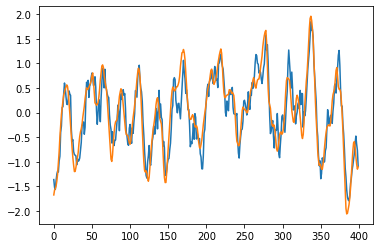

In [163]:
_, val_stats,preddd,trr1 = evaluate_LIM(valloader,best_model_nlim, device=device,return_preds=True)
plt.plot(trr1[0:400])
plt.plot(preddd[0:400])

In [ ]:
get_learn

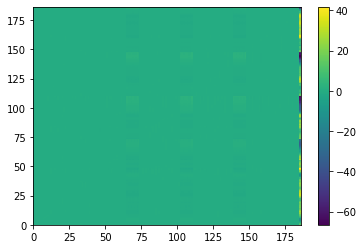

In [164]:
plt.pcolor(best_model_nlim.Gpow.cpu().numpy())
plt.colorbar()

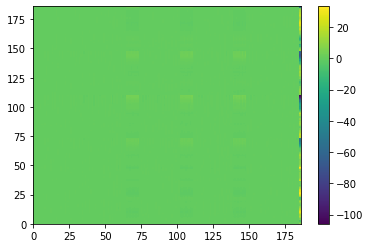

In [149]:
plt.pcolor(best_model_lim.Gpow.cpu().numpy())
plt.colorbar()


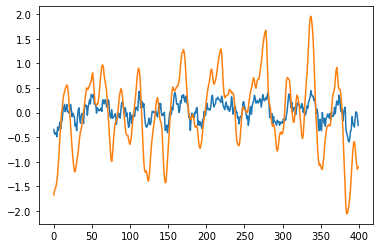

In [144]:
_, val_stats,preddd,trr1 = evaluate_LIM(valloader,best_model_nlim, device=device,return_preds=True)
plt.plot(trr1[0:400])
plt.plot(preddd[0:400])

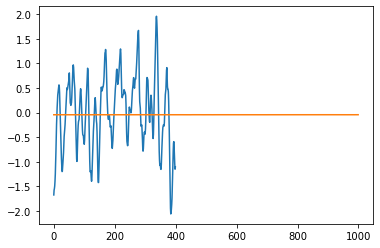

In [127]:
_, val_stats,trr,preddd = evaluate_LIM(valloader,best_model_nlim, device=device,return_preds=True)
plt.plot(trr[0:400])
plt.plot(preddd)

In [ ]:
_, val_stats,trr,preddd = evaluate_LIM(valloader,best_model, device=device,return_preds=True)

In [128]:
best_model_nlim.LIM_learner.lin1

Linear(in_features=999, out_features=10000, bias=True)

In [65]:
def evaluate_LIM(dataloader, model, device, return_preds=False):
    model.eval()
    total_loss_l2 = 0
    total_loss_l1 = 0
    preds = None
    Ytrue = None
    for i, (X, Y) in enumerate(dataloader, 1):
        assert len(X.size()) == 4, "Expected X to have shape (batch_size, #channels, window, #nodes)"
        X, Y = X.to(device), Y.to(device)
        Y=Y.unsqueeze(dim=1)
#         X = X.reshape((X.shape[0], -1, X.shape[3])).transpose(1, 2)
        with torch.no_grad():
            output = model(X)
        if preds is None:
            preds = output
            Ytrue = Y
        else:
            preds = torch.cat((preds, output))
            Ytrue = torch.cat((Ytrue, Y))
        total_loss_l2 += F.mse_loss(output, Y).item()
        total_loss_l1 += F.l1_loss(output, Y).item()

    preds = preds.data.cpu().numpy().squeeze()
    Ytest = Ytrue.data.cpu().numpy().squeeze()
    oni_stats = evaluate_preds(Ytest, preds, return_dict=True)
    oni_stats['mae'] = total_loss_l1
    if return_preds:
        return total_loss_l2 / i, oni_stats, Ytest, preds
    else:
        return total_loss_l2 / i, oni_stats
    

In [71]:
_, val_stats,preddd,trr = evaluate_LIM(valloader,best_model, device=device,return_preds=True)

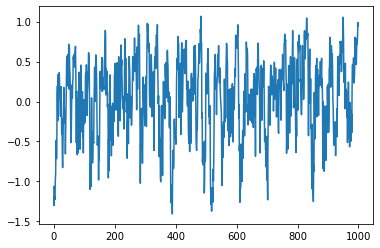

In [73]:
plt.plot(trr[0:])

In [74]:
np.max(trr[0:])

1.0675812

In [46]:
_, val_stats,preddd,trr = evaluate_LIM(trainloader,best_model, device=device,return_preds=True)

In [61]:
XXX,YYY=next(iter(valloader))

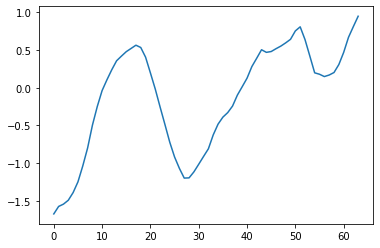

In [64]:
plt.plot(YYY)

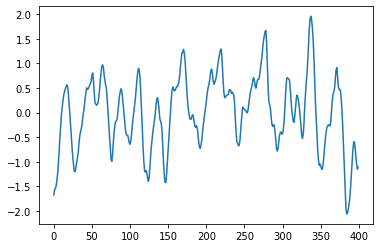

In [58]:
plt.plot(preddd[0:400])
# plt.plot(trr[0:400])
plt.show()

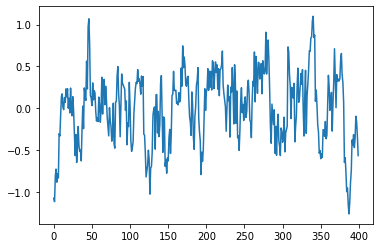

In [59]:
plt.plot(trr[0:400])


In [48]:
np.corrcoef(preddd[0:400],trr[0:400])

array([[1.        , 0.78256304],
       [0.78256304, 1.        ]])

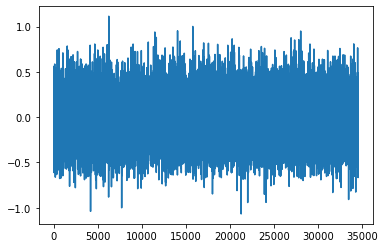

In [49]:
plt.plot(trr[0:])

In [ ]:
import torch
import torch.nn as nn

class TemporalEdgeStructureLearner(nn.Module):
    def __init__(self, num_nodes, max_num_edges, dim, static_feat, device='cuda', alpha1=0.1, alpha2=2.0,
                 self_loops=True):
        super().__init__()
        if static_feat is None:
            raise ValueError("Please give static node features (e.g. part of the timeseries)")
        self.num_nodes = num_nodes
        xd = static_feat.shape[1]
        tlag = 1
        x0=static_feat[0:-tlag, :]
        x1=static_feat[tlag:, :]
        
        xd = x0.shape[1]
        #covariance structrure
        self.lin1 = nn.Linear(xd, dim)
        self.lin2 = nn.Linear(xd, dim)
        
        self.linlag1 = nn.Linear(xd, dim)
        self.linlag2 = nn.Linear(xd, dim)
        
        
        self.static_feat = x0 if isinstance(x0, torch.Tensor) else torch.from_numpy(x0)
        self.static_feat = self.static_feat.float().to(device)
        
        #lagged feature
        self.static_feat1 = x1 if isinstance(x1, torch.Tensor) else torch.from_numpy(x1)
        self.static_feat1 = self.static_feat1.float().to(device)

        self.device = device
        self.dim = dim
        self.alpha1 = alpha1
        self.alpha2 = alpha2
        self.num_edges = max_num_edges
        self.self_loops = self_loops
        self.diag = torch.eye(self.num_nodes).bool().to(device)

    def forward(self):
        #covariance structure
        nodevec1 = torch.tanh(self.alpha1 * self.lin1(self.static_feat))
        nodevec2 = torch.tanh(self.alpha1 * self.lin2(self.static_feat))
        #adj = torch.sigmoid(self.alpha2 * nodevec1 @ nodevec2.T)
        
        #lagged covariance structure
        nodevec11 = torch.tanh(self.alpha1 * self.lin1(self.static_feat))
        nodevec21 = torch.tanh(self.alpha1 * self.lin2(self.static_feat1))
        #adj = torch.sigmoid(self.alpha2 * nodevec1 @ nodevec2.T)
        
        adj = torch.mm(torch.sigmoid(self.alpha2 * nodevec11 @ nodevec21.T),torch.linalg.pinv(torch.sigmoid(self.alpha2 * nodevec1 @ nodevec2.T)))
        
        
#         adj = adj.flatten()
#         mask = torch.zeros(self.num_nodes * self.num_nodes).to(self.device)
#         _, strongest_idxs = torch.topk(adj, self.num_edges)  # Adj to get the strongest weight value indices
#         mask[strongest_idxs] = 1
#         adj = adj * mask
#         adj = adj.reshape((self.num_nodes, self.num_nodes))
#         if self.self_loops:
#             adj[self.diag] = adj[self.diag].clamp(min=0.5)

        return adj


In [ ]:
model = GCN(net_params, static_feat=static_feats, adj=adj)


In [ ]:
import torch
import torch.nn as nn

class EdgeStructureLearner(nn.Module):
    def __init__(self, num_nodes, max_num_edges, dim, static_feat, device='cuda', alpha1=0.1, alpha2=2.0,
                 self_loops=True):
        super().__init__()
        if static_feat is None:
            raise ValueError("Please give static node features (e.g. part of the timeseries)")
        self.num_nodes = num_nodes
        xd = static_feat.shape[1]
        self.lin1 = nn.Linear(xd, dim)
        self.lin2 = nn.Linear(xd, dim)
        self.static_feat = static_feat if isinstance(static_feat, torch.Tensor) else torch.from_numpy(static_feat)
        self.static_feat = self.static_feat.float().to(device)

        self.device = device
        self.dim = dim
        self.alpha1 = alpha1
        self.alpha2 = alpha2
        self.num_edges = max_num_edges
        self.self_loops = self_loops
        self.diag = torch.eye(self.num_nodes).bool().to(device)

    def forward(self):
        nodevec1 = torch.tanh(self.alpha1 * self.lin1(self.static_feat))
        nodevec2 = torch.tanh(self.alpha1 * self.lin2(self.static_feat))

        adj = torch.sigmoid(self.alpha2 * nodevec1 @ nodevec2.T)
        adj = adj.flatten()
        mask = torch.zeros(self.num_nodes * self.num_nodes).to(self.device)
        _, strongest_idxs = torch.topk(adj, self.num_edges)  # Adj to get the strongest weight value indices
        mask[strongest_idxs] = 1
        adj = adj * mask
        adj = adj.reshape((self.num_nodes, self.num_nodes))
        if self.self_loops:
            adj[self.diag] = adj[self.diag].clamp(min=0.5)

        return adj


## CRPS LOSS FUNCTION

In [150]:
def get_loss(name, reduction='mean'):
    # Specify loss function
    name = name.lower().strip()
    if name in ['l1', 'mae']:
        loss = nn.L1Loss(reduction=reduction)
    elif name in ['l2', 'mse']:
        print('in here MSE werewolf')
        loss = nn.MSELoss(reduction=reduction)  
    elif name in ['bingbop', 'gauss']:
        print('getttt probable babbby')
        loss = nn.GaussianNLLLoss(reduction=reduction)
    else:
        raise ValueError()  # default
    return loss


# def metric_crps(mu, sigma, truth):
#     """
#     http://cran.nexr.com/web/packages/scoringRules/vignettes/crpsformulas.html
#     """
    
#     # The following three variables are just for convenience
#     loc = (truth - mu) / sigma
#     phi = 1.0 / np.sqrt(2.0 * np.pi) * K.exp(-K.square(loc) / 2.0)
#     Phi = 0.5 * (1.0 + tfm.erf(loc / np.sqrt(2.0)))
    
#     # First we will compute the crps for each input/target pair
#     crps_arr = sigma * (loc * (2. * Phi - 1.) + 2 * phi - 1. / np.sqrt(np.pi))
    
#     return crps_arr

def crps_cost_function(y_pred,y_true):
    """
    compute the CRPS cost function of a normal distribution defined by the
    mean and std. 
    
    Args: 
        y_true: true values
        y_pred: tensor containing preds [mean,std]
    
    Returns: 
        mean_crps: Scalar with mean CRPS over the batch
    
    """
    
    mu = y_pred[:,0]
    sigma = torch.abs(y_pred[:,1])+1e-5
    #the following three variabsles are for convenience 
    loc =(y_true-mu)/sigma
    phi =1.0 / torch.sqrt(torch.as_tensor(2.0*math.pi))*torch.exp(-torch.square(loc)/2.0)
    Phi = 0.5*(1.0+torch.erf((loc/torch.sqrt(torch.as_tensor(2.0))))) #loc/sqrt(2.0)
    #crps for the target pair. 
    crps = sigma * (loc * (2.0 * Phi - 1.) + 2.0 * phi - 1.0 / torch.sqrt(torch.as_tensor(math.pi)))
    crps = crps.mean()
    return crps


class Custom_CRPS(nn.Module):
    def __init__(self):
        super(Custom_CRPS,self).__init__();
    
    def forward(self,y_pred,y_true):
        mu = y_pred[:,0]
        sigma = torch.abs(y_pred[:,1])+1e-3
        #the following three variabsles are for convenience 
        loc =(y_true-mu)/sigma
        phi =1.0 / torch.sqrt(torch.as_tensor(2.0*math.pi))*torch.exp(-torch.square(loc)/2.0)
        Phi = 0.5*(1.0+torch.erf((loc/torch.sqrt(torch.as_tensor(2.0))))) #loc/sqrt(2.0)
        #crps for the target pair. 
        crps = sigma * (loc * (2.0 * Phi - 1.) + 2.0 * phi - 1.0 / torch.sqrt(torch.as_tensor(math.pi)))
        crps = torch.mean(crps)
        return crps

In [157]:
import torch
import torch.nn as nn
# from graphino.readout_MLP import ONI_MLP
# from graphino.GCN.graph_conv_layer import GraphConvolution
# from graphino.structure_learner import EdgeStructureLearner
# from utilities.utils import get_activation_function
class nlim(nn.Module):
    def __init__(self, net_params,params, static_feat=None, adj=None, device="cpu", outsize=1, verbose=True):
        super().__init__()
        self.L = net_params['L']
        assert self.L > 1
        self.act = net_params['activation']
        self.out_dim = self.mlp_input_dim = net_params['out_dim']
        outsize = self.out_dim
        self.batch_norm = net_params['batch_norm']
        self.graph_pooling = net_params['readout'].lower()
        self.jumping_knowledge = net_params['jumping_knowledge']
        self.tau = params['horizon']
        self.device=device
        self.numpreds = static_feats.shape[0]
        self.num_eofs = 100
        self.loss = params['loss']
        
        self.Gbias = nn.Parameter(torch.rand(self.num_eofs,self.num_eofs),requires_grad=True)
        dropout = net_params['dropout']
        hid_dim = net_params['hidden_dim']
        num_nodes = net_params['num_nodes']
        activation = get_activation_function(self.act, functional=True, num=1, device=device)
        conv_kwargs = {'activation': activation, 'batch_norm': self.batch_norm,
                       'residual': net_params['residual'], 'dropout': dropout}
        
        
        layers = [GraphConvolution(net_params['in_dim'], hid_dim, **conv_kwargs)]
        layers += [GraphConvolution(hid_dim, hid_dim, **conv_kwargs) for _ in range(self.L - 2)]
        layers.append(GraphConvolution(hid_dim, self.out_dim, **conv_kwargs))
        
        self.layers = nn.ModuleList(layers)
        
        if self.jumping_knowledge:
            self.mlp_input_dim = self.mlp_input_dim + hid_dim * (self.L - 1)
        if self.graph_pooling in ['sum+mean', 'mean+sum', 'mean&sum', 'sum&mean']:
            self.mlp_input_dim = self.mlp_input_dim * 2
        
        if self.loss == 'Gauss':
            self.MLP_layer = LIM_MLP_GaussLL(static_feats.shape[0], outsize, act_func=self.act, batch_norm=net_params['mlp_batch_norm'],
                                    dropout=dropout, device=device,L=4)
        else:
            self.MLP_layer = LIM_MLP(static_feats.shape[0], outsize, act_func=self.act, batch_norm=net_params['mlp_batch_norm'],
                                    dropout=dropout, device=device,L=4)
        if adj is None:
            self.adj, self.learn_adj = None, True
            max_num_edges = int(net_params['avg_edges_per_node'] * num_nodes)
            self.LIM_learner = LIMG_PC(50,50,50,device=device, static_feat=static_feat,num_eofs=self.num_eofs)
        else:
            print('Using a static connectivity structure !!!')
            self.adj, self.learn_adj = torch.from_numpy(adj).float().to(device), False

        if verbose:
            print([x for x in self.layers])

    def get_adj(self):
        if self.learn_adj:
            return self.LIM_learner.forward()
        return self.adj


    def forward(self, input, readout=True):
        if self.learn_adj:
            # Generate an adjacency matrix/connectivity structure for the graph convolutional forward pass
            self.adj = self.LIM_learner.forward()
            self.Gpow_pure = torch.linalg.matrix_power(self.adj, self.tau)
            self.Gpow = torch.linalg.matrix_power(self.adj, self.tau)
            self.Gpow = self.Gpow #+ self.Gbias
            
            #project input space onto pcs. 
            Forecast_inits =torch.cat((input[:,0,-1,:].to(torch.float64).to(self.device),input[:,1,-1,:].to(torch.float64).to(self.device)),1)
#             Forecast_inits = (torch.from_numpy(static_feats)[:,-64:]).T #input must be timexspace dimensions
            proj_pcs = Forecast_inits@self.LIM_learner.eofs.T.to(torch.float64).to(self.device) #project the dataset onto the EOFS using a matrix mult.
            for_pcs_space = torch.mm(self.Gpow,proj_pcs.T)
            self.xfor = for_pcs_space.T@self.LIM_learner.eofs.to(torch.float64).to(self.device)
            
            if self.loss == 'Gauss':
                out,var = self.MLP_layer(self.xfor.float())
                return  out,var
            else:
                out = self.MLP_layer(self.xfor.float())
                return  out

#     def graph_embedding_to_pred(self, g_emb):
#         out = self.MLP_layer.forward(g_emb).squeeze(1)
#         return out


import torch
import torch.nn as nn
torch.manual_seed(0)
import random
random.seed(0)

class LIMG(nn.Module):
    def __init__(self, num_nodes, max_num_edges, dim, static_feat, device='cpu', alpha1=0.1, alpha2=2.0,
                 self_loops=True):
        super().__init__()
        if static_feat is None:
            raise ValueError("Please give static node features (e.g. part of the timeseries)")
        self.num_nodes = num_nodes
        xd = static_feat.shape[1]
        tlag = 1
        x0=static_feat[:,0:-tlag]
        x1=static_feat[:,tlag:]
        
        xd = x0.shape[1]
        #covariance structrure
        self.lin1 = nn.Linear(xd, dim)
        self.lin2 = nn.Linear(xd, dim)
        self.linlag1 = nn.Linear(xd, dim)
        self.linlag2 = nn.Linear(xd, dim)
        
        self.static_feat = x0 if isinstance(x0, torch.Tensor) else torch.from_numpy(x0)
        self.static_feat = self.static_feat.to(torch.float64).to(device)
        
        #lagged feature
        self.static_feat1 = x1 if isinstance(x1, torch.Tensor) else torch.from_numpy(x1)
        self.static_feat1 = self.static_feat1.to(torch.float64).to(device)

        self.device = device
        self.dim = dim
        self.alpha1 = alpha1
        self.alpha2 = alpha2
        self.num_edges = max_num_edges
        self.self_loops = self_loops
        self.diag = torch.eye(self.num_nodes).bool().to(device)

    def forward(self):
        #covariance structure
        nodevec1 = self.static_feat
        nodevec2 = self.static_feat      
        #lagged covariance structure
        nodevec11 = self.static_feat
        nodevec21 = self.static_feat1
        
        adj = (nodevec21 @ nodevec11.T)@(torch.linalg.pinv(nodevec1 @ nodevec1.T))
        
#         adj = adj.flatten()
#         mask = torch.zeros(self.num_nodes * self.num_nodes).to(self.device)
#         _, strongest_idxs = torch.topk(adj, self.num_edges)  # Adj to get the strongest weight value indices
#         mask[strongest_idxs] = 1
#         adj = adj * mask
#         adj = adj.reshape((self.num_nodes, self.num_nodes))
#         if self.self_loops:
#             adj[self.diag] = adj[self.diag].clamp(min=0.5)

        return adj


class LIMG_PC(nn.Module):
    def __init__(self, num_nodes, max_num_edges, dim, static_feat, device='cpu', alpha1=0.1, alpha2=2.0,
                 self_loops=True,num_eofs=100):
        super().__init__()
        if static_feat is None:
            raise ValueError("Please give static node features (e.g. part of the timeseries)")
        self.num_nodes = num_nodes
        
        A, Lh, E = torch.linalg.svd(torch.from_numpy(static_feats).T)
        A = A[:, :len(Lh)] #trim the time field (in case time > space)
        A = A[:, :len(Lh)] #trim the time field (in case time > space)
        PCs = A*Lh
        select_neofs=22
        self.select_neofs=num_eofs
        
        # normalize time series and scale in singular values to retain variance
        self.eofs = E[:self.select_neofs,:]
        n=torch.var(self.eofs,axis=1)
        self.eofs=self.eofs/torch.unsqueeze(n,dim=1)
    
        self.PCS=PCs[:,:self.select_neofs]
        self.PCS = self.PCS*torch.unsqueeze(n,dim=1).T*Lh[:self.select_neofs]
        self.eig_vals=Lh
        
        A, Lh, E = torch.linalg.svd(torch.from_numpy(static_feats).T)
        A = A[:, :len(Lh)] #trim the time field (in case time > space)
        A = A[:, :len(Lh)] #trim the time field (in case time > space)
        
        self.var_explained=(Lh*Lh)/(torch.sum(Lh*Lh))
        tau0_data = (self.PCS[:,:self.select_neofs].T)
        
        tlag = 1
        x0=tau0_data[:,0:-tlag]
        x1=tau0_data[:,tlag:]
        
        #covariance structrure
        self.static_feat = x0 if isinstance(x0, torch.Tensor) else torch.from_numpy(x0)
        self.static_feat = self.static_feat.to(torch.float64).to(device)
        
        #lagged feature
        self.static_feat1 = x1 if isinstance(x1, torch.Tensor) else torch.from_numpy(x1)
        self.static_feat1 = self.static_feat1.to(torch.float64).to(device)

        self.device = device
        self.dim = dim
        self.alpha1 = alpha1
        self.alpha2 = alpha2
        self.num_edges = max_num_edges
        self.self_loops = self_loops
        self.diag = torch.eye(self.num_nodes).bool().to(device)

    def forward(self):
        #covariance structure
        nodevec1 = self.static_feat
        nodevec2 = self.static_feat      
        #lagged covariance structure
        nodevec11 = self.static_feat
        nodevec21 = self.static_feat1
        
        adj = (nodevec21 @ nodevec11.T)@(torch.linalg.pinv(nodevec1 @ nodevec1.T))
        

        return adj
    
    def forward_params(self):
        #covariance structure
        nodevec1 = self.static_feat
        nodevec2 = self.static_feat      
        #lagged covariance structure
        nodevec11 = self.static_feat
        nodevec21 = self.static_feat1
        
        cT = (nodevec21 @ nodevec11.T)/(nodevec11.shape[1]-1)
        c0 = (nodevec1 @ nodevec1.T)/(nodevec11.shape[1]-1)
#         G = (nodevec21 @ nodevec11.T)@(torch.linalg.pinv(nodevec1 @ nodevec1.T))

        G = (cT.numpy())@(np.linalg.pinv(c0.numpy()))

        g, u = np.linalg.eig(G)
        
        #sort the eigenvecs
        iSort = g.argsort()[::-1]    #Sort the eigen values and vectors in order 
        g     = g[iSort]
        u     = u[:,iSort]         
        
        
        # Define the adjoints (v) based on the transpose of G 
        eigVal_T, v = np.linalg.eig(np.transpose(G))
#         iSortT      = torch.flip(eigVal_T.real.argsort(), dims=(0,))
        iSortT = eigVal_T.argsort()[::-1]
        eigVal_T    = eigVal_T[iSortT]
        v           = v[:,iSortT] 
        
        # But modes should ultimately be sorted by decreasing decay time (i.e., decreasing values of 1/beta.real) 

        # Compute Beta 
        
        b_tau   = np.log(g)
        b_alpha = b_tau/lag
        
        
        # Sort data by decreasing decay time 
        sortVal = -1/b_alpha.real              #Decay time  

        
        
#         iSort2 =torch.flip(sortVal.argsort(), dims=(0,))
        iSort2 = sortVal.argsort()[::-1]
        u      = u[:,iSort2]
        v      = v[:,iSort2]
        g      = g[iSort2]
        b_alpha = b_alpha[iSort2]
        
        nDat = G.shape[0]
        # Make diagonal array of Beta (values should be negative)
#         beta = torch.zeros((nDat, nDat), dtype=torch.cdouble)
#         beta.fill_diagonal_(b_alpha)
        
        beta = np.zeros((nDat, nDat), dtype=complex)
        mask = np.diag(np.ones_like(b_alpha))
        beta = mask*np.diag(b_alpha) + (1. - mask)*beta
        
        #Need to normalize u so that u_transpose*v = identitity matrix, and u*v_transpose = identity matrix as well 
        normFactors = (u.T@v)
        normU       = (u@np.linalg.inv(normFactors))
        
        # STEP 3: Compute L and Q matrices 

        # Compute L matrix as normU * beta * v_transpose 
        L = np.dot(normU, np.dot(beta, np.transpose(v)))
    
        # Compute Q matrix 
        Q_negative = np.dot(L, c0) + np.dot(c0, np.transpose(L))
        Q = -Q_negative 

        # Also define the periods and decay times 
        # Also define the periods and decay times 
        periods = (2 * np.pi) / b_alpha.imag 
        decayT  = -1 / b_alpha.real 
        
        device ='cpu'
        b_alpha=torch.from_numpy(b_alpha).cdouble().to(device)
        L=torch.from_numpy(L).cdouble().to(device)
        Q=torch.from_numpy(Q).cdouble().to(device)
        G=torch.from_numpy(G).cdouble().to(device)
        normU=torch.from_numpy(normU).cdouble().to(device)
        v=torch.from_numpy(v).cdouble().to(device)
        g=torch.from_numpy(g).cdouble().to(device)
        periods=torch.from_numpy(periods).float().to(device)
        decayT=torch.from_numpy(decayT).float().to(device)
        
        return b_alpha, L, Q, G, c0, cT, normU, v, g, periods, decayT, nodevec11, nodevec21

class EdgeStructureLearner(nn.Module):
    def __init__(self, num_nodes, max_num_edges, dim, static_feat, device='cpu', alpha1=0.1, alpha2=2.0,
                 self_loops=True):
        super().__init__()
        if static_feat is None:
            raise ValueError("Please give static node features (e.g. part of the timeseries)")
        self.num_nodes = num_nodes
        xd = static_feat.shape[1]
        self.lin1 = nn.Linear(xd, dim)
        self.lin2 = nn.Linear(xd, dim)
        self.static_feat = static_feat if isinstance(static_feat, torch.Tensor) else torch.from_numpy(static_feat)
        self.static_feat = self.static_feat.float().to(device)

        self.device = device
        self.dim = dim
        self.alpha1 = alpha1
        self.alpha2 = alpha2
        self.num_edges = max_num_edges
        self.self_loops = self_loops
        self.diag = torch.eye(self.num_nodes).bool().to(device)

    def forward(self):
        nodevec1 = torch.tanh(self.alpha1 * self.lin1(self.static_feat))
        nodevec2 = torch.tanh(self.alpha1 * self.lin2(self.static_feat))

        adj = torch.sigmoid(self.alpha2 * nodevec1 @ nodevec2.T)
        adj = adj.flatten()
        mask = torch.zeros(self.num_nodes * self.num_nodes).to(self.device)
        _, strongest_idxs = torch.topk(adj, self.num_edges)  # Adj to get the strongest weight value indices
        mask[strongest_idxs] = 1
        adj = adj * mask
        adj = adj.reshape((self.num_nodes, self.num_nodes))
        if self.self_loops:
            adj[self.diag] = adj[self.diag].clamp(min=0.5)
        return adj



class nonLIMG(nn.Module):
    def __init__(self, num_nodes, max_num_edges, dim, static_feat, device='cpu', alpha1=0.1, alpha2=2.0,
                 self_loops=True):
        super().__init__()
        if static_feat is None:
            raise ValueError("Please give static node features (e.g. part of the timeseries)")
        self.num_nodes = num_nodes
        xd = static_feat.shape[1]
        tlag = 1
        x0=static_feat[:,0:-tlag]
        x1=static_feat[:,tlag:]
        
        xd = x0.shape[1]
        #covariance structrure
        self.lin1 = nn.Linear(xd, dim)
        self.lin2 = nn.Linear(xd, dim)
        self.linlag1 = nn.Linear(xd, dim)
        self.linlag2 = nn.Linear(xd, dim)
        
        self.static_feat = x0 if isinstance(x0, torch.Tensor) else torch.from_numpy(x0)
        self.static_feat = self.static_feat.to(torch.float64).to(device)
        
        #lagged feature
        self.static_feat1 = x1 if isinstance(x1, torch.Tensor) else torch.from_numpy(x1)
        self.static_feat1 = self.static_feat1.to(torch.float64).to(device)

        self.device = device
        self.dim = dim
        self.alpha1 = alpha1
        self.alpha2 = alpha2
        self.num_edges = max_num_edges
        self.self_loops = self_loops
        self.diag = torch.eye(self.num_nodes).bool().to(device)

    def forward(self):
        #covariance structure
        nodevec1 = self.lin1(self.static_feat.to(torch.float32).to(device))
        nodevec2 = self.lin2(self.static_feat.to(torch.float32).to(device))    
        #lagged covariance structure
        nodevec11 = self.linlag1(self.static_feat.to(torch.float32).to(device))
        nodevec21 = self.linlag2(self.static_feat.to(torch.float32).to(device))
        
        adj = (nodevec21 @ nodevec11.T)@(torch.linalg.pinv(nodevec1 @ nodevec1.T))
        return adj
    

class LIM_MLP(nn.Module):
    """
    Fully connected MLP on top of node embeddings
    L - number of hidden layers, each of those having half the number of neurons than the previous one.
    """
    def __init__(self, input_dim, output_dim, dropout=0, L=2, batch_norm=True, act_func='elu', device='cpu'):
        super().__init__()
        FC_layers = []
        for l in range(L):
            out_dim_l = input_dim // 2 ** (l + 1)
            FC_layers.append(
                nn.Linear(input_dim // 2 ** l, out_dim_l, bias=True,device=device)
            )
            if batch_norm:
                FC_layers.append(nn.BatchNorm1d(out_dim_l,device=device))
            FC_layers.append(get_activation_function(act_func, device=device))
            if dropout > 0:
                FC_layers.append(nn.Dropout(dropout))

        self.FC_layers = nn.ModuleList(FC_layers)
        self.out_dim_last_L = input_dim // 2 ** L
        print('outputdim:', output_dim)
        self.out_layer = nn.Linear(self.out_dim_last_L, output_dim, bias=True,device=device)
        self.L = L

    def forward(self, x):
        x=x.to(torch.float32)
        for module in self.FC_layers:
            x = module(x.to(torch.float32))
        y = self.out_layer(x)
        return y
    
    
class LIM_MLP_GaussLL(nn.Module):
    """
    Fully connected MLP on top of node embeddings
    L - number of hidden layers, each of those having half the number of neurons than the previous one.
    """
    def __init__(self, input_dim, output_dim, dropout=0, L=2, batch_norm=True, act_func='elu', device='cpu'):
        super().__init__()
        FC_layers = []
        for l in range(L):
            out_dim_l = input_dim // 2 ** (l + 1)
            FC_layers.append(
                nn.Linear(input_dim // 2 ** l, out_dim_l, bias=True,device=device)
            )
            if batch_norm:
                FC_layers.append(nn.BatchNorm1d(out_dim_l,device=device))
            FC_layers.append(get_activation_function(act_func, device=device))
            if dropout > 0:
                FC_layers.append(nn.Dropout(dropout))

        self.FC_layers = nn.ModuleList(FC_layers)
        self.out_dim_last_L = input_dim // 2 ** L
        print('outputdim:', output_dim)
        self.out_layer = nn.Linear(self.out_dim_last_L, output_dim, bias=True,device=device)
        self.var_layer = nn.Linear(self.out_dim_last_L, 1,device=device)
        self.L = L

    def forward(self, x):
        x=x.to(torch.float32)
        for module in self.FC_layers:
            x = module(x.to(torch.float32))
        y = self.out_layer(x)
        mmm = torch.nn.Softplus()
        var = mmm(self.var_layer(x))
        return y,var


def train_epoch_LIM(dataloader, model, criterion, optims, device, epoch, nth_step=100):
    if not isinstance(optims, list):
        optims = [optims]
    model.train()
    total_loss = 0
    for iter, (X, Y) in enumerate(dataloader, 1):
        X, Y = X.to(device), Y.to(device)
        Y=Y.unsqueeze(dim=1)
        for optim in optims:
            optim.zero_grad()
#         X = X.reshape((X.shape[0], -1, X.shape[3])).transpose(1, 2)  # shape = (batch_size x #features x #nodes)

        if model.loss == 'Gauss':
            preds,var = model(X)
            loss = criterion(preds,Y,var)
            loss.backward()
        else: 
            preds = model(X)
            loss = criterion(preds, Y)
            loss.backward()

        for optim in optims:
            optim.step()
        total_loss += loss.item()
    num_edges = torch.count_nonzero(model.adj.detach()).item()
    return total_loss / iter, num_edges



def train_epoch(dataloader, model, criterion, optims, device, epoch, nth_step=100):
    if not isinstance(optims, list):
        optims = [optims]
    model.train()
    total_loss = 0
    for iter, (X, Y) in enumerate(dataloader, 1):
        X, Y = X.to(device), Y.to(device)
        for optim in optims:
            optim.zero_grad()
        X = X.reshape((X.shape[0], -1, X.shape[3])).transpose(1, 2)  # shape = (batch_size x #features x #nodes)

        preds = model(X)
        loss = criterion(preds, Y)
        print(loss)
        loss.backward()
        print(loss.backward())
        
        for optim in optims:
            optim.step()
        total_loss += loss.item()
    num_edges = torch.count_nonzero(model.adj.detach()).item()
    return total_loss / iter, num_edges

# Set Params # Set Params # Set Params # Set Params # Set Params # Set Params
# Set Params # Set Params # Set Params # Set Params # Set Params # Set Params
# Set Params # Set Params # Set Params # Set Params # Set Params # Set Params
# Set Params # Set Params # Set Params # Set Params # Set Params # Set Params

net_params ={'L': 2, 
         'num_nodes': 189, 
         'readout': 'mean', 
         'activation': 'ELU',
         'avg_edges_per_node': 8,
         'in_dim': 6,
         'adj_dim': 50,
         'jumping_knowledge': True, 
         'index_node': False, 
         'batch_norm': True, 
         'mlp_batch_norm': True, 
         'residual': True, 
         'self_loop': True, 
         'tanh_alpha': 0.1, 
         'sig_alpha': 2.0, 
         'dropout': 0.0,
         'hidden_dim': 250,
         'out_dim': 1}

params = {'horizon': 3,
 'window': 3,
 'lon_min': 0,
 'lon_max': 360,
 'lat_min': -30,
 'lat_max': 30,
 'model_dir': 'out/graphino/',
 'data_dir': 'Data/',
 'useCMIP5': True,
 'use_heat_content': True,
 'seed': 41,
 'shuffle': True,
 'epochs': 4,
 'batch_size': 32,
 'lr': 0.005,
 'nesterov': True,
 'weight_decay': 1e-06,
 'validation_frac': 0,
 'validation_set': 'cmip5',
 'loss': 'Gauss',
 'optimizer': 'adam',
 'scheduler': 'No',
 'grid_edges': False}


(adj, static_feats, _), (trainloader,valloader,testloader) = get_dataloaders(params, net_params)
static_feats = static_feats[:,2:]
static_feats = np.concatenate([static_feats[:,:int(static_feats.shape[1]/2)],static_feats[:,int(static_feats.shape[1]/2):]])

# static_feats=static_feats[:,:2000]
model = nlim(net_params, params,static_feat=static_feats, adj=adj)
optimizer = get_optimizer(params['optimizer'], model, lr=params['lr'],weight_decay=params['weight_decay'], nesterov=params['nesterov'])
criterion = get_loss(params['loss'])

print('criterion:',criterion)
# Train model# Train model# Train model# Train model# Train model# Train model
# Train model# Train model# Train model# Train model# Train model# Train model
# Train model# Train model# Train model# Train model# Train model# Train model
# Train model# Train model# Train model# Train model# Train model# Train model

t_total = time.time()
device="cpu"
model = model.to(device)
val_stats = None
best_val_loss = cur_val = 1000

with tqdm(range(1, params['epochs'] + 1)) as t:
    for epoch in t:
        start_t = time.time()
        loss, num_edges = train_epoch_LIM(trainloader, model, criterion, optimizer, device, epoch)
        duration = time.time() - start_t
        if valloader is not None:
            # Note that the default 'validation set' is included in the training set (=SODA),
            # and is not used at all.
            _, val_stats = evaluate_LIM(valloader, model, device=device)
            _, train_stats = evaluate_LIM(trainloader, model, device=device)
            print('validation: ',val_stats)
            print('train: ',train_stats)
            
        update_tqdm(t, loss, n_edges=num_edges, time=duration, val_stats=val_stats)
        #save the best model....
        
#         if epoch>2:
#             print('switching loss')
#             criterion = get_loss('CRPS')
        
        if epoch == 1:
            best_accuracy = val_stats['corrcoef']
            best_model_lim = copy.deepcopy(model)
        else:
            print(epoch)
            if best_accuracy > val_stats['corrcoef']:
                continue
            else:
                print('new best')
                best_accuracy = val_stats['corrcoef']
                best_model_lim = copy.deepcopy(model)

/glade/work/wchapman/miniconda3/envs/gputorch/lib/python3.7/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/glade/work/wchapman/miniconda3/envs/gputorch/lib/python3.7/site-packages/numpy/core/_asarray.py:83: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)
/glade/work/wchapman/miniconda3/envs/gputorch/lib/python3.7/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/glade/

Train set: 36132 Validation set 600 Test set 408
outputdim: 1
[GraphConvolution (6 -> 250), GraphConvolution (250 -> 1)]
Using Adam optimizer: Lr= 0.005 Wd= 1e-06
getttt probable babbby
criterion: GaussianNLLLoss()


 25%|██▌       | 1/4 [00:23<01:09, 23.17s/it, n_edges=1e+4, time=18.3, train_loss=-.138, val_all_season_cc=0.868, val_corrcoef=0.87, val_mae=5.65, val_rmse=0.382]

validation:  {'corrcoef': 0.8695730577842847, 'rmse': 0.3815838, 'all_season_cc': 0.8678713179949789, 'mae': 5.650504976511002}
train:  {'corrcoef': 0.8493136168851325, 'rmse': 0.43403396, 'all_season_cc': 0.849295983905888, 'mae': 379.778575271368}


 50%|█████     | 2/4 [00:46<00:46, 23.25s/it, n_edges=1e+4, time=18.4, train_loss=-.283, val_all_season_cc=0.847, val_corrcoef=0.853, val_mae=6.81, val_rmse=0.448]

validation:  {'corrcoef': 0.8530130935389856, 'rmse': 0.44805932, 'all_season_cc': 0.8465748655181398, 'mae': 6.808454595506191}
train:  {'corrcoef': 0.8084269105761323, 'rmse': 0.5234743, 'all_season_cc': 0.8084514500298604, 'mae': 460.66750475764275}
2


 75%|███████▌  | 3/4 [01:09<00:23, 23.20s/it, n_edges=1e+4, time=18.3, train_loss=-.335, val_all_season_cc=0.792, val_corrcoef=0.804, val_mae=8.03, val_rmse=0.512]

validation:  {'corrcoef': 0.8043380918918348, 'rmse': 0.5124194, 'all_season_cc': 0.7921986585514849, 'mae': 8.030100598931313}
train:  {'corrcoef': 0.7284431346234462, 'rmse': 0.5618768, 'all_season_cc': 0.7283077432988733, 'mae': 495.8531100153923}
3


100%|██████████| 4/4 [01:32<00:00, 23.21s/it, n_edges=1e+4, time=18.1, train_loss=-.378, val_all_season_cc=0.912, val_corrcoef=0.916, val_mae=5.18, val_rmse=0.345]

validation:  {'corrcoef': 0.9159803828478141, 'rmse': 0.34460154, 'all_season_cc': 0.9122298674478371, 'mae': 5.184086829423904}
train:  {'corrcoef': 0.8968840724743256, 'rmse': 0.39147487, 'all_season_cc': 0.8968962765655405, 'mae': 342.78105287253857}
4
new best


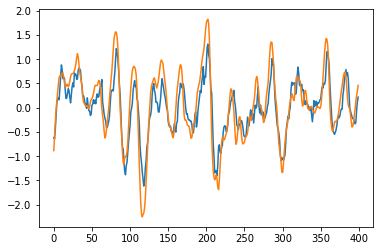

In [158]:
_, val_stats,preddd,trr1 = evaluate_LIM(valloader,best_model_lim, device=device,return_preds=True)
plt.plot(trr1[0:400])
plt.plot(preddd[0:400])

In [75]:
def metric_crps(mu, sigma, truth):
    """
    http://cran.nexr.com/web/packages/scoringRules/vignettes/crpsformulas.html
    """
    
    # The following three variables are just for convenience
    loc = (truth - mu) / sigma
    print(loc)
    phi = 1.0 / np.sqrt(2.0 * np.pi) * np.exp(-np.square(loc) / 2.0)
    print(phi)

    Phi = 0.5 * (1.0 + scipy.special.erf(loc / np.sqrt(2.0)))
    print(Phi)
    
    # First we will compute the crps for each input/target pair
    crps_arr = sigma * (loc * (2. * Phi - 1.) + 2 * phi - 1. / np.sqrt(np.pi))
    
    return crps_arr

In [90]:
def crps_cost_function(mu,sigma,truth):
    """
    compute the CRPS cost function of a normal distribution defined by the
    mean and std. 
    
    Args: 
        y_true: true values
        y_pred: tensor containing preds [mean,std]
    
    Returns: 
        mean_crps: Scalar with mean CRPS over the batch
    
    """
    #the following three variabsles are for convenience 
    loc =(truth-mu)/sigma
    print(loc)
    phi =1.0 / torch.sqrt(torch.as_tensor(2.0*math.pi))*torch.exp(-torch.square(loc)/2.0)
    print(phi)
    Phi = 0.5*(1.0+torch.erf((loc/torch.sqrt(torch.as_tensor(2.0)))))#loc/sqrt(2.0)
    print(Phi)
    #crps for the target pair. 
    crps = sigma * (loc * (2.0 * Phi - 1.) + 2.0 * phi - 1.0 / torch.sqrt(torch.as_tensor(math.pi)))
    crps = crps
    return crps


In [96]:
v1 =np.random.normal(loc=0.2,scale=0.01,size=10)+np.ones(10)
v2 =np.random.normal(loc=0.2,scale=0.01,size=10)+np.ones(10)
v3 =np.random.normal(loc=0.2,scale=0.01,size=10)+np.ones(10)

metric_crps(v1,v2,v3)


[ 0.01113884 -0.00020321  0.01128431 -0.02538089 -0.01307811  0.01131238
 -0.0070555  -0.01806414  0.00868192 -0.01380709]
[0.39891753 0.39894227 0.39891688 0.3988138  0.39890816 0.39891675
 0.39893235 0.3988772  0.39892725 0.39890426]
[0.50444366 0.49991893 0.50450169 0.48987558 0.49478274 0.50451289
 0.49718528 0.49279384 0.50346354 0.49449194]


array([0.27933488, 0.27799745, 0.27852655, 0.28281295, 0.27646565,
       0.28064529, 0.28083297, 0.28209573, 0.28024422, 0.27621996])

In [97]:
print('!!!!!!!!!!!!!!!!!')
crps_cost_function(torch.as_tensor(v1),torch.as_tensor(v2),torch.as_tensor(v3))

!!!!!!!!!!!!!!!!!
tensor([ 0.0111, -0.0002,  0.0113, -0.0254, -0.0131,  0.0113, -0.0071, -0.0181,
         0.0087, -0.0138], dtype=torch.float64)
tensor([0.3989, 0.3989, 0.3989, 0.3988, 0.3989, 0.3989, 0.3989, 0.3989, 0.3989,
        0.3989], dtype=torch.float64)
tensor([0.5044, 0.4999, 0.5045, 0.4899, 0.4948, 0.5045, 0.4972, 0.4928, 0.5035,
        0.4945], dtype=torch.float64)


tensor([0.2793, 0.2780, 0.2785, 0.2828, 0.2765, 0.2806, 0.2808, 0.2821, 0.2802,
        0.2762], dtype=torch.float64)

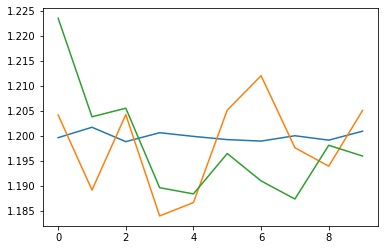

In [87]:
crps_cost_function(torch.as_tensor(np.ones(10)),torch.as_tensor(np.ones(10)),torch.as_tensor(np.ones(10)))

In [129]:
MLP_layer = LIM_MLP_GaussLL(static_feats.shape[0], 1, act_func='relu', batch_norm=net_params['mlp_batch_norm'],
                                    dropout=0.1, device='cpu',L=4)

outputdim: 1


In [136]:
inputs=torch.randn([32,1518])
out,var  = MLP_layer.forward(inputs)

In [137]:
out

tensor([[ 0.1421],
        [ 0.1267],
        [-0.5329],
        [ 0.1751],
        [ 0.0904],
        [ 0.2744],
        [-0.5532],
        [-0.0835],
        [-0.0815],
        [-0.2265],
        [-0.1281],
        [-0.4995],
        [-0.4092],
        [ 0.1419],
        [-0.2855],
        [-0.4422],
        [-0.5370],
        [-0.0255],
        [-0.5271],
        [-0.5626],
        [-0.6112],
        [-0.1703],
        [-0.3746],
        [ 0.5544],
        [-0.2144],
        [-0.1019],
        [ 0.2033],
        [-0.0309],
        [-0.9037],
        [-0.1746],
        [ 0.1532],
        [-0.2511]], grad_fn=<AddmmBackward0>)

In [144]:
var

Softplus(
  beta=tensor([[-0.3367],
          [-0.4430],
          [ 0.2943],
          [ 0.2020],
          [-0.1496],
          [-0.4808],
          [-0.0380],
          [-0.2656],
          [ 0.2796],
          [ 0.0769],
          [-0.0215],
          [-0.1703],
          [-0.1368],
          [ 0.3198],
          [-0.1118],
          [-0.9012],
          [ 0.1363],
          [ 0.1365],
          [-0.0063],
          [-0.1978],
          [ 0.0102],
          [-0.0178],
          [-0.0984],
          [ 1.1223],
          [ 0.3158],
          [ 0.0365],
          [ 0.3316],
          [-0.1578],
          [ 0.3018],
          [ 0.0129],
          [ 0.2734],
          [-0.0667]], grad_fn=<AddmmBackward0>), threshold=20
)